# Zillow Data Time Series Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 - Emily Marsh
 - Self Paced
 - Scheduled Project Review Date/Time:
 - Instructor Name: Morgan Jones

# Introduction

In the United States, a common investment oppurtunity for personal and commercial investment is real estate. In 2023 the average the average annual return on investment for residential real estate in the United States is 10.6 percent. Commercial real estate averages a slightly lower ROI of 9.5 percent, while REITs average a slightly higher 11.8 percent. There have been recent historical events that have had an impact on this annual return on investment. The housing crash in 2011 as well as the COVID pandemic of 2020 have had outsized impacts on pricing of housing, however a consistent increase over time has made this an area of consistent profits. Compass Real Estate, an real estate brokerage company that specializes in high-margin, luxury homes in upscale markets, has commissioned this project to expand into a new lower cost housing market in order to appeal to a broader group of clients and quicker cash flow. 

## Business Objective

Compass Real Estate is interested in investing in lower priced housing, under $300,000, for a smaller but more consistent revenue stream to supplement their luxury housing investments. This will also give the company the chance to expand their client base to more middle class home buyers. However, before investing capitol in this new venture, Compass would like to do analysis into determining the best five zipcodes that provides the biggest chance of profit. Using the dataset, this analysis will provide insight into the five best zip codes for investment as well as the projected profits over the next five years in each zip code. These predictions will be made using Time Series modeling. 

## Dataset

The dataset used for this project is a subset of a larger dataset from Zillow, and consists of **14,732 rows** and **272 columns**. The format of the dataset includes features about **RegionID, Region Name (Zipcode), City, State, Metro, County Name, Size Rank**, and the **average price of houses in the zipcode starting in April of 1994 and ending with April of 2018**. Each **RegionName/Zipcode** is a unique value, while **Metro and County Name** are not. It is also important to note that the dataset is in a **wide format** versus a **long format**. Therefore in order to pass this data into a model, the dataset will need to be reshaped to a **long format**. 

## Import Libraries

In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install scalecast --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Importing necessary Packages

from numpy.random import seed
seed(1)
import warnings
import itertools
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
%matplotlib inline
import geopandas as gpd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
import holidays
import pickle
from scalecast.Forecaster import Forecaster
from tqdm.notebook import tqdm
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
from keras.optimizers import Adam



import warnings
warnings.filterwarnings('ignore')

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

## Initial Data Exploration

In [8]:
#using CSV reader to read dataframe into pandas

df = pd.read_csv('/content/drive/MyDrive/Flatiron DS Program/Phase Four Project/zillow_data.csv')

In [9]:
#initial overview of datasets columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [10]:
#exploring the total amount of columns and rows in dataset

df

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

In [11]:
#observing values and format of the dataframe
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

## Data Understanding

Within this dataset, 4 of the features are string values, 49 are integers, and 219 are floats. As was mentioned earlier, this dataset is in a wide format instead of a long format. Long format will be necessary for passing the dataset into a model. Additional investigation will be necessary to determine if there are any null values in the dataset that could interfere with accurate results. 

## Check for Null Values

In [12]:
# checking for null values and returning it as a pandas series
empty=df.isna().sum()
empty.head(20)

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
dtype: int64

After additional investigation, the dataset appears to contain null values in the metro column and in some of the prices. Since the dataset that will be modeled will be a subset of this dataset, the prescence of null values will be checked again. 

# Data Preparation

 A dataset with 14723 rows would require substantial processing power to run through a model. Therefore in order to streamline the process, the dataset will be filtered using the client's budget and the zipcodes that show the greatest return on investment. In order to determine this, the profit of each zip code will be subtracted from the original price of the average property in April of 1996 from the average property value in April of 2018. Due to the client's budget, the available houses will be limited by price, only properties with a value of under $300,000 as of April 2018. Since Compass is a national company, geography is not a limiting factor for investment consideration therefore no geographical constraints will be used to limit the available zipcodes. 

## Filtering for Properties Under Client Budget

Since Compass Real Estate is interested in expanding into more middle class housing, the analysis will focus on properties that are under the price of $300,000 as of April 2018.

In [13]:
#creating new dataframe with only properties that are under $300,000 as of 2018-04
client_budget = df[df['2018-04']<=300000]

In [14]:
#Examining new dataframe size with budget restrictions
client_budget

RegionID  RegionName          City State            Metro CountyName  \
4         93144       79936       El Paso    TX          El Paso    El Paso   
5         91733       77084       Houston    TX          Houston     Harris   
8         91940       77449          Katy    TX          Houston     Harris   
11        71831       32162  The Villages    FL     The Villages     Sumter   
14        74101       37013     Nashville    TN        Nashville   Davidson   
...         ...         ...           ...   ...              ...        ...   
14715     62556       12429        Esopus    NY         Kingston     Ulster   
14717     62697       12720        Bethel    NY              NaN   Sullivan   
14718     58333        1338      Ashfield    MA  Greenfield Town   Franklin   
14719     59107        3293     Woodstock    NH        Claremont    Grafton   
14720     75672       40404         Berea    KY         Richmond    Madison   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
4             5   77300.0   77300.0   77300.0  ...   119100   119400   120000   
5             6   95000.0   95200.0   95400.0  ...   157900   158700   160200   
8             9   95400.0   95600.0   95800.0  ...   166800   167400   168400   
11           12  101000.0  100700.0  100400.0  ...   249900   250400   249900   
14           15  112400.0  112700.0  113000.0  ...   193000   194900   196600   
...         ...       ...       ...       ...  ...      ...      ...      ...   
14715     14716   78300.0   78300.0   78200.0  ...   164200   166600   170000   
14717     14718   62500.0   62600.0   62700.0  ...   122200   122700   122300   
14718     14719   94600.0   94300.0   94000.0  ...   216800   217700   218600   
14719     14720   92700.0   92500.0   92400.0  ...   202100   208400   212200   
14720     14721   57100.0   57300.0   57500.0  ...   121800   122800   124600   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
4       120300   120300   120300   120300   120500   121000   121500  
5       161900   162800   162800   162800   162900   163500   164300  
8       169600   170900   172300   173300   174200   175400   176200  
11      248700   247500   247100   246800   247500   249800   251800  
14      198800   201300   203800   205900   207600   210000   211900  
...        ...      ...      ...      ...      ...      ...      ...  
14715   171000   170700   171300   172400   173600   175800   177500  
14717   122000   122200   122800   123200   123200   120700   117700  
14718   218500   218100   216400   213100   209800   209200   209300  
14719   215200   214300   213100   213700   218300   222700   225800  
14720   126700   128800   130600   131700   132500   133000   133400  

[10632 rows x 272 columns]

Even with the budget limit of $3000,000, Compass Real Estate has many zipcodes to potentially choose from. In order to determine which zipcodes have the greates ROI and limit the zipcodes being considered for modeling, a new column will be created to show the total increase in value from April of 1996 to April of 2018.

## Creating Total Price Increase Column to Dataframe

Since the client, Compass Real Estate, is interested in maximizing profits, a new column showing the total increase in price from April of 1996 to April of 2018 will be added to the dataset. As a result, a house that has gained the most dollar value compared to its intial price over this time will be the most desirable for the clients. 

In [15]:
#Creating a new column with April 2018 price minus the price in April of 1996 to show overall value increase over 
#the time period
client_budget.loc[:,'Total Price Increase'] = (
    client_budget['2018-04'] - client_budget['1996-04']
            )

In [16]:
#examining new Total Price Increase Column
client_budget

RegionID  RegionName          City State            Metro CountyName  \
4         93144       79936       El Paso    TX          El Paso    El Paso   
5         91733       77084       Houston    TX          Houston     Harris   
8         91940       77449          Katy    TX          Houston     Harris   
11        71831       32162  The Villages    FL     The Villages     Sumter   
14        74101       37013     Nashville    TN        Nashville   Davidson   
...         ...         ...           ...   ...              ...        ...   
14715     62556       12429        Esopus    NY         Kingston     Ulster   
14717     62697       12720        Bethel    NY              NaN   Sullivan   
14718     58333        1338      Ashfield    MA  Greenfield Town   Franklin   
14719     59107        3293     Woodstock    NH        Claremont    Grafton   
14720     75672       40404         Berea    KY         Richmond    Madison   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-08  2017-09  2017-10  \
4             5   77300.0   77300.0   77300.0  ...   119400   120000   120300   
5             6   95000.0   95200.0   95400.0  ...   158700   160200   161900   
8             9   95400.0   95600.0   95800.0  ...   167400   168400   169600   
11           12  101000.0  100700.0  100400.0  ...   250400   249900   248700   
14           15  112400.0  112700.0  113000.0  ...   194900   196600   198800   
...         ...       ...       ...       ...  ...      ...      ...      ...   
14715     14716   78300.0   78300.0   78200.0  ...   166600   170000   171000   
14717     14718   62500.0   62600.0   62700.0  ...   122700   122300   122000   
14718     14719   94600.0   94300.0   94000.0  ...   217700   218600   218500   
14719     14720   92700.0   92500.0   92400.0  ...   208400   212200   215200   
14720     14721   57100.0   57300.0   57500.0  ...   122800   124600   126700   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
4       120300   120300   120300   120500   121000   121500   
5       162800   162800   162800   162900   163500   164300   
8       170900   172300   173300   174200   175400   176200   
11      247500   247100   246800   247500   249800   251800   
14      201300   203800   205900   207600   210000   211900   
...        ...      ...      ...      ...      ...      ...   
14715   170700   171300   172400   173600   175800   177500   
14717   122200   122800   123200   123200   120700   117700   
14718   218100   216400   213100   209800   209200   209300   
14719   214300   213100   213700   218300   222700   225800   
14720   128800   130600   131700   132500   133000   133400   

       Total Price Increase  
4                   44200.0  
5                   69300.0  
8                   80800.0  
11                 150800.0  
14                  99500.0  
...                     ...  
14715               99200.0  
14717               55200.0  
14718              114700.0  
14719              133100.0  
14720               76300.0  

[10632 rows x 273 columns]

From the limited view of the available 10,632 rows, a range of profits over time are already evident. It will be necessary to order the data by these values to determine which zip codes have the greatest total value increase.  

## Ordering By Total Price Increase and Creating a Top 25 Zip Code Dataset

Since the client is limited by resources to only focus on five zipcodes and with limited processing power, the top 25 Zip Codes will be modeled to give options for selecting the top five zip codes that maximize profit and predicting future profits. 

In [17]:
#ordering the dataframe from highest value of Total Price Increase to find the top 25 zipcodes 
top_25_zips = client_budget.sort_values(by=['Total Price Increase'], ascending=False).head(25)

In [18]:
#examine new dataframe of top 25 zipcodes according to total price increase
top_25_zips

RegionID  RegionName            City State                Metro  \
13830     66102       19951        Harbeson    DE            Salisbury   
14217     93399       80449         Hartsel    CO               Denver   
3615      65792       19125    Philadelphia    PA         Philadelphia   
11353     95177       86334         Paulden    AZ             Prescott   
2656      73011       34120          Naples    FL               Naples   
8350      92632       78721          Austin    TX               Austin   
3153      99192       97321          Albany    OR               Albany   
13470     82893       56511         Audubon    MN                  NaN   
8743      99229       97370       Philomath    OR            Corvallis   
10598     64752       16827       Boalsburg    PA        State College   
1059      64741       16801   State College    PA        State College   
3878      71886       32233  Atlantic Beach    FL         Jacksonville   
5727      95167       86323    Chino Valley    AZ             Prescott   
7636      82259       55409     Minneapolis    MN  Minneapolis-St Paul   
10414     82858       56442      Cross Lake    MN             Brainerd   
14685     93405       80456       Jefferson    CO               Denver   
7121      72928       33947    Rotonda West    FL          Punta Gorda   
2838      85926       63108     Saint Louis    MO            St. Louis   
13751     82859       56443         Cushing    MN                  NaN   
9695      88764       70734         Geismar    LA          Baton Rouge   
5145      74247       37216       Nashville    TN            Nashville   
6048      83143       57110     Sioux Falls    SD          Sioux Falls   
6983      66116       19968          Milton    DE            Salisbury   
1758      71036       30316         Atlanta    GA              Atlanta   
4914      72705       33602           Tampa    FL                Tampa   

             CountyName  SizeRank  1996-04  1996-05  1996-06  ...  2017-08  \
13830            Sussex     13831  34500.0  34900.0  35200.0  ...   258600   
14217              Park     14218  30000.0  30400.0  30900.0  ...   244600   
3615       Philadelphia      3616  32600.0  32700.0  32800.0  ...   249000   
11353           Yavapai     11354  41100.0  41400.0  41700.0  ...   229800   
2656            Collier      2657  68600.0  67900.0  67200.0  ...   289800   
8350             Travis      8351  69200.0  68800.0  68400.0  ...   281200   
3153               Linn      3154  71600.0  71900.0  72200.0  ...   286800   
13470            Becker     13471  59200.0  59300.0  59500.0  ...   281000   
8743             Benton      8744  69300.0  69700.0  70000.0  ...   278300   
10598            Centre     10599  67500.0  67700.0  67900.0  ...   274400   
1059             Centre      1060  72600.0  72900.0  73000.0  ...   280400   
3878              Duval      3879  75500.0  75600.0  75700.0  ...   269300   
5727            Yavapai      5728  68500.0  67500.0  66600.0  ...   264500   
7636           Hennepin      7637  81500.0  81600.0  81600.0  ...   280100   
10414         Crow Wing     10415  74300.0  74600.0  74900.0  ...   278300   
14685              Park     14686  37300.0  38100.0  38800.0  ...   232700   
7121          Charlotte      7122  39200.0  39100.0  38900.0  ...   245100   
2838   Saint Louis City      2839  69300.0  69600.0  70100.0  ...   269300   
13751          Morrison     13752  59500.0  59700.0  59900.0  ...   275200   
9695          Ascension      9696  56800.0  57000.0  57300.0  ...   268900   
5145           Davidson      5146  72800.0  72800.0  72800.0  ...   278200   
6048          Minnehaha      6049  30100.0  31200.0  32300.0  ...   230900   
6983             Sussex      6984  73400.0  72500.0  71600.0  ...   266400   
1758             Fulton      1759  62300.0  62300.0  62300.0  ...   244200   
4914       Hillsborough      4915  57800.0  57700.0  57700.0  ...   252200   

       2017-09  2017-10  2017-11  2017-12  2018-01  2

In [19]:
empty_25=top_25_zips.isna().sum()
empty_25.head(40)

RegionID      0
RegionName    0
City          0
State         0
Metro         2
CountyName    0
SizeRank      0
1996-04       0
1996-05       0
1996-06       0
1996-07       0
1996-08       0
1996-09       0
1996-10       0
1996-11       0
1996-12       0
1997-01       0
1997-02       0
1997-03       0
1997-04       0
1997-05       0
1997-06       0
1997-07       0
1997-08       0
1997-09       0
1997-10       0
1997-11       0
1997-12       0
1998-01       0
1998-02       0
1998-03       0
1998-04       0
1998-05       0
1998-06       0
1998-07       0
1998-08       0
1998-09       0
1998-10       0
1998-11       0
1998-12       0
dtype: int64

After checking, the Top 25 Zip Codes dataset only contains two null values in the Metro column. This feature column is unimportant to the modeling process as this feature will be dropped in favor of using RegionName/Zipcode. 

## Visualizing the Geographic Spread of the Top 25 Zip Codes

Despite the client, Compass Real Estate, not being limited to geographic locations, there might be valuable insight by looking at geographic trends among the top 25 zipcodes for potential maximizing of resources. A dataset with latitute and longitude values for each Zipcode will be created in order to create a useful visual. 

In [20]:
#extracting the top 25 Zipcodes from the dataset
list(top_25_zips['RegionName'])

[19951,
 80449,
 19125,
 86334,
 34120,
 78721,
 97321,
 56511,
 97370,
 16827,
 16801,
 32233,
 86323,
 55409,
 56442,
 80456,
 33947,
 63108,
 56443,
 70734,
 37216,
 57110,
 19968,
 30316,
 33602]

In [21]:
#creating a list of values for the longitude and latitude of each Zipcode
coord = [(19951, 38.6898, -75.24000), (80449, 38.95689,-105.87044), (19125, 39.97641,-75.12217), (86334, 34.94867,-112.54443), 
        (34120, 26.32277,-81.55923),(78721, 30.26619,-97.68476), (97321, 44.63339,-123.13956), (56511, 46.84768,-96.01409), (97370, 44.59613,-123.45873), 
         (16827, 40.77297,-77.76024), (16801, 40.78681,-77.84438), (32233, 30.36143,-81.42642), (86323, 34.83896,-112.39677), (55409, 44.92652,-93.29081), (56442, 46.68866,-94.09915),
        (80456, 39.35346,-105.77032), (33947, 26.88093,-82.26993), (63108, 38.64461,-90.25198), (56443, 46.19521,-94.55463), (70734, 30.20703,-91.00902),
        (37216, 36.21681,-86.72443), (57110, 43.54969,-96.63113), (19968, 38.76454,-75.29784), (30316, 33.71759,-84.33225), (33602, 27.94946,-82.46118)]

In [22]:
#creating a dataframe with the longitude, latitude, and RegionName values
zip_long_lat = pd.DataFrame(coord, columns=['RegionName', 'Latitude', 'Longitude'])

In [23]:
#examining dataframe
zip_long_lat

RegionName  Latitude  Longitude
0        19951  38.68980  -75.24000
1        80449  38.95689 -105.87044
2        19125  39.97641  -75.12217
3        86334  34.94867 -112.54443
4        34120  26.32277  -81.55923
5        78721  30.26619  -97.68476
6        97321  44.63339 -123.13956
7        56511  46.84768  -96.01409
8        97370  44.59613 -123.45873
9        16827  40.77297  -77.76024
10       16801  40.78681  -77.84438
11       32233  30.36143  -81.42642
12       86323  34.83896 -112.39677
13       55409  44.92652  -93.29081
14       56442  46.68866  -94.09915
15       80456  39.35346 -105.77032
16       33947  26.88093  -82.26993
17       63108  38.64461  -90.25198
18       56443  46.19521  -94.55463
19       70734  30.20703  -91.00902
20       37216  36.21681  -86.72443
21       57110  43.54969  -96.63113
22       19968  38.76454  -75.29784
23       30316  33.71759  -84.33225
24       33602  27.94946  -82.46118

In [24]:
#merging the latitude and longitude dataframe with the Top 25 Zipcode Dataframe
top_25_full_df = pd.merge(top_25_zips, zip_long_lat, on=["RegionName"])

In [25]:
#examining new full dataset
top_25_full_df

RegionID  RegionName            City State                Metro  \
0      66102       19951        Harbeson    DE            Salisbury   
1      93399       80449         Hartsel    CO               Denver   
2      65792       19125    Philadelphia    PA         Philadelphia   
3      95177       86334         Paulden    AZ             Prescott   
4      73011       34120          Naples    FL               Naples   
5      92632       78721          Austin    TX               Austin   
6      99192       97321          Albany    OR               Albany   
7      82893       56511         Audubon    MN                  NaN   
8      99229       97370       Philomath    OR            Corvallis   
9      64752       16827       Boalsburg    PA        State College   
10     64741       16801   State College    PA        State College   
11     71886       32233  Atlantic Beach    FL         Jacksonville   
12     95167       86323    Chino Valley    AZ             Prescott   
13     82259       55409     Minneapolis    MN  Minneapolis-St Paul   
14     82858       56442      Cross Lake    MN             Brainerd   
15     93405       80456       Jefferson    CO               Denver   
16     72928       33947    Rotonda West    FL          Punta Gorda   
17     85926       63108     Saint Louis    MO            St. Louis   
18     82859       56443         Cushing    MN                  NaN   
19     88764       70734         Geismar    LA          Baton Rouge   
20     74247       37216       Nashville    TN            Nashville   
21     83143       57110     Sioux Falls    SD          Sioux Falls   
22     66116       19968          Milton    DE            Salisbury   
23     71036       30316         Atlanta    GA              Atlanta   
24     72705       33602           Tampa    FL                Tampa   

          CountyName  SizeRank  1996-04  1996-05  1996-06  ...  2017-10  \
0             Sussex     13831  34500.0  34900.0  35200.0  ...   260300   
1               Park     14218  30000.0  30400.0  30900.0  ...   251300   
2       Philadelphia      3616  32600.0  32700.0  32800.0  ...   253900   
3            Yavapai     11354  41100.0  41400.0  41700.0  ...   237000   
4            Collier      2657  68600.0  67900.0  67200.0  ...   293800   
5             Travis      8351  69200.0  68800.0  68400.0  ...   284000   
6               Linn      3154  71600.0  71900.0  72200.0  ...   289500   
7             Becker     13471  59200.0  59300.0  59500.0  ...   279100   
8             Benton      8744  69300.0  69700.0  70000.0  ...   284400   
9             Centre     10599  67500.0  67700.0  67900.0  ...   278200   
10            Centre      1060  72600.0  72900.0  73000.0  ...   285400   
11             Duval      3879  75500.0  75600.0  75700.0  ...   274600   
12           Yavapai      5728  68500.0  67500.0  66600.0  ...   266200   
13          Hennepin      7637  81500.0  81600.0  81600.0  ...   284800   
14         Crow Wing     10415  74300.0  74600.0  74900.0  ...   283200   
15              Park     14686  37300.0  38100.0  38800.0  ...   238200   
16         Charlotte      7122  39200.0  39100.0  38900.0  ...   248100   
17  Saint Louis City      2839  69300.0  69600.0  70100.0  ...   267600   
18          Morrison     13752  59500.0  59700.0  59900.0  ...   275900   
19         Ascension      9696  56800.0  57000.0  57300.0  ...   270100   
20          Davidson      5146  72800.0  72800.0  72800.0  ...   279600   
21         Minnehaha      6049  30100.0  31200.0  32300.0  ...   233500   
22            Sussex      6984  73400.0  72500.0  71600.0  ...   271700   
23            Fulton      1759  62300.0  62300.0  62300.0  ...   251700   
24      Hillsborough      4915  57800.0  57700.0  57700.0  ...   254400   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
0    265400   269300   272100   275300   277000   276900   
1    252900   254700   256600   259200   263400   267700   
2    255700   257100   258

In [26]:
#Importing shp of the USA map for visualization
mapdf = top_25_full_df.copy()

usa_map = gpd.read_file('/content/drive/MyDrive/Flatiron DS Program/Phase Four Project/tl_2017_us_state/tl_2017_us_state.shp')
usa_map = usa_map.to_crs("EPSG:4326")

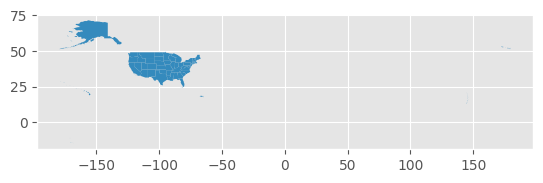

In [27]:
#examining SHP file
usa_map.plot();

In [28]:
#Removing Non Continental States from Visualization
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = usa_map
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

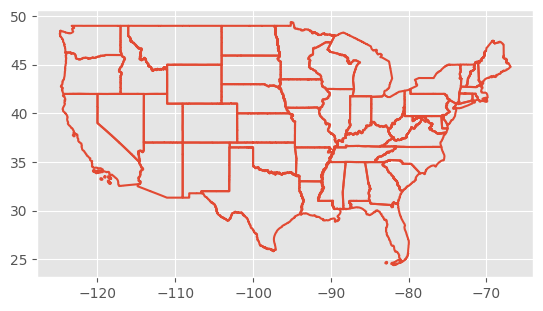

In [29]:
#examining new chart
us49.boundary.plot()
plt.show()

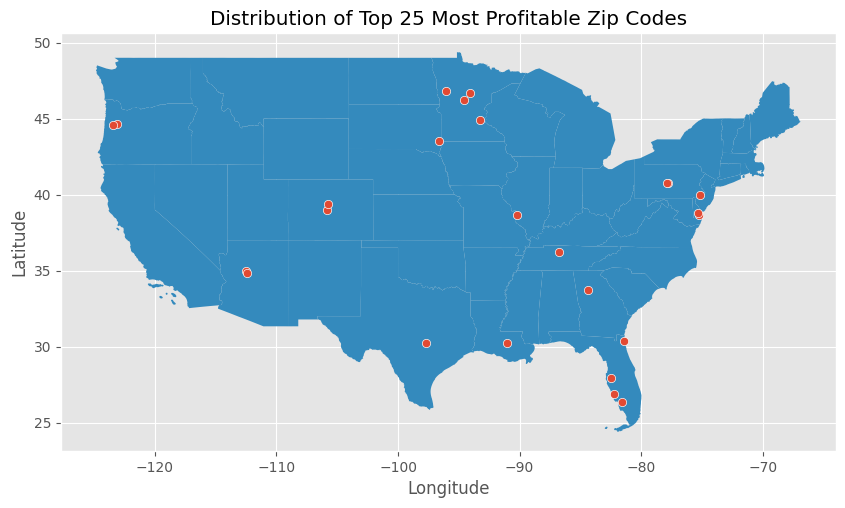

In [30]:
#Plotting the Top 25 Zip Codes on USA Chart
crs = {'init':'EPSG:4326'} #define CRS
geometry = [Point(xy) for xy in zip(mapdf['Longitude'], top_25_full_df['Latitude'])] #create Points
geo_df = gpd.GeoDataFrame(mapdf, 
                          crs = crs, 
                          geometry = geometry) #define the geometry df

#plot the data
fig, ax = plt.subplots(figsize = (10,10))
us49.to_crs(epsg=4326).plot(ax=ax)
sns.scatterplot(x="Longitude", y="Latitude",data=mapdf, ax=ax)
ax.set_title('Distribution of Top 25 Most Profitable Zip Codes')
plt.savefig("XGBoostConfusionMatrix.jpg");

As can be seen on the chart, there are some interesting geographic concentrations that could be of interest to the clients if there was a desire to consolidate resources geographically. The analysis of this project, however, will move forward with recommendations based solely on ROI considerations with no geographic consideration. 

## Visualizing the Price history of filtered Zip Codes since 1996

An important aspect of times series data series modeling is confirming that the time series on which the model is built is not affected by seasonality or trends within the data. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary through the use of mathematical transforations. Therefore the prescence of seasonality and trends negatively affect the performance of the models built using these methods. To get a better sense of whether there are any trends or seasonality in the dataset, a visualization of the average prices over the time period of the dataset will be utilized.

In [31]:
#creating a function to convert the dataset from wide format to long format
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby(['time']).aggregate({'value':'mean'})

In [32]:
#drop extra columns not needed for modeling
top_25_modeling_df = top_25_full_df.drop(['Total Price Increase', 'Latitude', 'Longitude'], axis=1)

In [33]:
#examine new dataset with dropped columns for modeling
top_25_modeling_df.head()

RegionID  RegionName          City State         Metro    CountyName  \
0     66102       19951      Harbeson    DE     Salisbury        Sussex   
1     93399       80449       Hartsel    CO        Denver          Park   
2     65792       19125  Philadelphia    PA  Philadelphia  Philadelphia   
3     95177       86334       Paulden    AZ      Prescott       Yavapai   
4     73011       34120        Naples    FL        Naples       Collier   

   SizeRank  1996-04  1996-05  1996-06  ...  2017-07  2017-08  2017-09  \
0     13831  34500.0  34900.0  35200.0  ...   260000   258600   258100   
1     14218  30000.0  30400.0  30900.0  ...   243200   244600   248000   
2      3616  32600.0  32700.0  32800.0  ...   247500   249000   251600   
3     11354  41100.0  41400.0  41700.0  ...   230300   229800   232000   
4      2657  68600.0  67900.0  67200.0  ...   288300   289800   291800   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   260300   265400   269300   272100   275300   277000   276900  
1   251300   252900   254700   256600   259200   263400   267700  
2   253900   255700   257100   258000   258500   260500   262300  
3   237000   242800   249200   253900   257800   263900   269900  
4   293800   294000   293700   294600   294700   295100   296200  

[5 rows x 272 columns]

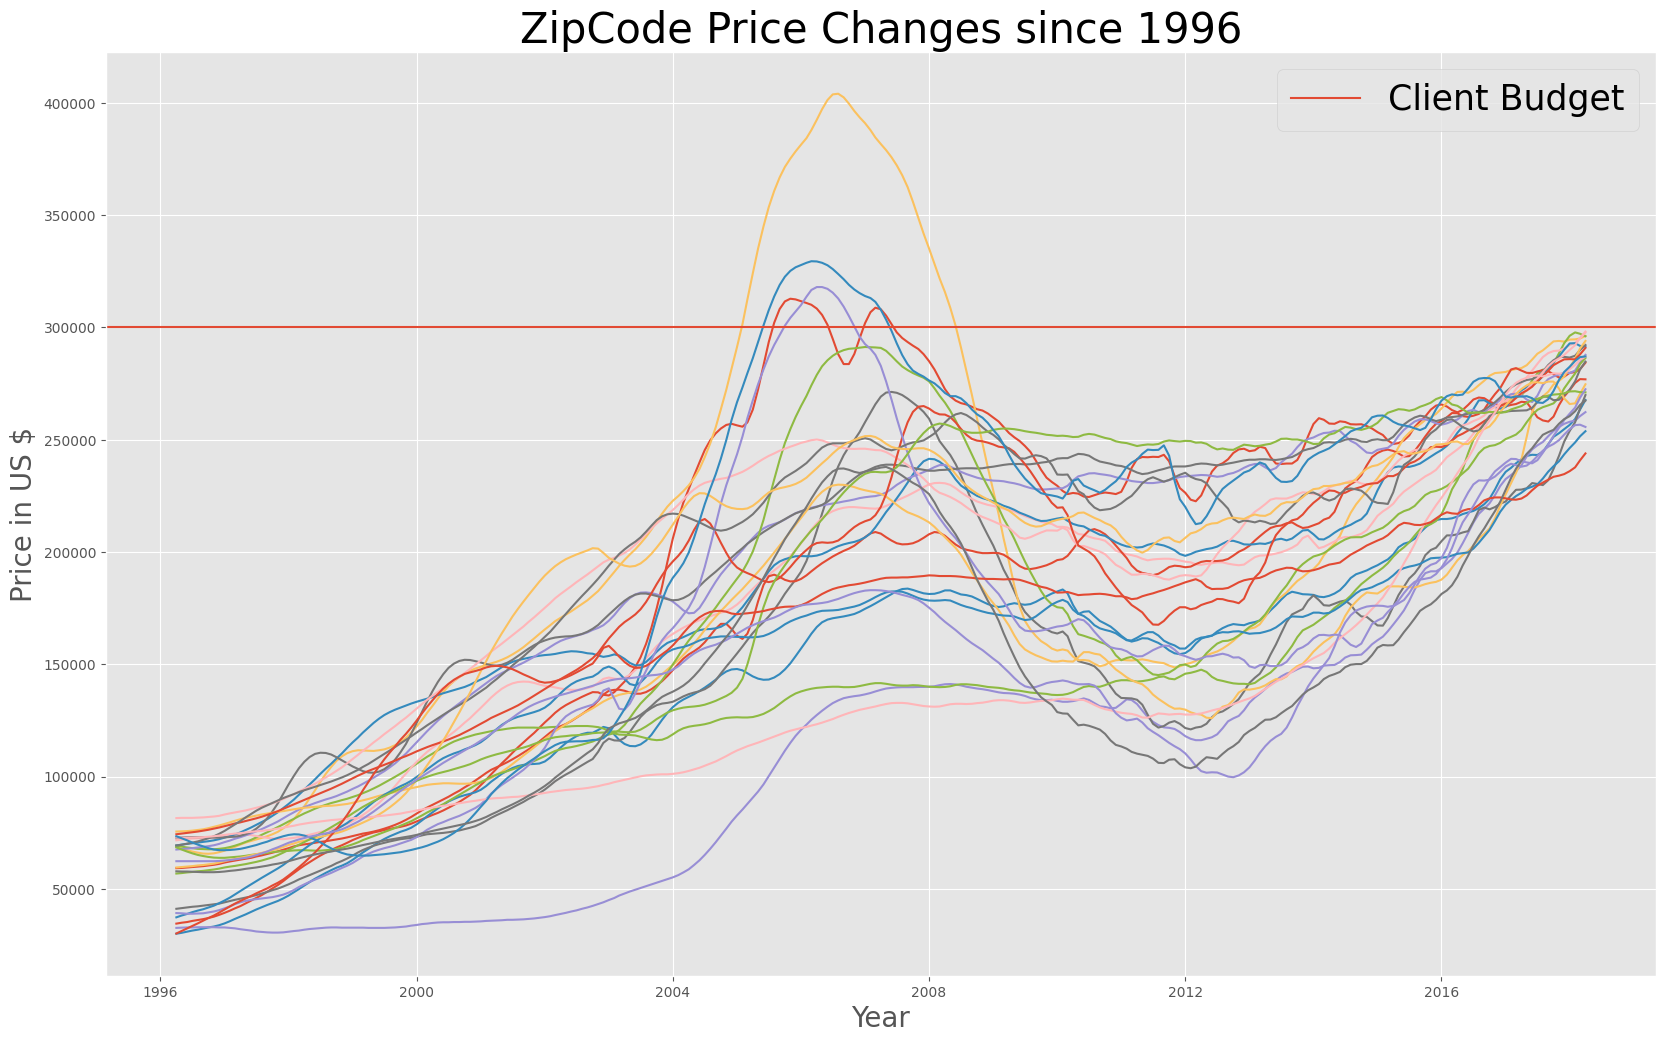

In [34]:
#creating plot of prices changes by zipcode since 1996
zip_dict = {}

for zipcode in top_25_modeling_df['RegionName']:
    zip_dict[zipcode] = melt_data(top_25_modeling_df[top_25_modeling_df['RegionName']==zipcode])

fig,ax = plt.subplots(figsize=(20,12))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode],)

ax.axhline(y=300000,label = 'Client Budget')   

ax.set_title('ZipCode Price Changes since 1996',fontsize=30)
ax.set_ylabel('Price in US $',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.legend(prop={'size': 25});

As can be seen in the visualization, there is an overall positive linear shape to the dataset. However there appear to be irregularities. Starting in 2004, some of the property prices experienced a sharp increase followed by a steep decline around 2008 till 2012. This corresponds with the 2008 financial housing crisis and recession. Since then, it appears that prices have been steadily on the rise since 2012 but have yet to reach their pre-recession peaks. There are also some outliers in the data that grew and declined more rapidly around 2008.

## Visualizing the The Zip Codes' Average Price Growth

Due to the limited amount of processing power, one zipcode will be selected from the top 25 zipcodes to build, evaluate, and help select a final model for prediction and selection. In order to select this zipcode, the top 25 zipcodes will be ordered by return on initial investment in order to select that zipcode that provided the greatest ROI. 

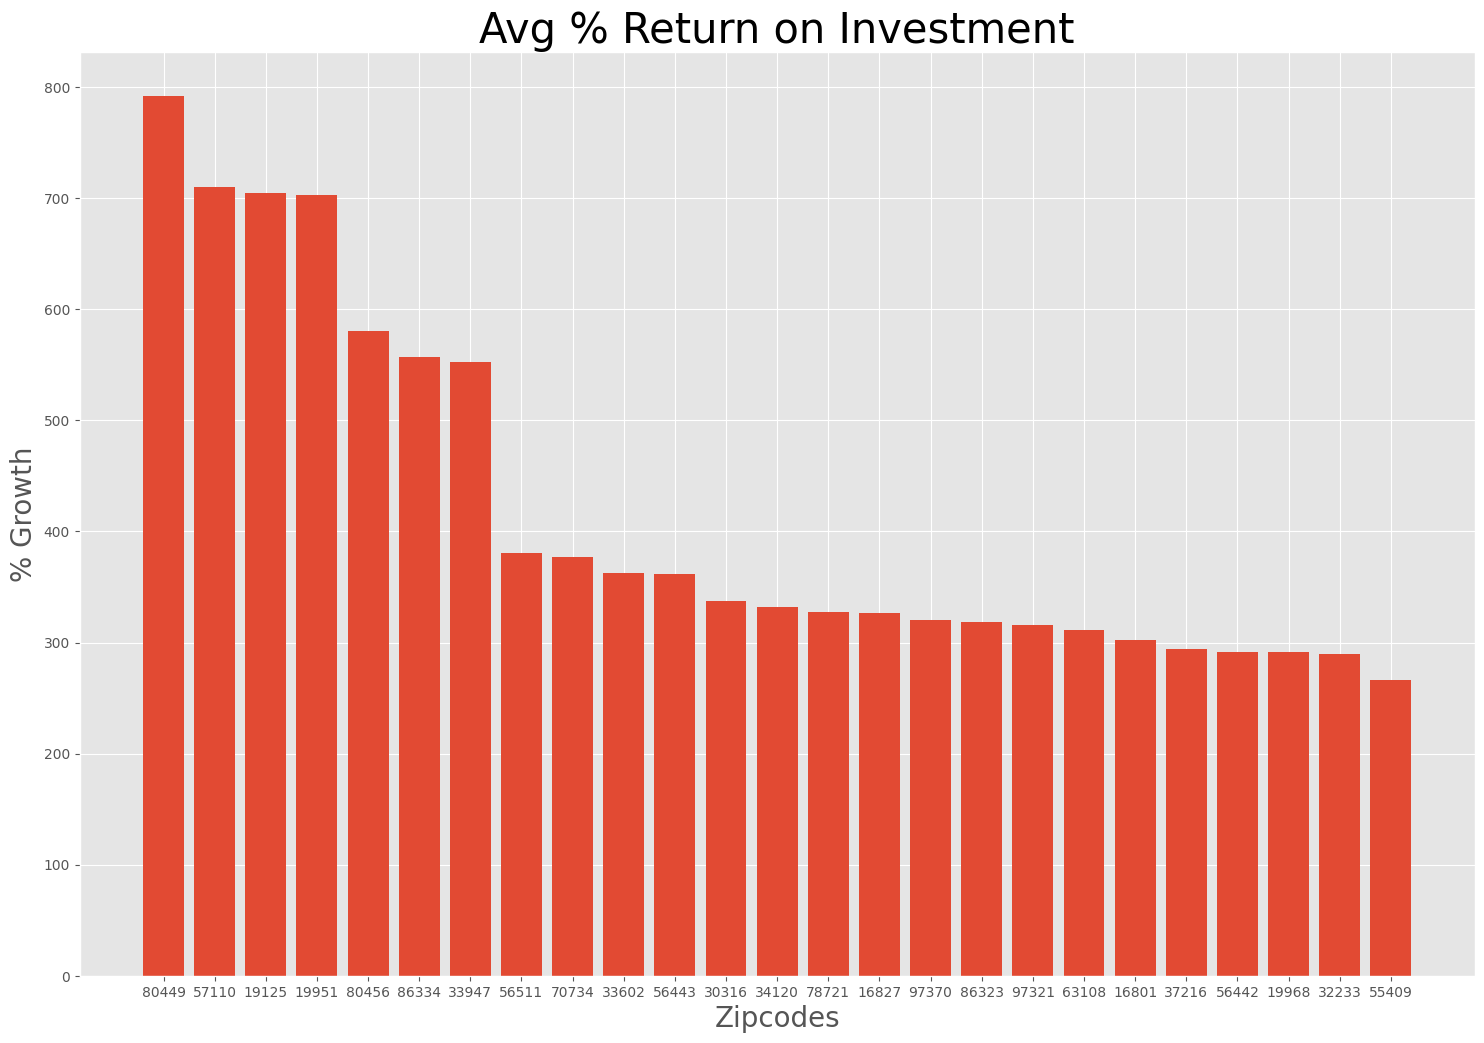

In [35]:
#creating a bar graph visual that shows the average return on investment for each of the top 25 zipcodes
warnings.filterwarnings('ignore')

#creating column with ROI
top_25_av_roi = top_25_modeling_df
top_25_av_roi['roi_since1996'] = (
    (top_25_av_roi['2018-04']-top_25_av_roi['1996-04'])/(top_25_av_roi['1996-04'])*100)
top_25_av_roi = top_25_av_roi.sort_values('roi_since1996',ascending=False)

warnings.filterwarnings('ignore')

#plotting column roi_since11 for each zipcode
fig,ax=plt.subplots(figsize=(18,12))

x_labels = [str(a) for a in top_25_av_roi['RegionName']]
x = list(range(1,26))
y = [a for a in top_25_av_roi['roi_since1996']]

ax.bar(x,y)

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel('% Growth',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on Investment',fontsize='30');

We can see from above that the largest average return on investment was in zip code 80449. It is also of interest to note that within the top six zipcodes, there seem to be some concentration around the same geographic area. Areas of growth not being limited to one zipcode is an interesting oppurtunity for clients to acheive the highest ROI while also concentrating resources. It is also an oppurtunity to gain domain knowledge about features that may be impacting this growth. 

# Selecting a ZipCode for the Initial Time Series Model

In order to build a time series model that predicts the future ROI of each of the top 25 zipcodes within the client's budget and minimizes processing time, several initial time series models will be built on one of the zipcodes in the dataset. Since zipcode 80449 is the fastest growing, it will be used to construct the time series models for evaluation. Once the final model is selected, a similar workflow can then be utilized on the other zipcodes within the dataset to identify which five zipcodes have the highest predicted ROI. 

In [36]:
#dataframe containing zipcode 80449
zip80449 = df[df['RegionName']==80449]

In [37]:
#melting zipcode 80449 from wide to long format
series80449 = melt_data(zip80449)

In [38]:
#examining 80449 long format dataset
series80449

value
time                
1996-04-01   30000.0
1996-05-01   30400.0
1996-06-01   30900.0
1996-07-01   31400.0
1996-08-01   31800.0
...              ...
2017-12-01  254700.0
2018-01-01  256600.0
2018-02-01  259200.0
2018-03-01  263400.0
2018-04-01  267700.0

[265 rows x 1 columns]

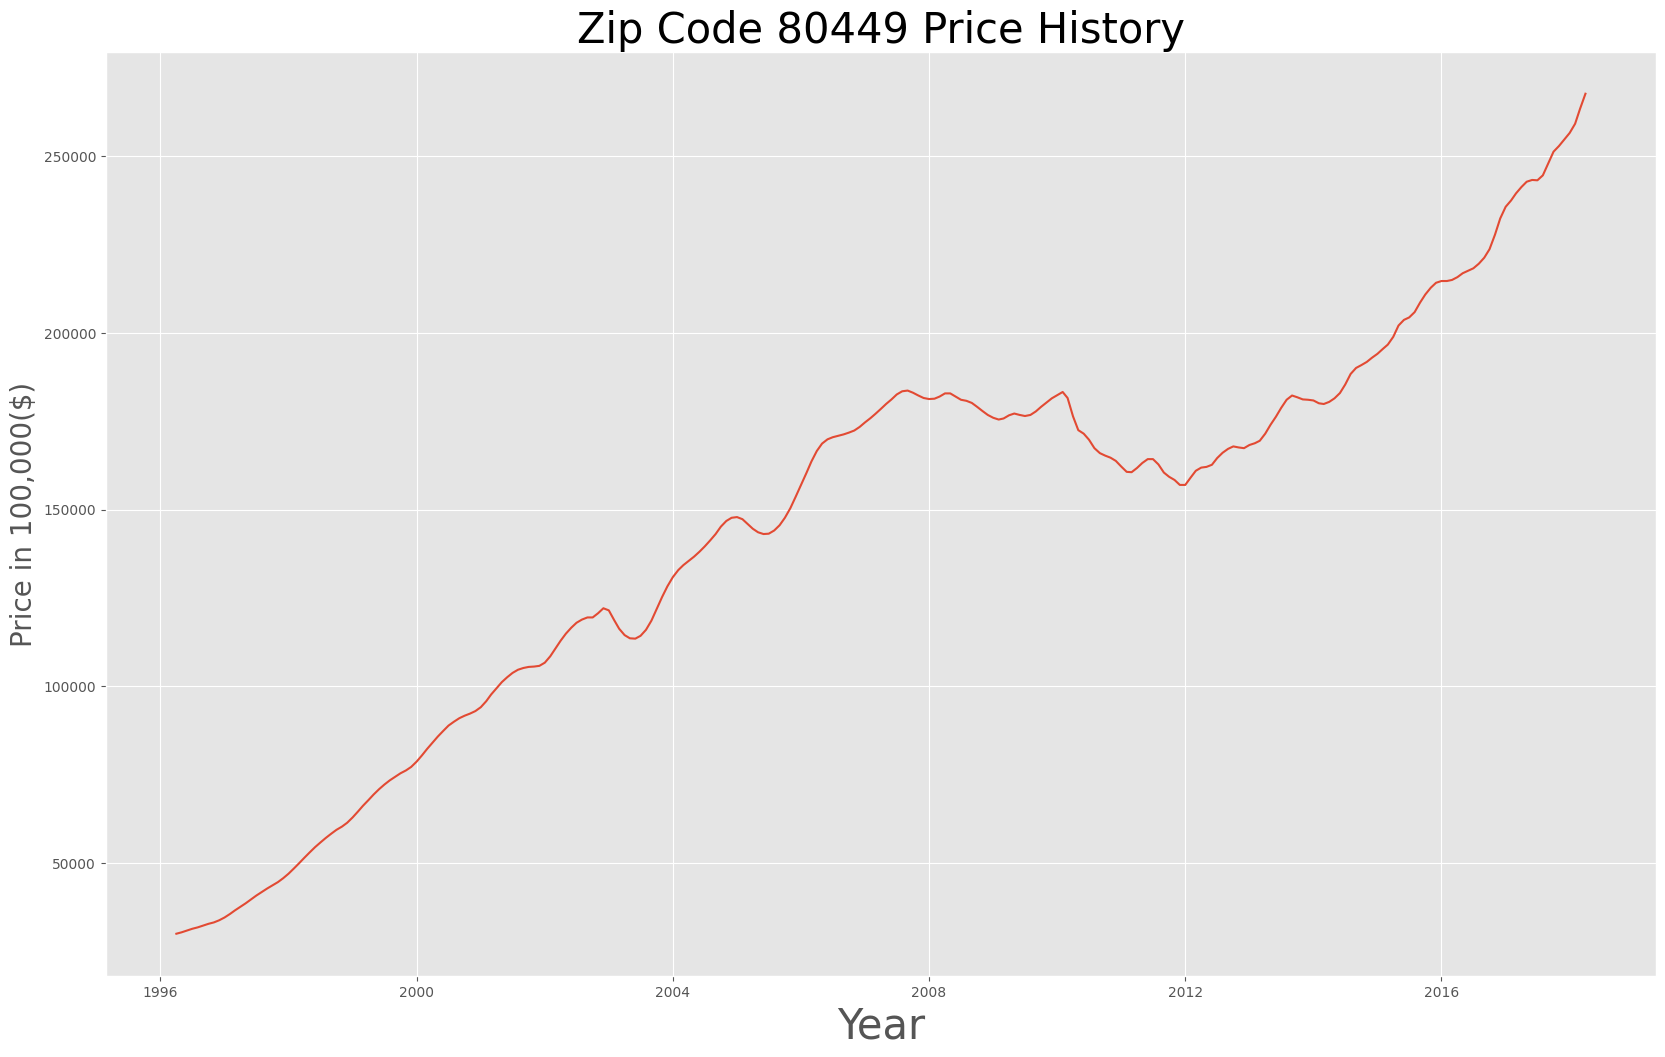

In [39]:
#Visualizing the Time Series Data for zipcode- 80449

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series80449)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 80449 Price History',fontsize=30);

After having examined the price history of all the zipcodes in the top 25 dataset, individually the zipcode of 80449 follows a similar pattern. There is a sharp increase in price around 2004 followed by a small descent around the year 2008, and then continuing a steady increase starting in 2012. As a result, it seems reasonable to expect that a time series model of this individual zipcode will also be successful with the remaining zipcodes in the dataset. 

# Checking for Trends, Stationarity & Seasonality

As was mentioned earlier, most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary through the use of mathematical transformations. Three mathematical transformations will be utilized to make the time series stationary. These are differencing, logging, and squaring the data. In order to determine which of the mathmatical transformations are the most successful, a Dickey Fuller Test will be used. 

## Stationarity of Initial 80449 Data Series

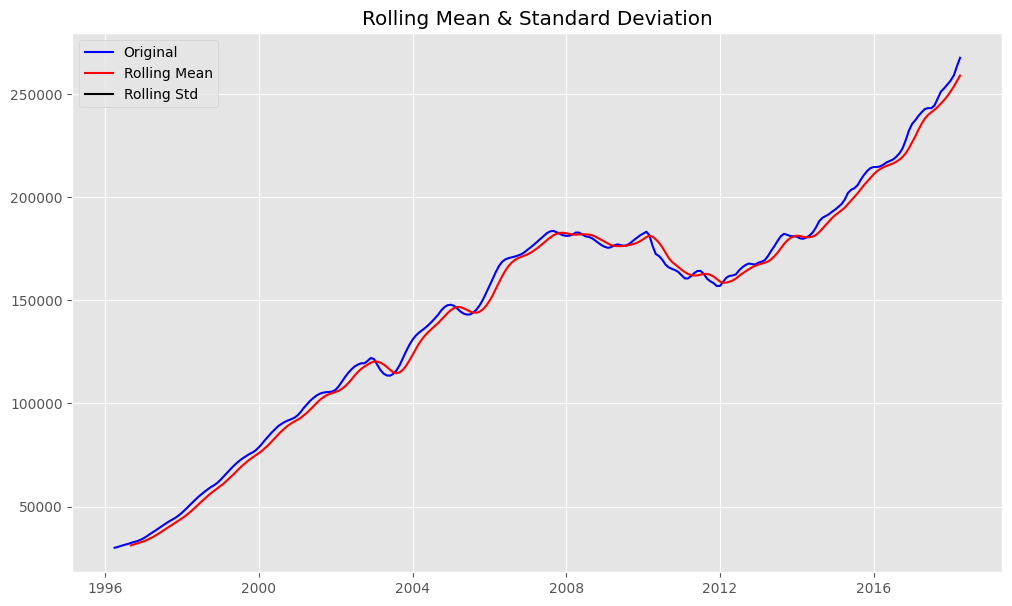

In [40]:
#examining the Rolling Mean & Standard Deviation of 80449
rolmean = series80449.rolling(window = 6, center = False).mean()
rolstd = series80449.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(series80449, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [41]:
#Dickey Fuller Test on inital 80449 time series dataset
p_val_orig = adfuller(series80449[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_orig},")
if p_val_orig < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.9503415459897898,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


As is showing in the visualization and the results of the Dickey Fuller test, the initial 80449 zipcode data series not stationary. Therefore mathematical transformations will be necessary to prepare the 80449 Data Series for modeling. 

## Differencing the 80449 Data Series for Stationarity

Differencing is one of the most common ways of trying to convert a non-stationary series into a stationary series. This is acheived by subtracting the current value of the series from the previous one, or from a lagged value.

In [42]:
#Differencing the 80449 Data Series
data_diff = series80449.diff(periods=1)
data_diff.head(10)

value
time             
1996-04-01    NaN
1996-05-01  400.0
1996-06-01  500.0
1996-07-01  500.0
1996-08-01  400.0
1996-09-01  500.0
1996-10-01  500.0
1996-11-01  400.0
1996-12-01  600.0
1997-01-01  800.0

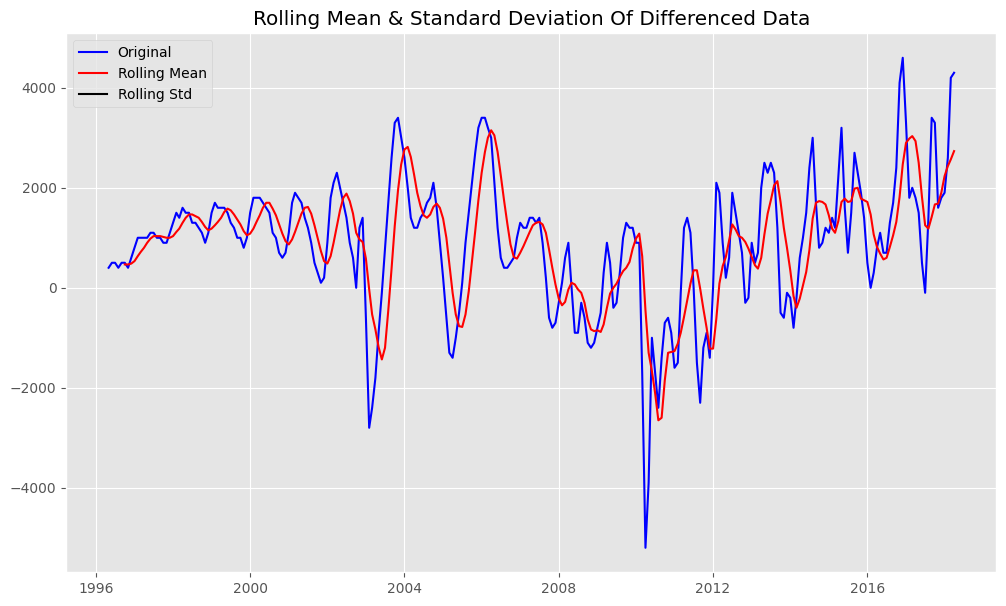

In [43]:
#examining the Rolling Mean and STD of the differenced 80449 data series
rolmean = data_diff.rolling(window = 6, center = False).mean()
rolstd = data_diff.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(data_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Of Differenced Data')
plt.show(block=False)

In [44]:
p_val_diff_1 = adfuller(data_diff[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_diff_1},")
if p_val_diff_1 < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.30144200668853177,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


The visualization shows there has been a decrease in the trends within the time series of zipcode 80449, however the p-value associated with the Dickey Fuller test is not small enough to reject the null hypothesis. In order to explore if differencing on different periods would make a difference in the p-value, a for loop is used to explore differencing periods from 0 to 25. 

In [45]:
#Exploring the p-value of shifted periods for calculating difference
def find_best_difference(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

find_best_difference(series80449)

0 nan
1 0.30144200668853177
2 0.35578029278822404
3 0.24748940108738054
4 0.3731861559286106
5 0.45246846472992297
6 0.5928948838589825
7 0.6183757128814649
8 0.6509972608489843
9 0.8112046558755531
10 0.7323846852827647
11 0.742442713548547
12 0.7042770067365571
13 0.7433009633690716
14 0.7758635692819897
15 0.5760633077144514
16 0.680523319736612
17 0.8203633371056294
18 0.7682994200552755
19 0.5219362573265781
20 0.6089457785387029
21 0.350281884227174
22 0.2363732198865896
23 0.17115845323616014
24 0.24055418744838208


None of the different periods have resulted in a p-value under .05 which is needed to reject the null hypothesis. Another mathematical transformation will be implemented on the data series to try and acheive stationarity. 

## Log Transforming the 80449 Data Series for Stationarity

Log transformation can be used to stabilize the variance of a series with non-constant variance. This penalizes higher values and thus reduces variance. One limitation of log transformation is that it can be applied only to positively valued time series. Since this data series has only positive values, log transformation can be used. 

In [46]:
#Transforming the 80449 data series using log transforming
data_log = np.log(series80449)
data_log.head(10)

value
time                 
1996-04-01  10.308953
1996-05-01  10.322198
1996-06-01  10.338511
1996-07-01  10.354563
1996-08-01  10.367222
1996-09-01  10.382823
1996-10-01  10.398184
1996-11-01  10.410305
1996-12-01  10.428216
1997-01-01  10.451609

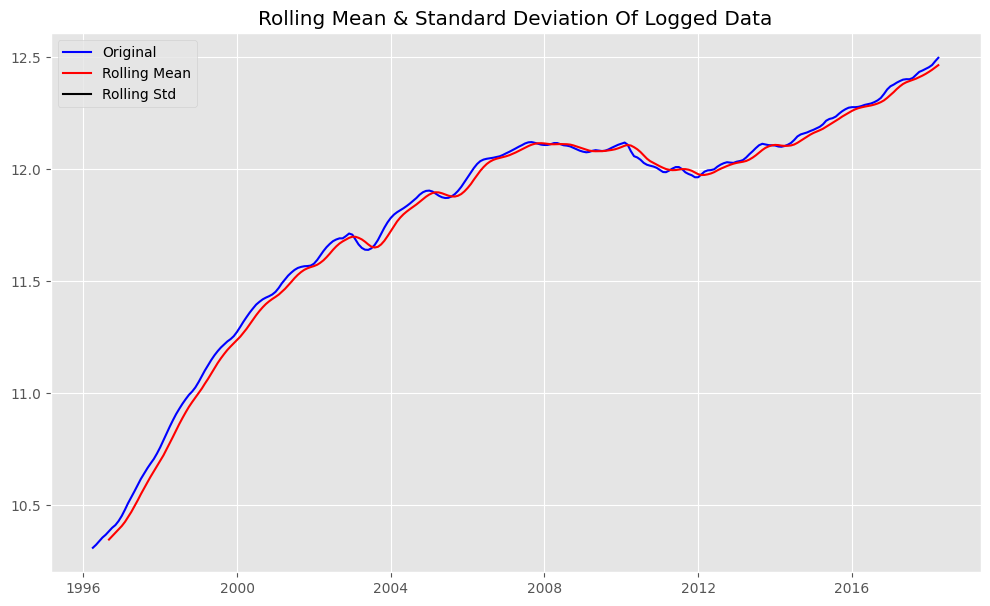

In [47]:
#Examining the rolling mean and std of the log transformed data series
rolmean = data_log.rolling(window = 6, center = False).mean()
rolstd = data_log.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(data_log, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Of Logged Data')
plt.show(block=False)

In [48]:
p_val_log_1 = adfuller(data_log[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_log_1},")
if p_val_log_1 < 0.05:
    print(" so we can safely assume that the logged data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.023716061959590928,
 so we can safely assume that the logged data is stationary.


The p-value associated with the Dickey Fuller test is lower then the .05 confidence interval, therefore using the log transformation the data series is now stationary. The visualization also confirms this conclusion since the range of the price values has been greatly reduced, reducing the data series to white noise. Similarly with differencing the data, a for loop will be used to determine if a different period will lead to a better p-value. 

In [49]:
#Checking period difference for the log transformation
find_best_difference(data_log)

0 nan
1 0.0671671259841669
2 0.27354045146636974
3 0.21132322454530333
4 0.29148779604377606
5 0.2919789888768549
6 0.18970425389444762
7 0.23204068982754084
8 0.12264630347067285
9 0.2113076408318239
10 0.15290683650229114
11 0.1861739510624113
12 0.11118994349813566
13 0.09827910812670182
14 0.17240835343822608
15 0.13069672609641853
16 0.10786301381607705
17 0.11076514168358265
18 0.09793142529851168
19 0.23409551958882485
20 0.1066279228571772
21 0.02928769346331909
22 0.03874040702850562
23 0.11821677146103526
24 0.0903348308504352


None of the iterations of periods decreased the p-value, therefore the original log transformation will be used. So far this mathmatical transformation was the most successful at making the 80499 data series stationary. There is one additional mathematical transformation that will be explored, taking the square root of the data series. 

## Square Root Transforming the 80449 Data Series for Stationarity

Similar to log transformatino, the square root transformation penalizes large numbers and reduces the range of the values in the data series. Since log transformation was successful in creating a stationary data series it seems valuable to explore this similar method of transformation as well. 

In [50]:
#Transforming the 80449 data series by taking the square root of the data
data_sqrt = np.sqrt(series80449)
data_sqrt.head(10)

value
time                  
1996-04-01  173.205081
1996-05-01  174.355958
1996-06-01  175.783958
1996-07-01  177.200451
1996-08-01  178.325545
1996-09-01  179.722008
1996-10-01  181.107703
1996-11-01  182.208672
1996-12-01  183.847763
1997-01-01  186.010752

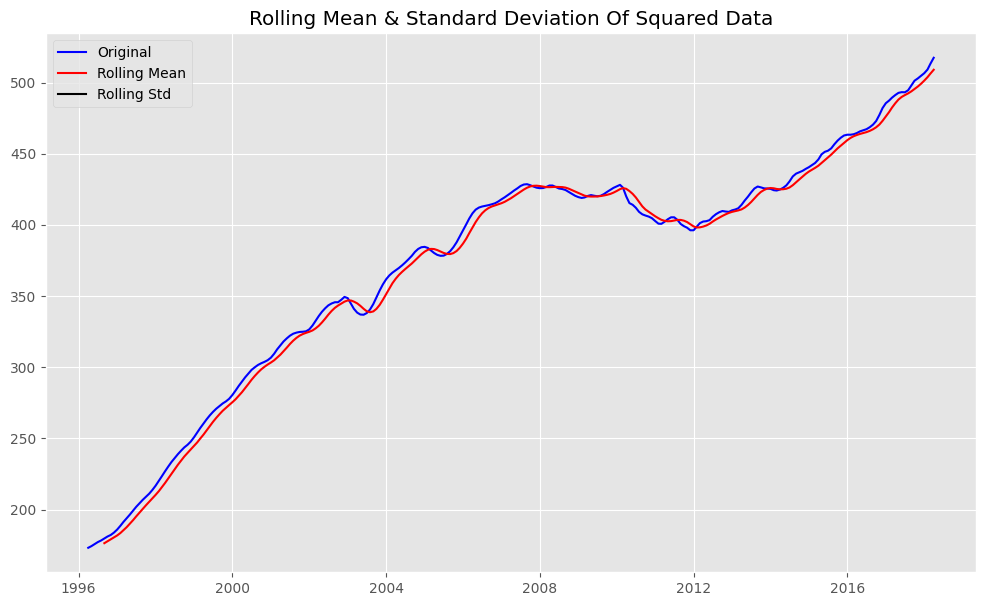

In [51]:
#Examining the rolling mean and std of the squared data series
sqrtmean = data_sqrt.rolling(window = 6, center = False).mean()
sqrtstd = data_sqrt.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(data_sqrt, color='blue',label='Original')
mean = plt.plot(sqrtmean, color='red', label='Rolling Mean')
std = plt.plot(sqrtstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Of Squared Data')
plt.show(block=False)

In [52]:
p_val_sqrt = adfuller(pd.Series(np.sqrt(series80449['value']), index=series80449.index))[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_sqrt},")
if p_val_sqrt < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.458083430949465,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


Unlike the log transformation, taking the square root of the data series was not successful at eliminating trends within the data series. Similar to before, additional periods will be explored to determine if stationarity can be acheived. 

In [53]:
#Checking period difference for the log transformation
find_best_difference(data_sqrt)

0 nan
1 0.013159652583750344
2 0.2794861459026525
3 0.1815884681880906
4 0.29839190758034806
5 0.41324674566816705
6 0.42889182484476013
7 0.46458158084425444
8 0.47156329604538305
9 0.6245063753202225
10 0.46336725578461363
11 0.5442289778607867
12 0.467542471672076
13 0.5093491548387015
14 0.5609242311939566
15 0.38782067354636257
16 0.4701138014199034
17 0.588058907937822
18 0.5245741995735841
19 0.574085882996558
20 0.370729964471871
21 0.1548981608625205
22 0.19104828862617285
23 0.09974712169812516
24 0.14940476425322985


It does seem that when the period is one the p-value associated with the Dickey Fuller test is below the .05 confidence interval. This could potentially be used as a transformation to prepare the data series for modeling. 

## Picking A Mathematical Transformation for Stationarity

Based on the p-value associated with the Dickey Fuller Test, the mathematical transformation that was successful at transforming the data series into a stationary one was logging the data series and taking the square root of the data series in one period. For ease of transformation, logging the data series will be used to make the data series stationary for model building, fitting, and evaluating. 

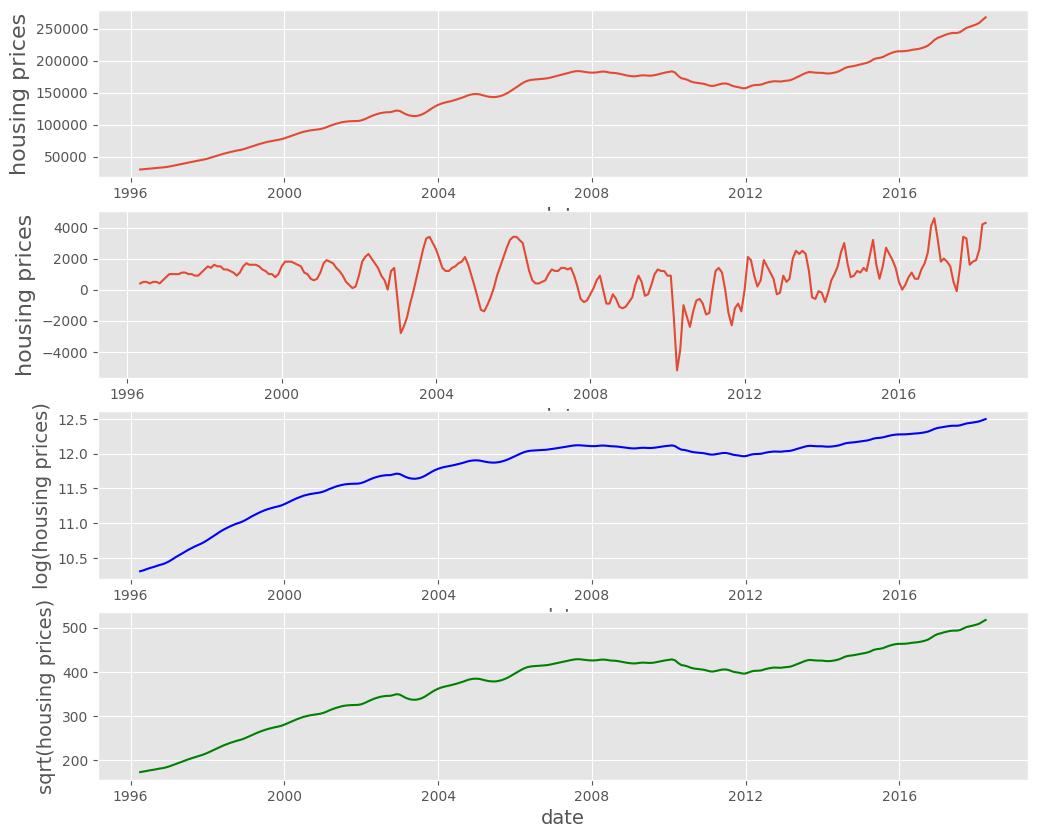

In [54]:
#Visualizations for  Original Data Series and Three Mathematical Transformations
fig = plt.figure(figsize=(12,10))

# No transformation
plt.subplot(4, 1, 1)
plt.plot(series80449)
plt.xlabel("date", fontsize=16)
plt.ylabel("housing prices", fontsize=16)

#Differencing
plt.subplot(4, 1, 2)
plt.plot(data_diff)
plt.xlabel('data', fontsize=16)
plt.ylabel("housing prices", fontsize=16)

# Log transformation (linear and heteroscedastic)
plt.subplot(4, 1, 3)
plt.plot(pd.Series(np.log(series80449['value']), index=series80449.index), color="blue")
plt.xlabel("date", fontsize=14)
plt.ylabel("log(housing prices)", fontsize=14)

# Square root transformation 
plt.subplot(4, 1, 4)
plt.plot(pd.Series(np.sqrt(series80449['value']), index=series80449.index), color="green")
plt.xlabel("date", fontsize=14)
plt.ylabel("sqrt(housing prices)", fontsize=14)


plt.show()

## Seasonal Decomposition

In the 80449 dataset, there is more of a trend then seasonality. Seasonality would be patterns within the year cycle and visually the data seems to be mostly following a positive linear trend. However, for exploration, decomposition will be explored as a way to mitigate seasonality within the dataset. 

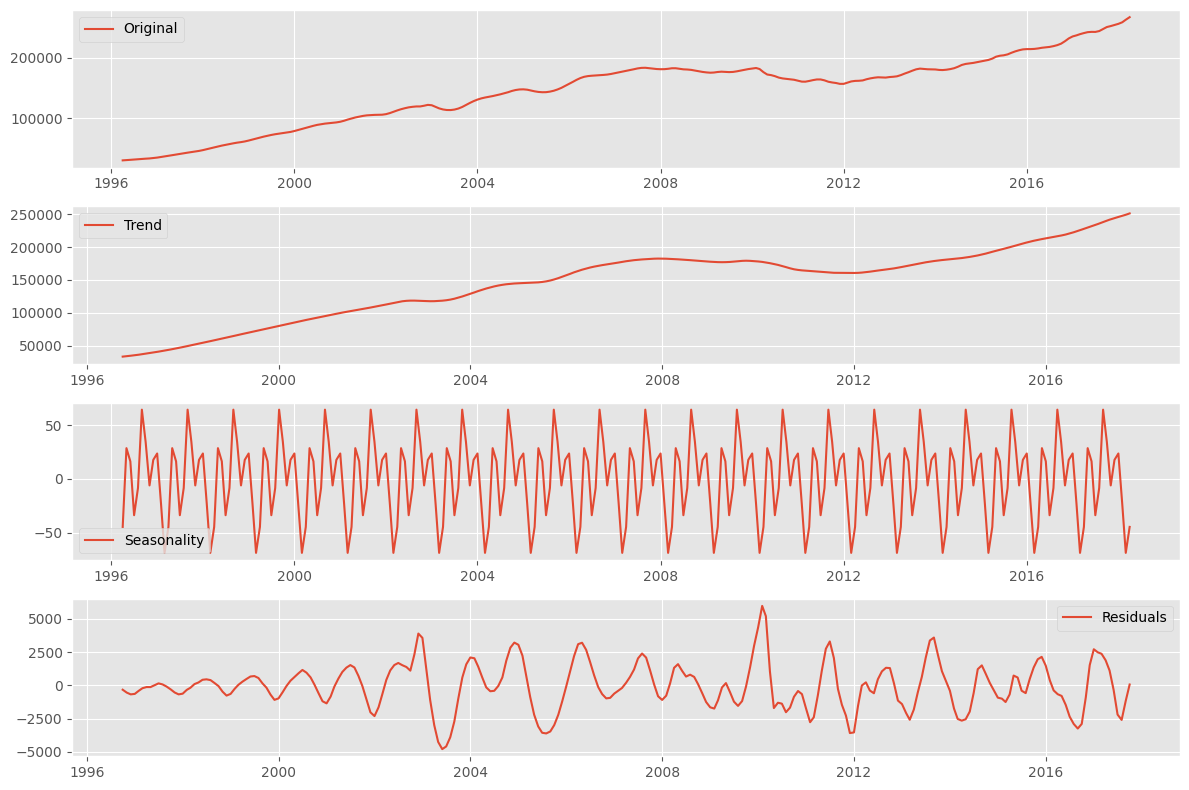

In [55]:
# Import and apply seasonal_decompose()
decomposition = seasonal_decompose(series80449)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(series80449, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout();

In these visualizations the trend and seasonality have been seperated from the data and the residuals can be modeled. By using the time series decomposition, it makes it easier to quickly identify changing mean or variation. The plot above shows the upward trend of the data series. 

In [56]:
# Drop missing values from residuals 
series80449_residuals = residual
series80449_residuals.dropna(inplace=True)

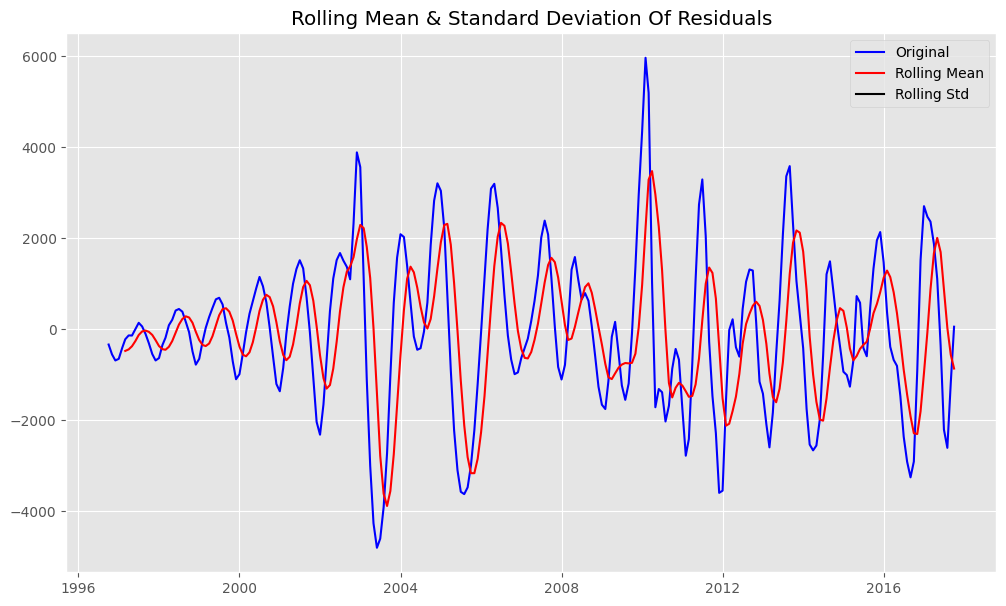

In [57]:
#Visualization of the Residuals of the 80449 data series
rolmean = series80449_residuals.rolling(window = 6, center = False).mean()
rolstd = series80449_residuals.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(series80449_residuals, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Of Residuals')
plt.show(block=False)

In [58]:
p_val_resid = adfuller(series80449_residuals[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_resid},")
if p_val_resid < 0.05:
    print(" so we can safely assume that the residual data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the residual data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 1.3053244075274661e-07,
 so we can safely assume that the residual data is stationary.


The Dickey-Fuller test statistic is significant and very well below the the .05 mark. Therefore it seems reasonable to assume this time series is stationary.

# ACF and PACF Plots

As a last step before beginning on model building exploration of the ACF and PACF plots of both the Original Data Series, the Log Transformation, and the Residuals. The autocorrelation analysis helps detect patterns and check for randomness. It is also helpful for determining the model order for p for AR and Q for MA to select the best model for forecasting. 

## Original Data Series ACF & PACF Plots

A precondition of ACT and PACF is staionarity. Since it has already been establish that the 80449 data series is not stationary the information that can gained from the ACF and PACF plots is limited. 

<Figure size 1200x500 with 0 Axes>

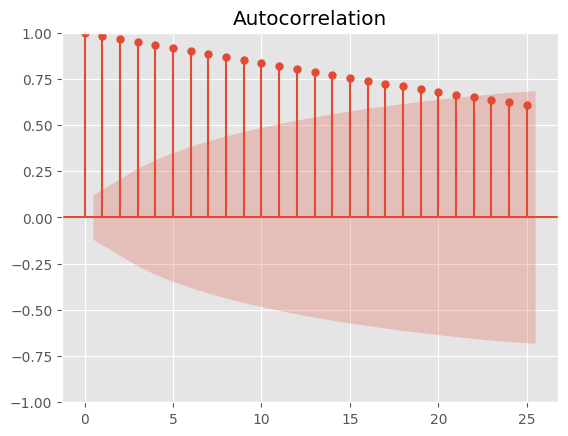

In [59]:
#ACF plot of original 80449 series
plt.figure(figsize=(12,5))
plot_acf(series80449);

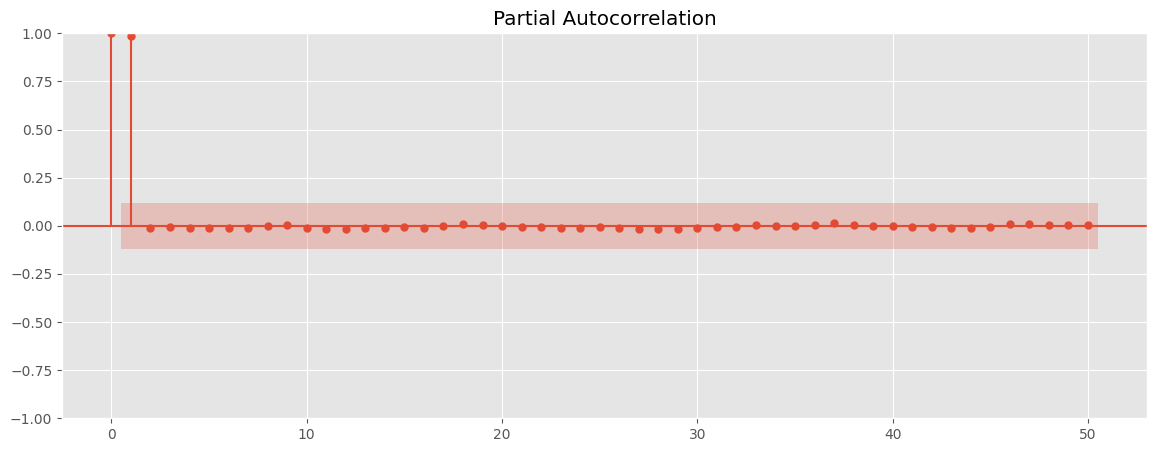

In [60]:
#PACF plot of original 80449 series
rcParams['figure.figsize'] = 14, 5

plot_pacf(series80449, lags=50);

For the ACF plot there is a tail off pattern and there are several autocorrelations that are significantly non zero. Therefore the time series is non random. The PACF plot shows geometric decay. However, as was previously mentioned, the original 80449 data series is not stationary. 

## Logged Data Series ACF & PACF Plots

<Figure size 1200x500 with 0 Axes>

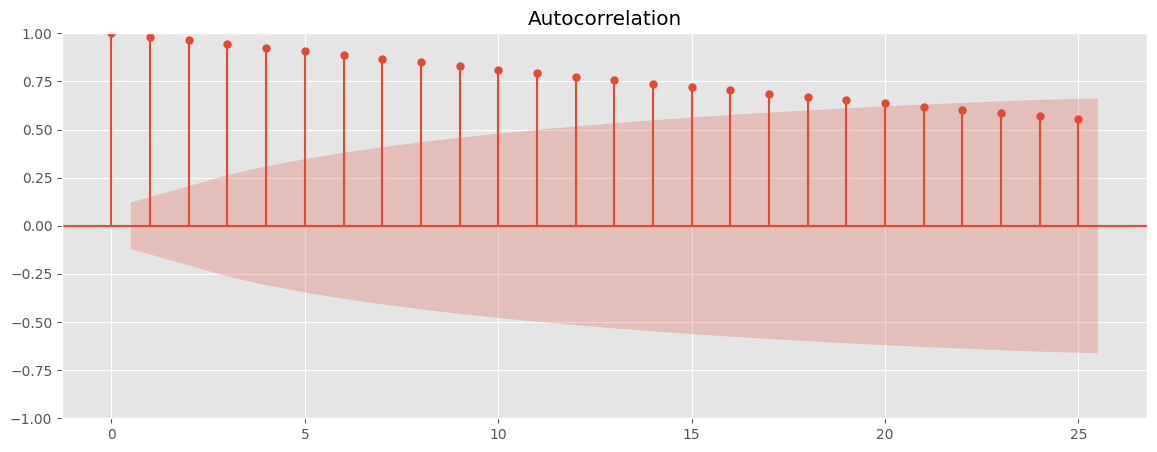

In [61]:
#ACF plot of logged 80449 series
plt.figure(figsize=(12,5))
plot_acf(np.log(series80449));

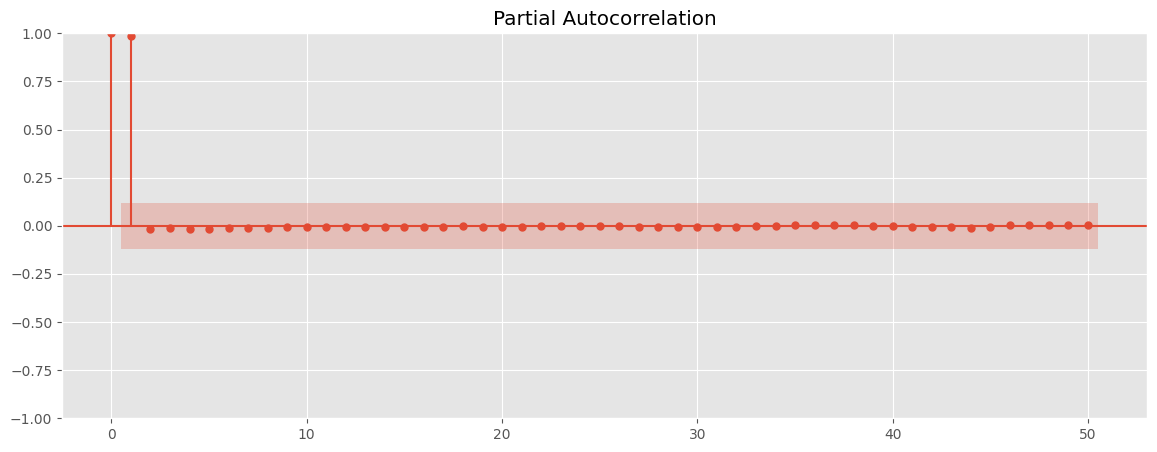

In [62]:
#PACF plot of logged 80449 series
rcParams['figure.figsize'] = 14, 5

plot_pacf(np.log(series80449), lags=50);

Now with a stationary version of the 80449 data series, both plots seem similar to before. For the ACF plot there is a tail off pattern and there are several autocorrelations that are significantly non zero. Therefore the time series is non random. The PACF plot shows geometric decay. As a result, a MA(20) model would be appropriate for this data series. 

## Residuals of Data Series ACF & PACF Plots

<Figure size 1200x500 with 0 Axes>

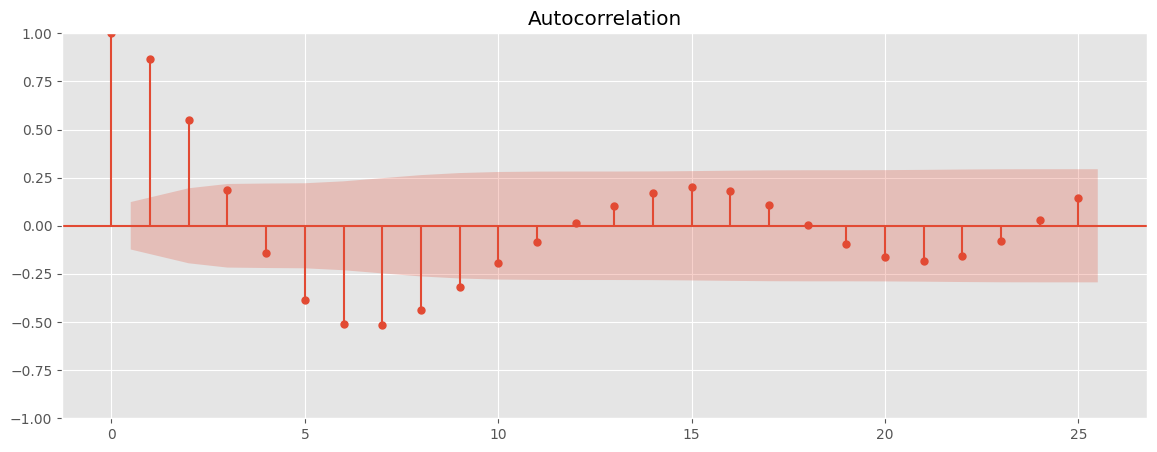

In [63]:
#ACF plot of residuals 80449 series
plt.figure(figsize=(12,5))
plot_acf(series80449_residuals);

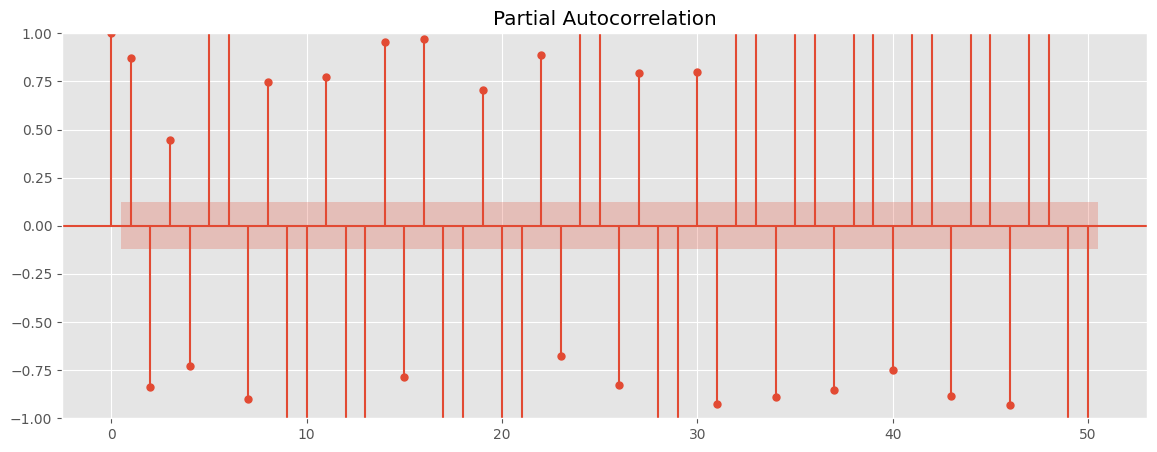

In [64]:
#PACF plot of residuals 80449 series
rcParams['figure.figsize'] = 14, 5

plot_pacf(series80449_residuals, lags=50);

In contrast to before, the PACF & ACF plots of the residuals of the data series look very different. There are several auotcorrelations that are significantly non zero. Therefore the time series is non random. There is a high degree of correlation between adjacent and near adjacent observations in PACF plot. Therefore a AR(3) would be an appropriate model. 

# Model Building

In order to determine which time series model is appropriate for the data series, four models will be built. Once built, the most accurate time series model will be selected to fine tune and make predictions for final recommendations. The RMSE score will be used as a determinate of which model is the most accurate. The reason the RMSE will be used is that, as an expression of how closely the data points are around the line of best fit, the highest RMSE score shows the most accurate prediction and limits the amount of unpredicted values. This is important since the client wants to as accurately as possible predict future ROI on investment. 

## Splitting the Data into Train and Test

In order to evaluate the accuracy of the predictions generated by the models, a train test split will be utilized. Because chronological order matters, a portion of the data series will be cut off at the end, and reserved as the test set. For Time Series Data it is better that the split is more weighted towards the train data because of interdependence. Therefore a split of 80% train and 20% test will be utilized. 

In [65]:
# find the index to split off 20% of the data
cutoff = round(series80449.shape[0]*0.8)
cutoff

212

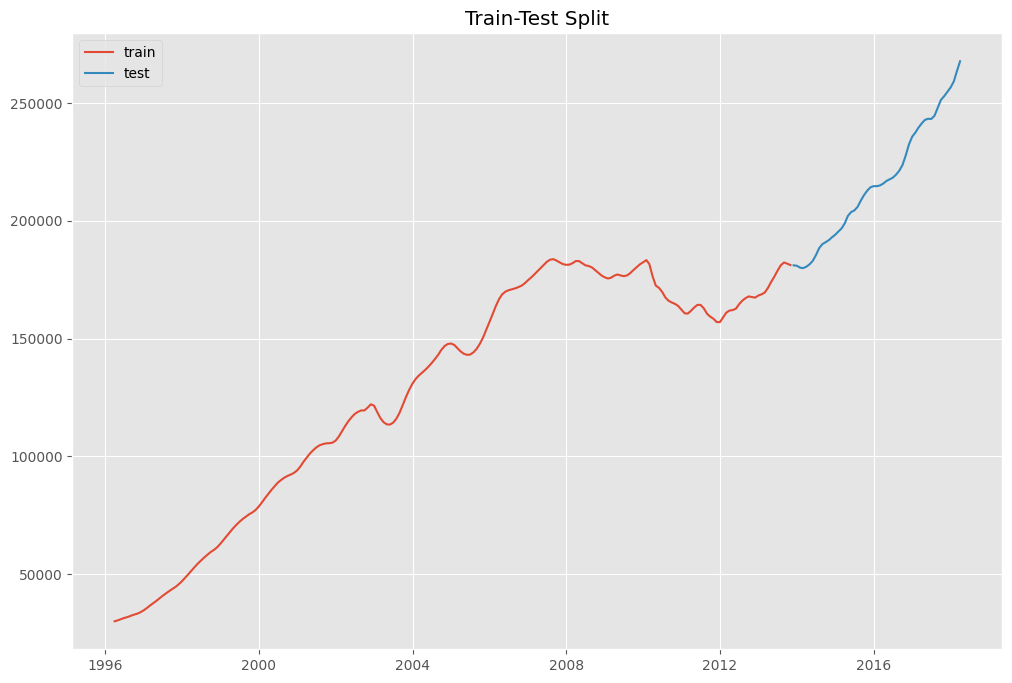

In [66]:
# Define train and test sets according to the index found above
train = series80449[:cutoff]

test = series80449[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [67]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 1

An important observation about the train test split in the data series is that the extreme event of the 2008 recession is included in the train data series. This extreme outlier event might prove challenging for building and fine tuning models. 

## Establishing A Baseline Naive Model

In order to establish the relative success of additional model, a baseline naive model will be built and evaluated. The original series will be shifted to the future by one month and then used as the prediction for the test data series. 

In [68]:
# The prediction for the next day is the original series shifted to the future by one month.
naive = train.shift(1)
naive

value
time                
1996-04-01       NaN
1996-05-01   30000.0
1996-06-01   30400.0
1996-07-01   30900.0
1996-08-01   31400.0
...              ...
2013-07-01  176300.0
2013-08-01  178800.0
2013-09-01  181100.0
2013-10-01  182300.0
2013-11-01  181800.0

[212 rows x 1 columns]

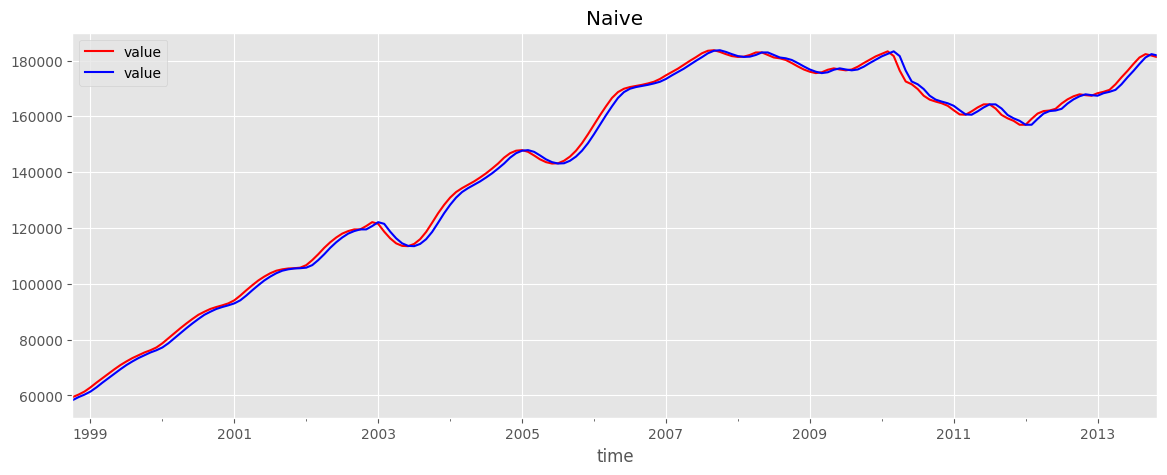

In [69]:
#plot of the one month shift 
fig, ax = plt.subplots()

train[30:].plot(ax=ax, c='r', label='original')
naive[30:].plot(ax=ax, c='b', label='shifted')
ax.set_title('Naive')
ax.legend();

In order to compare the baseline to later models, the RMSE will be calculated.

In [70]:
#Isolating next month prediction
naive_pred = naive.iloc[-1]
print(naive_pred)

value    181800.0
Name: 2013-11-01 00:00:00, dtype: float64


In [71]:
#Creating new prediction dataset with shifted prediction
naive_df = test.copy()
naive_df['value'] = naive_pred['value']

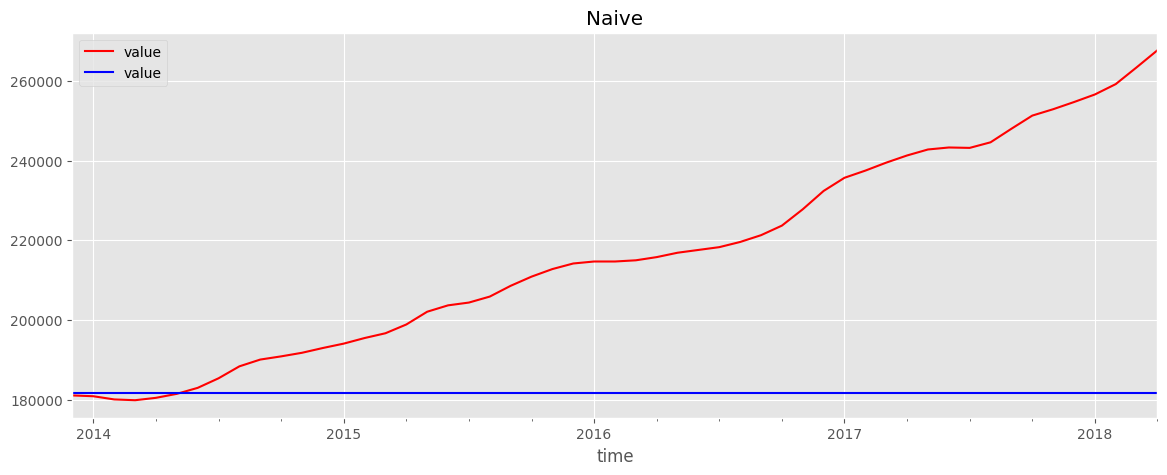

In [72]:
#Plotting naive baseline prediction against test data series
fig, ax = plt.subplots()

test.plot(ax=ax, c='r', label='original')
naive_df.plot(ax=ax, c='b', label='shifted')
ax.set_title('Naive')
ax.legend();

In [73]:
#calculating base RMSE
base_rmse = np.sqrt(mean_squared_error(test, naive_df))
print(base_rmse)

42967.06724835346


All subsequent models will be evaluated against this base RMSE. 

# AUTO ARIMA MODEL

Auto ARIMA is a popular forecasting model used in time series analysis. It is an algorithm that automatically selects the optimal parameters for an ARIMA model based on the provided dataset, making it a powerful tool for time series modeling.

The ARIMA model combines three components: autoregressive (AR), differencing (I), and moving average (MA). The AR component captures the linear relationship between an observation and a lagged version of itself, while the MA component considers the linear relationship between an observation and the residual errors from a moving average model applied to lagged observations. The differencing component helps to stabilize and stationarize the time series data.

By using Auto ARIMA for the 80449 data series, it will eliminates the need for manual trial and error in selecting optimal parameters, saving time and effort. It also provides a systematic and objective approach to model selection, improving the accuracy of forecast and handles seasonality in the data.


## Fitting an AUTO-ARIMA Model on our Training Series


For time series modeling a stationary dataset is usually required to create an accurate prediction model. However, by utilizing an AUTO-ARIMA model, the model itself will generate the optimal values to eliminate stationarity and create predictions. As a result the AUTO-ARIMA model will be built using the original data series from the 80449 zipcode. 

In [74]:
# Creating and Fitting an AUTO ARIMA model to the train dataset
import pmdarima as pm

auto_model = pm.auto_arima(train,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3271.014, Time=0.91 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3337.315, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3316.072, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3291.124, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3269.592, Time=0.59 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3290.454, Time=0.42 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3291.532, Time=0.40 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3270.824, Time=0.98 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=3282.339, Time=0.42 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3286.798, Time=0.18 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=3266.534, Time=1.87 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=3265.016, Time=0.74 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=3272.341, Time=0.52 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=3265.325, Time=0.84 sec
 ARIMA(3,2,4)(0,0,0)[0]          

The auto arima model has run through several different parameters in order to pick the order values and season order values that minimize the AIC value of the model for the data series. These values will be extracted from the AUTO ARIMA and then used to train a SARIMAX model for predictions and RMSE evaluation. 

In [75]:
#Identifying the order values for the model
auto_model.order

(4, 2, 4)

In [76]:
#Identifying the Seasonal Order values for the model
auto_model.seasonal_order

(0, 0, 0, 0)

## Using Optimal Parameters to Build a SARIMAX Model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6642      0.387      1.718      0.086      -0.094       1.422
ar.L2          0.1339      0.130      1.033      0.301      -0.120       0.388
ar.L3          0.0875      0.126      0.695      0.487      -0.159       0.334
ar.L4         -0.1985      0.086     -2.312      0.021      -0.367      -0.030
ma.L1          0.0596      0.394      0.151      0.880      -0.712       0.832
ma.L2         -0.9767      0.241     -4.047      0.000      -1.450      -0.504
ma.L3         -0.4658      0.272     -1.715      0.086      -0.998       0.067
ma.L4          0.4403      0.320      1.377      0.169      -0.186       1.067
sigma2      2.283e+05   1.29e+04     17.743      0.000    2.03e+05    2.54e+05


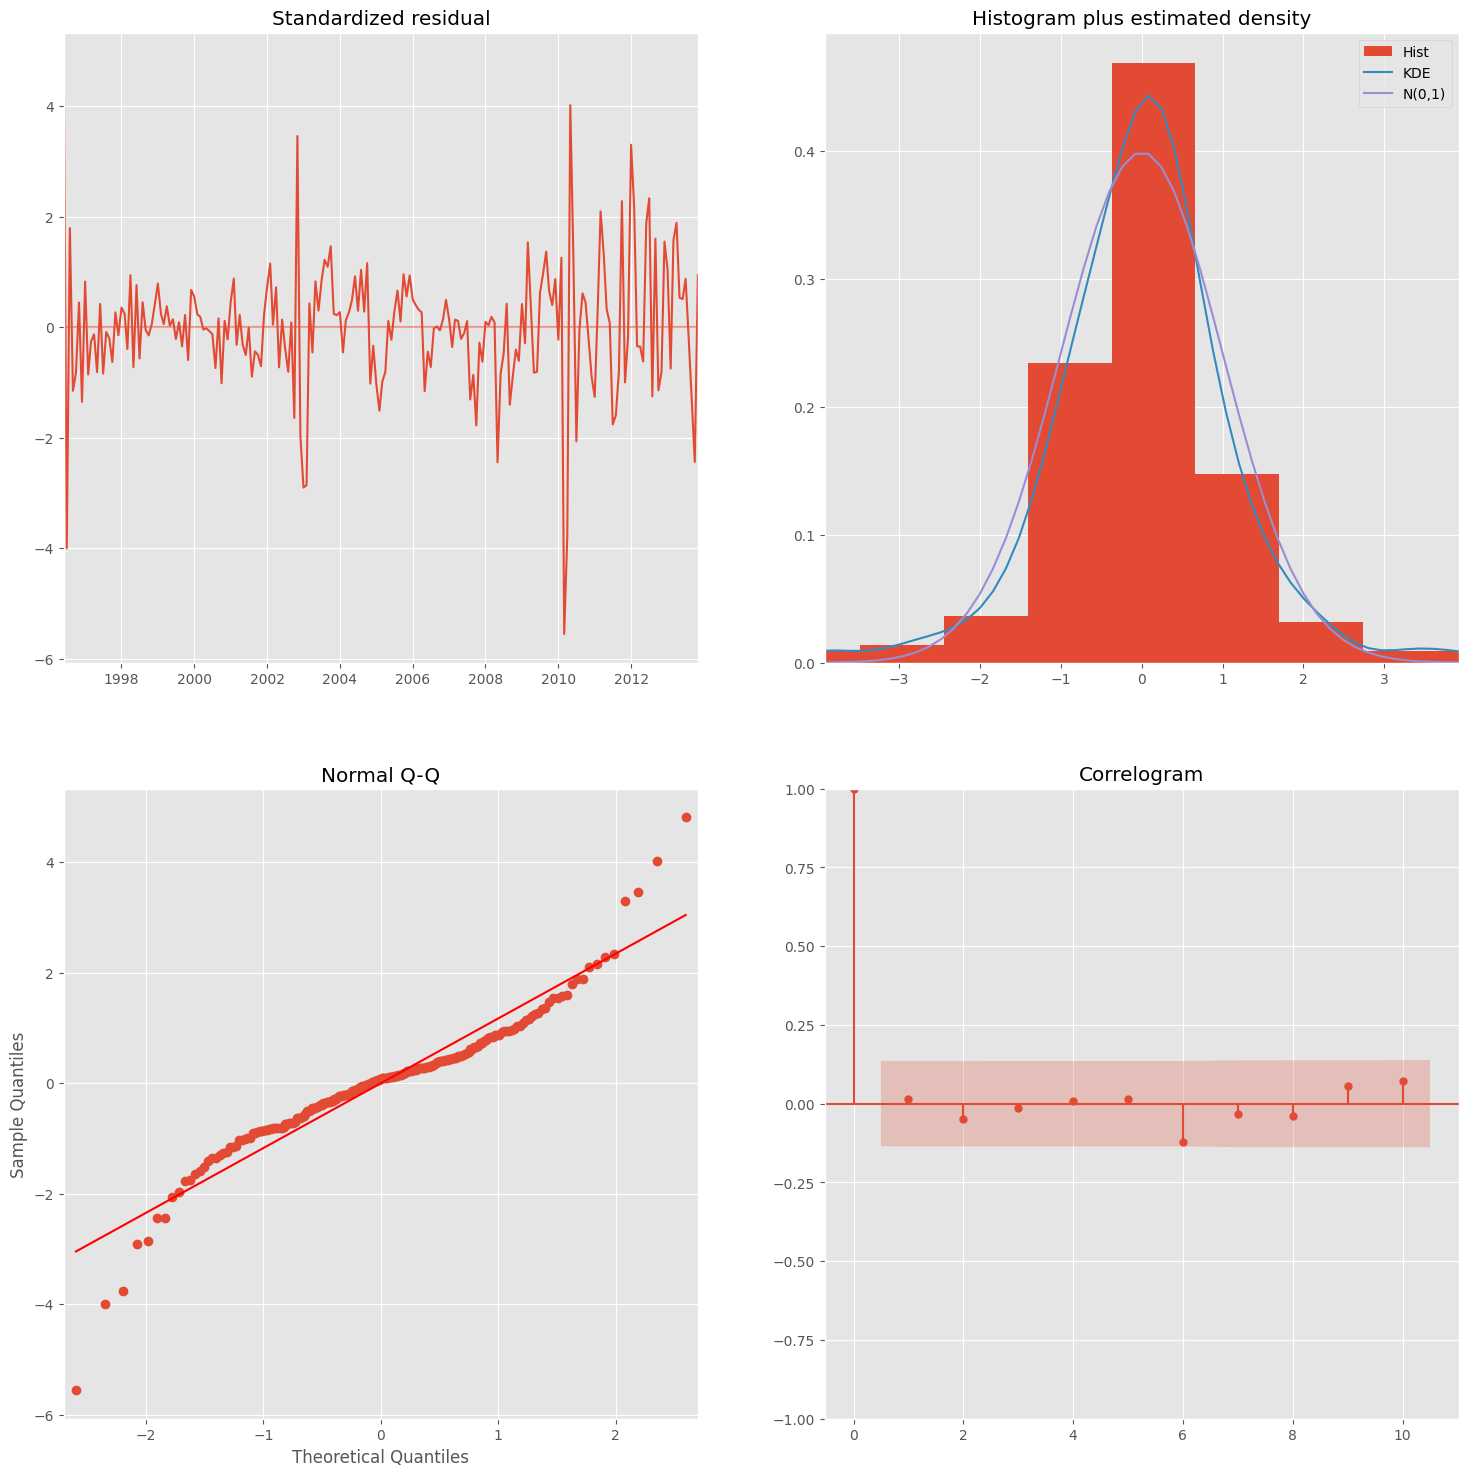

In [77]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(4,2,4), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

It is important to confirm that the residuals are not correlated and that they are normally distributed. Otherwise, additional changes will need to be made to the model. 

Checking each of the diagnostic plots:

- In the plot on the top right, the KDE line somewhat closely follows along the N(0,1) line which is the standard notation for a normal distribution having a mean of 0 and a standard deviation of 1. As a result, this can be interpreted to mean that the residuals are normally distributed. 

- The qq-plot shown on the bottom left displays that the residuals follow the linear trend line. As a result, it can also be interpreted to mean that the residuals are normally distributed. 

- From the Correlogram plot on the bottom left, it can be seen that the time series residuals displace low correlation with their lagged versions. This becomes clearer as the time series continues further along. This seems to indicate that there isn't any obvious seasonality in our series. 

Based on these observations, it can be confidently concluded that the model does not have correlations and that it satisfactorily fits the data to forecast future prices. 

In [78]:
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  212
Model:               SARIMAX(4, 2, 4)   Log Likelihood               -1556.942
Date:                Sat, 10 Jun 2023   AIC                           3131.883
Time:                        22:05:59   BIC                           3161.790
Sample:                    04-01-1996   HQIC                          3143.980
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6642      0.387      1.718      0.086      -0.094       1.422
ar.L2          0.1339      0.130      1.033      0.301      -0.120       0.388
ar.L3          0.0875      0.126      0.695      0.487      -0.159       0.334
ar.L4         -0.1985      0.086     -2.312      0.021      -0.367      -0.030
ma.L1          0.0596      0.394      0.151      0.880      -0.712       0.832
ma.L2         -0.9767      0.241     -4.047      0.000      -1.450      -0.504
ma.L3         -0.4658      0.272     -1.715      0.086      -0.998       0.067
ma.L4          0.4403      0.320      1.377      0.169      -0.186       1.067
sigma2      2.283e+05   1.29e+04     17.743      0.000    2.03e+05    2.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               397.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               9.08   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluating the SARIMAX Model Performance

In order to test the accuracy of the model, the predictions for the period between May 2013 and April 2018 will be retrieved. The predictions will be plotted on the same chart to provide a visualization of how far and/or close the predictions are to the test values. Then RMSE will be used to evaluate the model's performance compared to the baseline. 

In [79]:
# Getting predictions starting from 12-2013 and calculating confidence intervals
pred_arima = output.get_prediction(start=pd.to_datetime('2013-12'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_arima = pred_arima.conf_int()

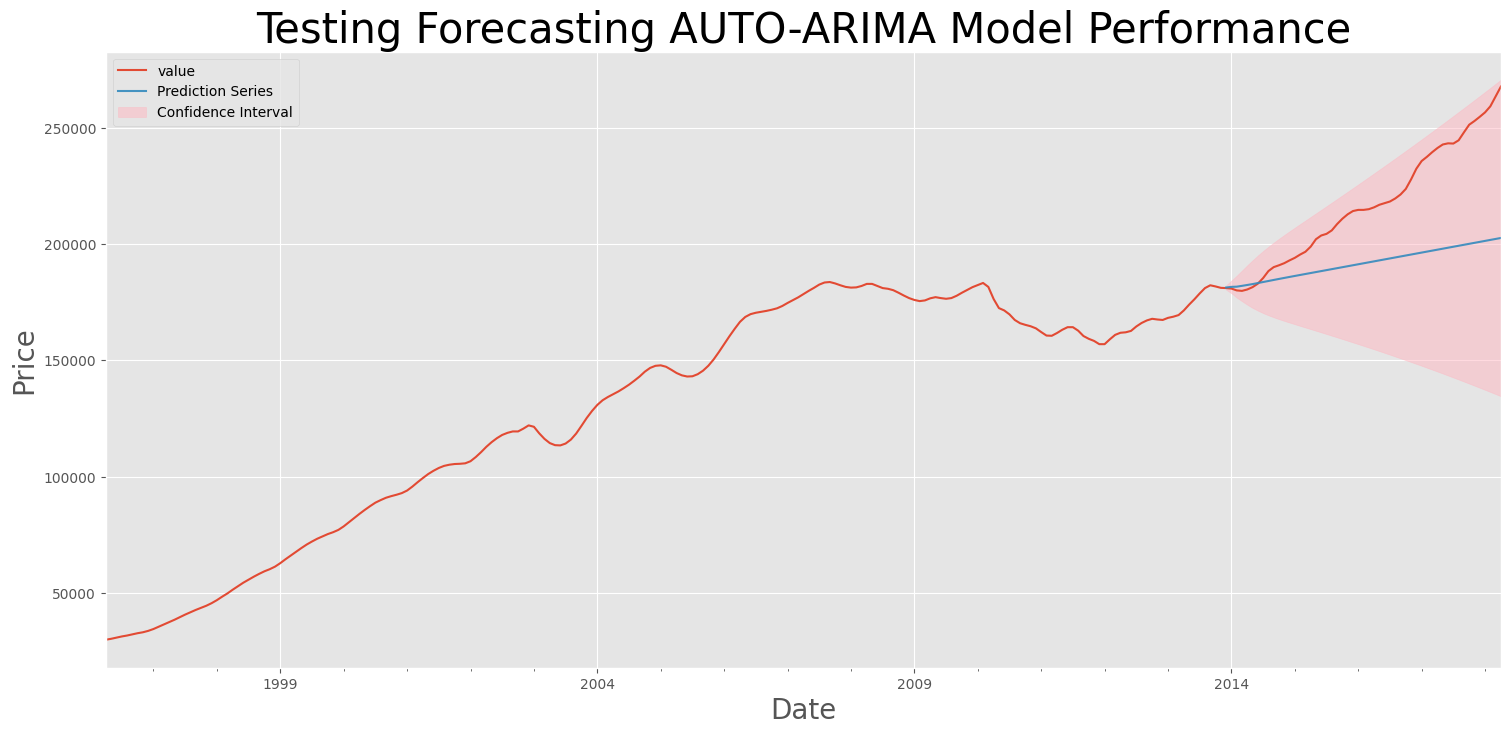

In [80]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = series80449.plot(label='observed')

# Plot predicted values
pred_arima.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_arima.index,
                pred_conf_arima.iloc[:, 0],
                pred_conf_arima.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting AUTO-ARIMA Model Performance',fontsize=30)
plt.legend()

plt.show()

In [81]:
# Get the real and predicted values
price_forecasted = pred_arima.predicted_mean
price_truth = series80449['2013-12-01':]

# Compute the RMSE for the SARIMAX model performance
arima_rmse = np.sqrt(mean_squared_error(price_forecasted, price_truth))
print(arima_rmse)

31204.69249024491


In [82]:
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
if arima_rmse < base_rmse:
    print("Based on RMSE value the AUTO ARIMA model has outperformed the Baseline Model")
else:
    print(f"Based on RMSE value the AUTO ARIMA model has been outperformed by the Baseline Model with a RMSE of {base_rmse}")

The RMSE value associated with the AUTO ARIMA model is 31204.69249024491.
Based on RMSE value the AUTO ARIMA model has outperformed the Baseline Model


The SARIMAX tuned with the AUTO ARIMA has outperformed the baseline RMSE score. However, an RMSE score of 31,204 dollars is significant when all properties are under 300,000 dollars. It seems that the extreme event might be having an outsized effect on the predictions of the model and causing the predictions to underestimate the test values. A more sophisticaed model may be needed to compensate for this extreme outlier event. 

# Facebook Prophet Model

Facebook Prophet is a time series forecasting model developed by Facebook's Core Data Science team. It is designed to provide accurate predictions for univariate time series data, which consists of observations recorded at regular intervals over time. The model is particularly useful for forecasting tasks where historical patterns and seasonality play a significant role. For the 80449 data series, it's ability to accomodate a wide range of real world scenarios will hopefully make it successful in accounting for the extreme events. 

## Fitting Facebook Prophet Model on the Training Series¶

Facebook Prophet Model requires the data series to be formatted in a specific way for the model to process. Facebook Prophet model also assumes stationarity in the data series, so this pre-processing will need to be implemented as well. 

In [83]:
#Examining the format of the train data series
train

value
time                
1996-04-01   30000.0
1996-05-01   30400.0
1996-06-01   30900.0
1996-07-01   31400.0
1996-08-01   31800.0
...              ...
2013-07-01  178800.0
2013-08-01  181100.0
2013-09-01  182300.0
2013-10-01  181800.0
2013-11-01  181200.0

[212 rows x 1 columns]

In [84]:
#Taking the log of the 80449 data series for stationarity
fb_train = pd.Series(np.log(train['value']), index=train.index)
fb_train = fb_train.reset_index()

In [85]:
#examining transformed data series
fb_train

time      value
0   1996-04-01  10.308953
1   1996-05-01  10.322198
2   1996-06-01  10.338511
3   1996-07-01  10.354563
4   1996-08-01  10.367222
..         ...        ...
207 2013-07-01  12.094023
208 2013-08-01  12.106805
209 2013-09-01  12.113409
210 2013-10-01  12.110662
211 2013-11-01  12.107357

[212 rows x 2 columns]

In [86]:
#Formatting column names for Facebook Prophet Model
fb_train = fb_train.rename(columns={'value': 'y', 'time': 'ds'})
fb_train.head(5)

ds          y
0 1996-04-01  10.308953
1 1996-05-01  10.322198
2 1996-06-01  10.338511
3 1996-07-01  10.354563
4 1996-08-01  10.367222

In [87]:
#Building and Fitting Facebook Prophet Model on train data series
FB_Model = Prophet()

FB_Model.fit(fb_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/zwctvt69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/b8rvunh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74018', 'data', 'file=/tmp/tmp4yyjkats/zwctvt69.json', 'init=/tmp/tmp4yyjkats/b8rvunh_.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model16lurkcd/prophet_model-20230610220600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [88]:
#Creating a df with the dates for predictions
fb_future_dates = FB_Model.make_future_dataframe(periods=53, freq='MS')
fb_future_dates.tail()

ds
260 2017-12-01
261 2018-01-01
262 2018-02-01
263 2018-03-01
264 2018-04-01

In [89]:
#Filling in df with predictions from FB Prophet Model
fb_forecast = FB_Model.predict(fb_future_dates)
fb_forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1996-04-01  10.292246   10.268180   10.323036    10.292246    10.292246   
1 1996-05-01  10.309754   10.285767   10.343263    10.309754    10.309754   
2 1996-06-01  10.327846   10.302188   10.361990    10.327846    10.327846   
3 1996-07-01  10.345355   10.321116   10.378153    10.345355    10.345355   
4 1996-08-01  10.363447   10.338484   10.395366    10.363447    10.363447   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.003371              0.003371              0.003371  0.003371   
1        0.004248              0.004248              0.004248  0.004248   
2        0.003787              0.003787              0.003787  0.003787   
3        0.003942              0.003942              0.003942  0.003942   
4        0.003801              0.003801              0.003801  0.003801   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.003371      0.003371                   0.0   
1      0.004248      0.004248                   0.0   
2      0.003787      0.003787                   0.0   
3      0.003942      0.003942                   0.0   
4      0.003801      0.003801                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  10.295617  
1                         0.0                         0.0  10.314002  
2                         0.0                         0.0  10.331633  
3                         0.0                         0.0  10.349297  
4                         0.0                         0.0  10.367248

In [90]:
#Isolating columns with relevant info for evaluation
fb_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
260 2017-12-01  12.072566   11.492533   12.614281
261 2018-01-01  12.073967   11.484575   12.628614
262 2018-02-01  12.076418   11.475132   12.653865
263 2018-03-01  12.079968   11.449345   12.680144
264 2018-04-01  12.080966   11.441998   12.699282

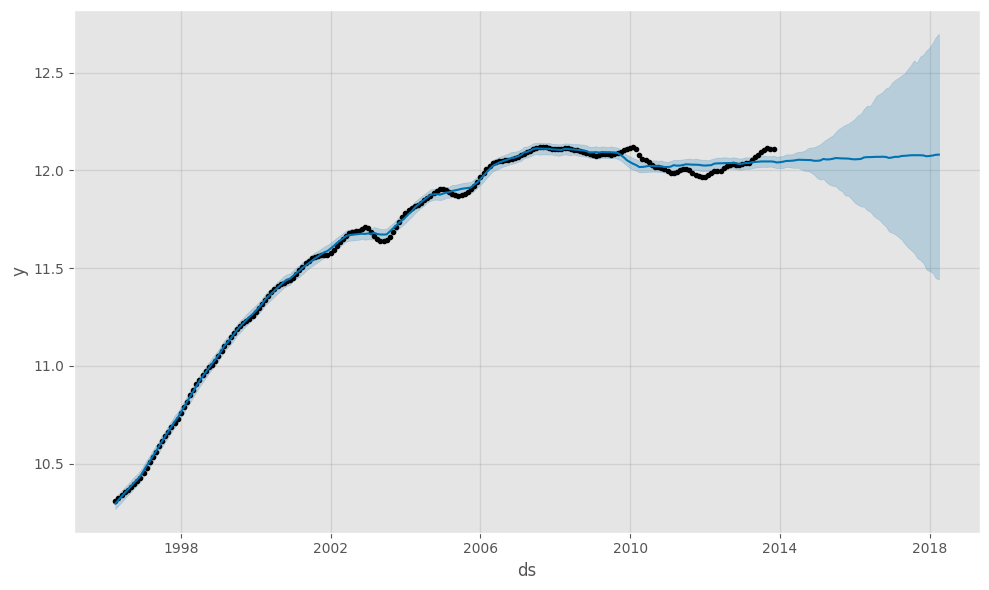

In [91]:
#Visualization of predicted values and uncertainty intervals
FB_Model.plot(fb_forecast)
plt.show();

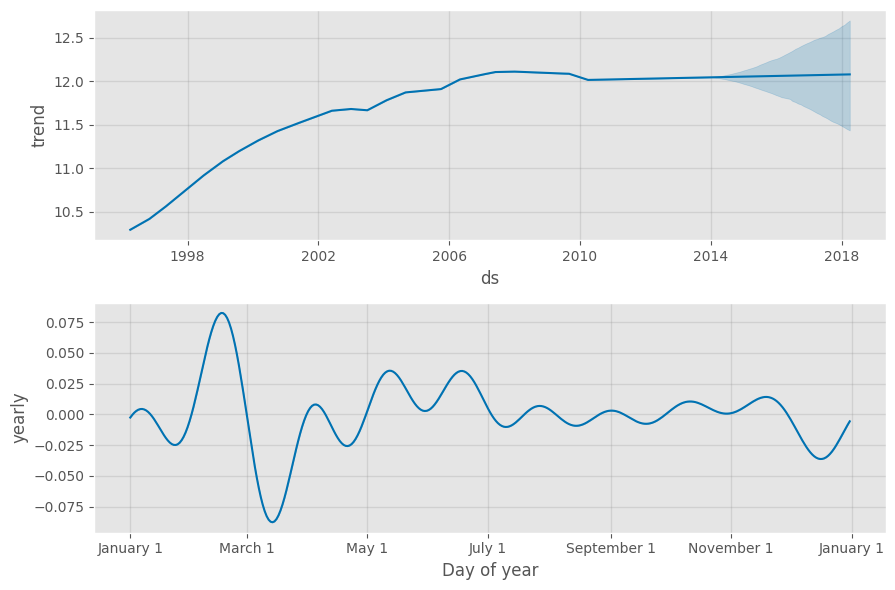

In [92]:
#Plotting Model Components
FB_Model.plot_components(fb_forecast)
plt.show();

From the visualizations, it can be seen that the trend of the data series is leading to a level prediction. This is unlikely to be a very accurate prediction since in the test data there is a continuation of linear growth after the steep increase and decrease of the recession. The seasonality shows some interesting fluctuations in the beginning of the year that seems to stablize as the year continues. 

## Evaluating the Facebook Prophet Model

As has been done previously with the baseline and the SARMIX model, RMSE will be used to evaluate the success of the Facebook Prophet model. 

In [93]:
#examining the FB forecast df
fb_forecast[212:]

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
212 2013-12-01  12.044627   12.012109   12.070193    12.044627    12.044627   
213 2014-01-01  12.045302   12.012892   12.071769    12.044699    12.045359   
214 2014-02-01  12.045977   12.011531   12.073650    12.042806    12.048356   
215 2014-03-01  12.046587   12.018446   12.082311    12.039614    12.051748   
216 2014-04-01  12.047262   12.016852   12.081911    12.036359    12.057329   
217 2014-05-01  12.047915   12.014209   12.082413    12.030713    12.062428   
218 2014-06-01  12.048590   12.013478   12.090540    12.025512    12.069028   
219 2014-07-01  12.049244   12.013980   12.095732    12.018783    12.075722   
220 2014-08-01  12.049919   12.004227   12.095934    12.011302    12.081408   
221 2014-09-01  12.050594   11.997855   12.101507    12.004989    12.089696   
222 2014-10-01  12.051247   11.998004   12.113470    11.999061    12.097636   
223 2014-11-01  12.051923   11.989620   12.117479    11.990273    12.105429   
224 2014-12-01  12.052576   11.978542   12.118479    11.981521    12.113949   
225 2015-01-01  12.053251   11.960625   12.126484    11.970719    12.124371   
226 2015-02-01  12.053926   11.953641   12.133961    11.961880    12.133434   
227 2015-03-01  12.054536   11.957384   12.147180    11.953354    12.142837   
228 2015-04-01  12.055211   11.939835   12.158986    11.943053    12.151881   
229 2015-05-01  12.055865   11.927054   12.169321    11.931259    12.162608   
230 2015-06-01  12.056540   11.921702   12.178667    11.920713    12.174233   
231 2015-07-01  12.057193   11.918958   12.197594    11.909687    12.189522   
232 2015-08-01  12.057868   11.902039   12.212733    11.898103    12.202423   
233 2015-09-01  12.058544   11.893246   12.222949    11.888327    12.214219   
234 2015-10-01  12.059197   11.872020   12.232865    11.876811    12.228183   
235 2015-11-01  12.059872   11.870698   12.240066    11.866416    12.240392   
236 2015-12-01  12.060525   11.854583   12.250593    11.854220    12.250071   
237 2016-01-01  12.061201   11.834994   12.262889    11.840609    12.258307   
238 2016-02-01  12.061876   11.824535   12.282411    11.829723    12.270858   
239 2016-03-01  12.062507   11.816531   12.289539    11.816519    12.285266   
240 2016-04-01  12.063183   11.814059   12.315181    11.810819    12.302597   
241 2016-05-01  12.063836   11.796992   12.331424    11.803579    12.318163   
242 2016-06-01  12.064511   11.788906   12.330160    11.797393    12.335158   
243 2016-07-01  12.065164   11.769273   12.355603    11.772699    12.351846   
244 2016-08-01  12.065840   11.755851   12.382301    11.761302    12.372377   
245 2016-09-01  12.066515   11.746015   12.391263    11.744276    12.386715   
246 2016-10-01  12.067168   11.728133   12.402318    11.733768    12.404064   
247 2016-11-01  12.067843   11.713096   12.420148    11.715031    12.420136   
248 2016-12-01  12.068497   11.687240   12.425685    11.700783    12.434596   
249 2017-01-01  12.069172   11.681332   12.449870    11.685979    12.447971   
250 2017-02-01  12.069847   11.672614   12.463673    11.669323    12.462877   
251 2017-03-01  12.070457   11.661040   12.473055    11.652752    12.477842   
252 2017-04-01  12.071132   11.647257   12.484760    11.634769    12.486416   
253 2017-05-01  12.071785   11.626747   12.495098    11.620435    12.500410   
254 2017-06-01  12.072461   11.607245   12.517834    11.599849    12.508793   
255 2017-07-01  12.073114   11.593992   12.537233    11.585651    12.521365   
256 2017-08-01  12.073789   11.578926   12.562509    11.567684    12.543285   
257 2017-09-01  12.074464   11.552588   12.551573    11.547408    12.559209   
258 2017-10-01  12.075118   11.542376   12.582823    11.531741    12.575408   
259 2017-11-01  12.075793   11.526683   12.591896    11.520187    12.593991   
260 2017-12-01  12.076446   11.492533   12.614281    11.505523    12.609752   
261 2018-01-01  12.077121   11.484575   12.628614    11.487120

In [94]:
# Getting the real and predicted values
fb_prediction = fb_forecast[212:]
fb_prediction = fb_prediction[['yhat','ds']]
fb_prediction['unlog_value'] = np.exp(fb_prediction['yhat'])

In [95]:
# Compute the mean square error
fb_rmse = np.sqrt(mean_squared_error(test['value'], fb_prediction['unlog_value']))
print(fb_rmse)

49199.202762526045


In [96]:
print(f"The RMSE value associated with the base model is {base_rmse}.")
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
print(f"The RMSE value associated with the Facebook Prophet model is {fb_rmse}.")

The RMSE value associated with the base model is 42967.06724835346.
The RMSE value associated with the AUTO ARIMA model is 31204.69249024491.
The RMSE value associated with the Facebook Prophet model is 49199.202762526045.


According the RMSE evaluation, the Facebook Prophet is performing even more poorly then the baseline model. In order to try improving the performance of the Facebook prophet, tuning certain aspects of the Facebook model will be implemented. 

## Tuning the Facebook Prophet Model

It can be seen from the large RMSE score that there is huge gap in prediction and the true values of the test data series. Therefore it is needed to optimize the Facebook Prophet model by adding other parameters like holidays, changepoints etc.

## Importing Holidays into the Facebook Model

The Facebook Prophet model allows holidays to be included in the modeling forecast in order to take the effect of holidays into account. In order to try increasing accuracy of predictions, holidays will be incorporated into the new tuned Facebook Prophet Model. 

In [97]:
#List of years included in the data series
year_list = [1996, 1997,1998,1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 
            2013, 2014, 2015, 2016, 2017, 2018]

In [98]:
#creating a df of holidays for each year
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=year_list).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [99]:
#examining the df of holidays
holiday.head()

ds      holiday
0 1996-01-01  US-Holidays
1 1996-01-15  US-Holidays
2 1996-02-19  US-Holidays
3 1996-05-27  US-Holidays
4 1996-07-04  US-Holidays

In [100]:
#Building FB Prophet model with holidays
fb_model_with_holidays = Prophet(holidays=holiday)
fb_model_with_holidays.fit(fb_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3usf4dr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/if_9dbyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98757', 'data', 'file=/tmp/tmp4yyjkats/3usf4dr8.json', 'init=/tmp/tmp4yyjkats/if_9dbyq.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelcn1xgytl/prophet_model-20230610220601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [101]:
#Forecasting predictions with holidays
future_with_holidays = fb_model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast_with_holidays = fb_model_with_holidays.predict(future_with_holidays)
forecast_with_holidays[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds       yhat  yhat_lower  yhat_upper
262 2013-12-22  12.019423   11.991475   12.050509
263 2013-12-23  12.022333   11.991909   12.049999
264 2013-12-24  12.025494   11.996686   12.054708
265 2013-12-25  12.019137   11.989131   12.047719
266 2013-12-26  12.032322   12.003792   12.063425
267 2013-12-27  12.035851   12.008300   12.065253
268 2013-12-28  12.039360   12.008772   12.068817

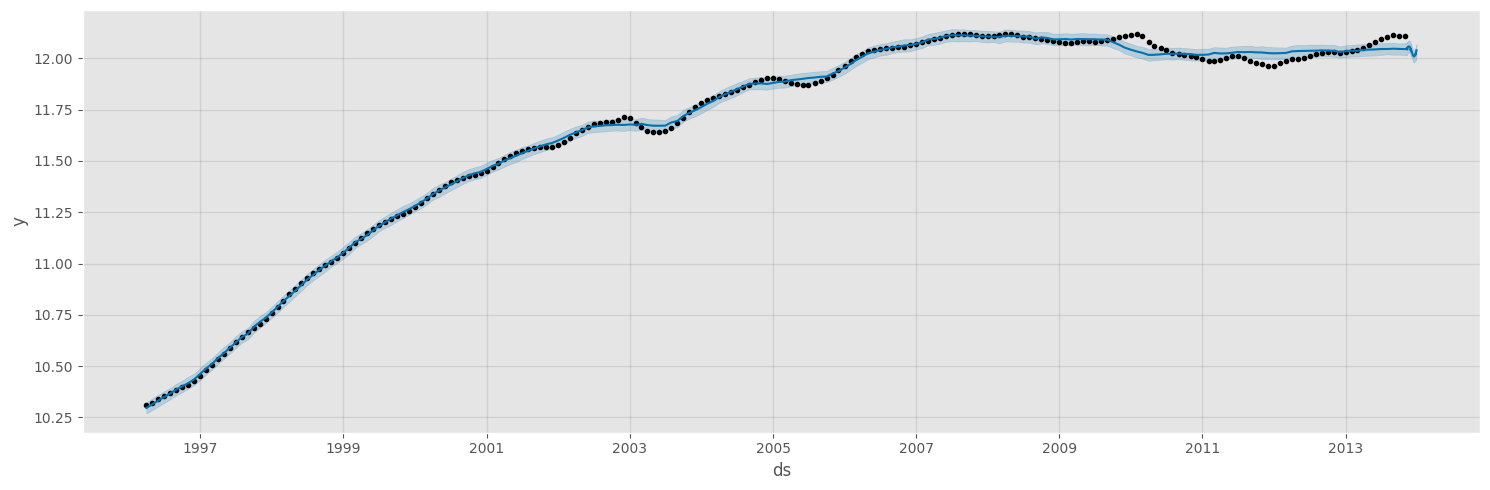

In [102]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = fb_model_with_holidays.plot(forecast_with_holidays,ax=ax)
plt.show()

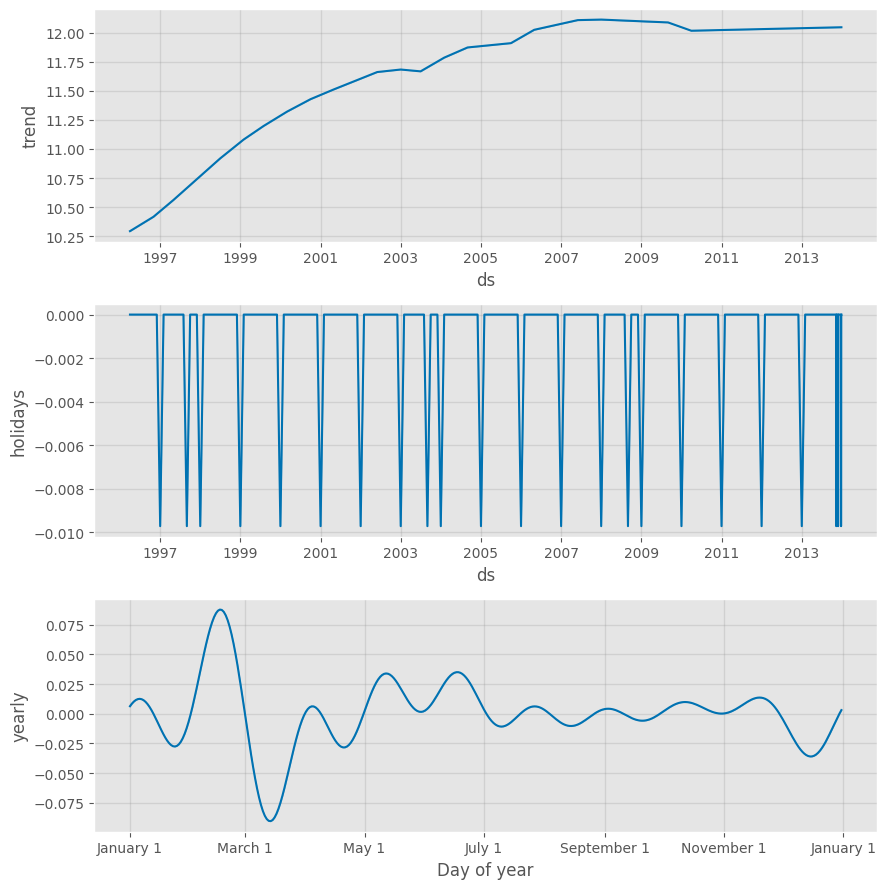

In [103]:
# Plot the components of the model
fig = fb_model_with_holidays.plot_components(forecast_with_holidays)

In [104]:
#Filling in df with predictions from FB Prophet Model with Holidays
fb_forecast_holiday = fb_model_with_holidays.predict(fb_future_dates)
fb_forecast_holiday.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1996-04-01  10.293761   10.267483   10.324403    10.293761    10.293761   
1 1996-05-01  10.311070   10.286235   10.342377    10.311070    10.311070   
2 1996-06-01  10.328957   10.302785   10.359519    10.328957    10.328957   
3 1996-07-01  10.346266   10.322478   10.379739    10.346266    10.346266   
4 1996-08-01  10.364153   10.338155   10.396578    10.364153    10.364153   

   US-Holidays  US-Holidays_lower  US-Holidays_upper  additive_terms  ...  \
0          0.0                0.0                0.0        0.002319  ...   
1          0.0                0.0                0.0        0.003299  ...   
2          0.0                0.0                0.0        0.002955  ...   
3          0.0                0.0                0.0        0.003142  ...   
4          0.0                0.0                0.0        0.003035  ...   

   holidays  holidays_lower  holidays_upper    yearly  yearly_lower  \
0       0.0             0.0             0.0  0.002319      0.002319   
1       0.0             0.0             0.0  0.003299      0.003299   
2       0.0             0.0             0.0  0.002955      0.002955   
3       0.0             0.0             0.0  0.003142      0.003142   
4       0.0             0.0             0.0  0.003035      0.003035   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0      0.002319                   0.0                         0.0   
1      0.003299                   0.0                         0.0   
2      0.002955                   0.0                         0.0   
3      0.003142                   0.0                         0.0   
4      0.003035                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  10.296080  
1                         0.0  10.314370  
2                         0.0  10.331912  
3                         0.0  10.349408  
4                         0.0  10.367187  

[5 rows x 22 columns]

In [105]:
# Getting the real and predicted values
fb_prediction_holiday = fb_forecast_holiday[212:]
fb_prediction_holiday = fb_prediction_holiday[['yhat','ds']]
fb_prediction_holiday['unlog_value'] = np.exp(fb_prediction_holiday['yhat'])

In [106]:
fb_holiday_rmse = np.sqrt(mean_squared_error(test['value'], fb_prediction_holiday['unlog_value']))
print(fb_holiday_rmse)

49203.92374728114


There was actually an increase in RMSE value after this addition of holidays into the Facebook Prophet Model. Since this tuning was ineffective in increasing the performance of the Facebook Prophet Model, additional parameters to be tuned will be explored. 

## Parameter Tuning for the Facebook Prophet Model

In order to most effectively determine the ideal parameters for the Facebook Prophet Model, grid search will be utilized. 

In [107]:
#Creating param_grid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [108]:
#Training FB Model with param grid to minimize RMSE value
strt='2019-12-31'
end='2020-02-26'
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
for p in grid:
    tune_test = pd.DataFrame()
    print(p)
    random.seed(0)
    tune_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    tune_model.add_country_holidays(country_name='US')
    tune_model.fit(fb_train)
    tune_forecast = tune_model.make_future_dataframe(periods=53, freq='M',include_history = False)
    tune_forecast = tune_model.predict(tune_forecast)
    tune_test=tune_forecast[['ds','yhat']]
    #Actual = test[(fb_test['ds']>strt) & (fb_test['ds']<=end)]
    tune_test['unlog_value'] = np.exp(tune_test['yhat'])
    RMSE = np.sqrt(mean_squared_error(test['value'], tune_test['unlog_value']))
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/rwgaye9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/b8a45t2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50443', 'data', 'file=/tmp/tmp4yyjkats/rwgaye9h.json', 'init=/tmp/tmp4yyjkats/b8a45t2i.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelay0jr4i2/prophet_model-20230610220604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/s4zzgzko.json


Root Mean Square Error(RMSE)------------------------------------ 42310.49083950662
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/txe09sne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32599', 'data', 'file=/tmp/tmp4yyjkats/s4zzgzko.json', 'init=/tmp/tmp4yyjkats/txe09sne.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model6nnjmzlm/prophet_model-20230610220607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 107334.50857402135
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ynw3z_pz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/u7l7ab4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97043', 'data', 'file=/tmp/tmp4yyjkats/ynw3z_pz.json', 'init=/tmp/tmp4yyjkats/u7l7ab4r.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model0rt6br02/prophet_model-20230610220610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/5vjvambg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/jy542jkj.json


Root Mean Square Error(RMSE)------------------------------------ 42889.53095966169
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71936', 'data', 'file=/tmp/tmp4yyjkats/5vjvambg.json', 'init=/tmp/tmp4yyjkats/jy542jkj.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelwtkwu94x/prophet_model-20230610220613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/d2_zgydh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/349xshfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/pr

Root Mean Square Error(RMSE)------------------------------------ 92753.68386437216
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:06:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/sh1iusey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/i3k5yyt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56052', 'data', 'file=/tmp/tmp4yyjkats/sh1iusey.json', 'init=/tmp/tmp4yyjkats/i3k5yyt0.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelj_6vj6t5/prophet_model-20230610220617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 43193.15158324736
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/n7pml2qn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/0qihw10m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89218', 'data', 'file=/tmp/tmp4yyjkats/n7pml2qn.json', 'init=/tmp/tmp4yyjkats/0qihw10m.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelyqbe8a4_/prophet_model-20230610220618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 95895.35324343985
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:06:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/e996ft7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/e70sibkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55895', 'data', 'file=/tmp/tmp4yyjkats/e996ft7j.json', 'init=/tmp/tmp4yyjkats/e70sibkh.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model9bbvrlmo/prophet_model-20230610220620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 48118.011998996
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:06:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/4n03konu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ir6b4dta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30157', 'data', 'file=/tmp/tmp4yyjkats/4n03konu.json', 'init=/tmp/tmp4yyjkats/ir6b4dta.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeliu0lww7b/prophet_model-20230610220621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 380574.415529219
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:06:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/pgcr3wi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/_upv21hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25910', 'data', 'file=/tmp/tmp4yyjkats/pgcr3wi8.json', 'init=/tmp/tmp4yyjkats/_upv21hl.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model4089gzgs/prophet_model-20230610220623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 49105.13852029018
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/sullnax_.json


Root Mean Square Error(RMSE)------------------------------------ 280289.3727956326
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/yhog7oas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97418', 'data', 'file=/tmp/tmp4yyjkats/sullnax_.json', 'init=/tmp/tmp4yyjkats/yhog7oas.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model6g_g5tuf/prophet_model-20230610220626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/g5c8bwdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/hbp5hsxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Root Mean Square Error(RMSE)------------------------------------ 47169.58261573865
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19095', 'data', 'file=/tmp/tmp4yyjkats/g5c8bwdq.json', 'init=/tmp/tmp4yyjkats/hbp5hsxe.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelod2np7oe/prophet_model-20230610220629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/r92tfhqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/nneffw8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81908', 'data', 'file=/tmp/tmp4yyjkats/r92tfhqc.json', 'init=/tmp/tmp4yyjkats/nneffw8x.json', 'output', 'file=/tmp/

Root Mean Square Error(RMSE)------------------------------------ 210948.08627416537
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/tyevqt9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/bkj9j9jp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80817', 'data', 'file=/tmp/tmp4yyjkats/tyevqt9t.json', 'init=/tmp/tmp4yyjkats/bkj9j9jp.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model4jupq6gw/prophet_model-20230610220632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 50329.38805609131
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:06:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/5z5ds8uf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/j76yaqw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3520', 'data', 'file=/tmp/tmp4yyjkats/5z5ds8uf.json', 'init=/tmp/tmp4yyjkats/j76yaqw2.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model_udtmsje/prophet_model-20230610220634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 669739.7072275553
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:06:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/raz2e7jl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/0gck__rw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16254', 'data', 'file=/tmp/tmp4yyjkats/raz2e7jl.json', 'init=/tmp/tmp4yyjkats/0gck__rw.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeltch6r3tt/prophet_model-20230610220635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 48684.392666543674
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:06:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/foelnjui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/x1yhv8cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42650', 'data', 'file=/tmp/tmp4yyjkats/foelnjui.json', 'init=/tmp/tmp4yyjkats/x1yhv8cz.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelgsysrtnf/prophet_model-20230610220637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 298532.045434962
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:06:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ad6yxmr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/o1u1hie9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95551', 'data', 'file=/tmp/tmp4yyjkats/ad6yxmr8.json', 'init=/tmp/tmp4yyjkats/o1u1hie9.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelp2m9430g/prophet_model-20230610220639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 49903.52951111082
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/wcw6gg6r.json


Root Mean Square Error(RMSE)------------------------------------ 284767.01222145604
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/rj87v6rn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29044', 'data', 'file=/tmp/tmp4yyjkats/wcw6gg6r.json', 'init=/tmp/tmp4yyjkats/rj87v6rn.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model652l60sg/prophet_model-20230610220642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/uxq27ths.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p6jow0ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 52805.03623192151
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:06:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gl84jngv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/_f0omisg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73926', 'data', 'file=/tmp/tmp4yyjkats/gl84jngv.json', 'init=/tmp/tmp4yyjkats/_f0omisg.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model4398ai1h/prophet_model-20230610220646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 533053.6494638742
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:06:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/o06s10cy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/tjoeja7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91620', 'data', 'file=/tmp/tmp4yyjkats/o06s10cy.json', 'init=/tmp/tmp4yyjkats/tjoeja7s.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelpxqjtf2y/prophet_model-20230610220648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 52207.8033848899
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:06:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/1euckg7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ty1w9xn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62925', 'data', 'file=/tmp/tmp4yyjkats/1euckg7_.json', 'init=/tmp/tmp4yyjkats/ty1w9xn0.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelmy8rcyf0/prophet_model-20230610220649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 437877.04442272044
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:06:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/09y1196c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ds4li248.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12474', 'data', 'file=/tmp/tmp4yyjkats/09y1196c.json', 'init=/tmp/tmp4yyjkats/ds4li248.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelxadcq9en/prophet_model-20230610220651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 48888.98572916892
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:06:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/rhk4r0p0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/sm654_gx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61588', 'data', 'file=/tmp/tmp4yyjkats/rhk4r0p0.json', 'init=/tmp/tmp4yyjkats/sm654_gx.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelxxz5jcsd/prophet_model-20230610220653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 303946.5774503518
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:06:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/_5da2m8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/z812kb4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13524', 'data', 'file=/tmp/tmp4yyjkats/_5da2m8f.json', 'init=/tmp/tmp4yyjkats/z812kb4p.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model52sukwt7/prophet_model-20230610220654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 51542.897474367455
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:06:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ud3ngs3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/hs1c9_qr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27988', 'data', 'file=/tmp/tmp4yyjkats/ud3ngs3k.json', 'init=/tmp/tmp4yyjkats/hs1c9_qr.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelzc3ea64y/prophet_model-20230610220657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:06:57 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 736030.8620614483
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:cmdstanpy:Chain [1] start processing
22:06:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/_8q3y36l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/oxgahkyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60917', 'data', 'file=/tmp/tmp4yyjkats/_8q3y36l.json', 'init=/tmp/tmp4yyjkats/oxgahkyk.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelx4itpt22/prophet_model-20230610220700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 52530.63222134344
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:07:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/nzme9sn3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/x0fk_cw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42370', 'data', 'file=/tmp/tmp4yyjkats/nzme9sn3.json', 'init=/tmp/tmp4yyjkats/x0fk_cw2.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelw4bqxm3l/prophet_model-20230610220702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 398462.9028978382
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/sp0iwiit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/uvopntr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79998', 'data', 'file=/tmp/tmp4yyjkats/sp0iwiit.json', 'init=/tmp/tmp4yyjkats/uvopntr_.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelvz5kipp6/prophet_model-20230610220703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 49875.75921157633
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:07:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8uqqmif_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/la8vw3en.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31309', 'data', 'file=/tmp/tmp4yyjkats/8uqqmif_.json', 'init=/tmp/tmp4yyjkats/la8vw3en.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelqvxo2pkj/prophet_model-20230610220705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 391162.1122412995
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/9kdv5zzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gll21o1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68264', 'data', 'file=/tmp/tmp4yyjkats/9kdv5zzg.json', 'init=/tmp/tmp4yyjkats/gll21o1o.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelovkssp52/prophet_model-20230610220707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 44683.433929125546
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:07:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/2b_z889g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/unb3ui83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92589', 'data', 'file=/tmp/tmp4yyjkats/2b_z889g.json', 'init=/tmp/tmp4yyjkats/unb3ui83.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model0ip5h0jv/prophet_model-20230610220708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 153265.06791802004
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:07:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/yoy731hn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/l7wrmfsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11471', 'data', 'file=/tmp/tmp4yyjkats/yoy731hn.json', 'init=/tmp/tmp4yyjkats/l7wrmfsk.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelk0yo0tg4/prophet_model-20230610220710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 45031.56018164053
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/esi1p8z8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/n32gryoc.json
DEBUG:cmdstanpy:idx 0


Root Mean Square Error(RMSE)------------------------------------ 142806.83428006506
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34529', 'data', 'file=/tmp/tmp4yyjkats/esi1p8z8.json', 'init=/tmp/tmp4yyjkats/n32gryoc.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelmd5vxtqw/prophet_model-20230610220713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/qrcu81l0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/t7kibf7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'ran

Root Mean Square Error(RMSE)------------------------------------ 45911.46385536865
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/b2c7j4hw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/9_tcf_q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24115', 'data', 'file=/tmp/tmp4yyjkats/b2c7j4hw.json', 'init=/tmp/tmp4yyjkats/9_tcf_q2.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelwek_1sem/prophet_model-20230610220717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 126949.41613252534
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/mnhc46dm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/2_ci8gnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92185', 'data', 'file=/tmp/tmp4yyjkats/mnhc46dm.json', 'init=/tmp/tmp4yyjkats/2_ci8gnj.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model64h3khkl/prophet_model-20230610220719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 73114.66779343016
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:07:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/v951qqkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/y0xagfs0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14175', 'data', 'file=/tmp/tmp4yyjkats/v951qqkq.json', 'init=/tmp/tmp4yyjkats/y0xagfs0.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelhwb5z795/prophet_model-20230610220720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 740423.0754574682
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/pvxwx0zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/w00mfsbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31770', 'data', 'file=/tmp/tmp4yyjkats/pvxwx0zb.json', 'init=/tmp/tmp4yyjkats/w00mfsbw.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelhvn51pt0/prophet_model-20230610220722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 60023.02832071459
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:07:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/oaqdvc03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p6p1rubg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65531', 'data', 'file=/tmp/tmp4yyjkats/oaqdvc03.json', 'init=/tmp/tmp4yyjkats/p6p1rubg.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeloicjwh09/prophet_model-20230610220724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1001330.0775348016
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/lpiyajz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/_dl1w2k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1715', 'data', 'file=/tmp/tmp4yyjkats/lpiyajz9.json', 'init=/tmp/tmp4yyjkats/_dl1w2k6.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelp9yh0a6h/prophet_model-20230610220726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 70701.12067890575
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gcfzrw04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/s1iwdybp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18479', 'data', 'file=/tmp/tmp4yyjkats/gcfzrw04.json', 'init=/tmp/tmp4yyjkats/s1iwdybp.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modellsbu_hiy/prophet_model-20230610220732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 433862.8646709948
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/0q0k0k3y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ho5svtgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37431', 'data', 'file=/tmp/tmp4yyjkats/0q0k0k3y.json', 'init=/tmp/tmp4yyjkats/ho5svtgc.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modely5d6fug5/prophet_model-20230610220733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 90939.35386149099
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:07:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/hibxt5s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/v2bp0inx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76861', 'data', 'file=/tmp/tmp4yyjkats/hibxt5s2.json', 'init=/tmp/tmp4yyjkats/v2bp0inx.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model4c96m_ui/prophet_model-20230610220735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1272268.294402262
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:07:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gx0dwagn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8lpeix6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9178', 'data', 'file=/tmp/tmp4yyjkats/gx0dwagn.json', 'init=/tmp/tmp4yyjkats/8lpeix6p.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model2vumunt2/prophet_model-20230610220736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 63572.195107245505
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:07:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/arwv0pm8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/e843t4x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39640', 'data', 'file=/tmp/tmp4yyjkats/arwv0pm8.json', 'init=/tmp/tmp4yyjkats/e843t4x2.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelmkhc_zqt/prophet_model-20230610220738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 768283.0203191192
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:07:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/dvwy9270.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/htaeyfi3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18071', 'data', 'file=/tmp/tmp4yyjkats/dvwy9270.json', 'init=/tmp/tmp4yyjkats/htaeyfi3.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelubxq5zhm/prophet_model-20230610220740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 71000.99065384404
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:07:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/dqoviaf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ctngpk1k.json
DEBUG:cmdstanpy:idx 0


Root Mean Square Error(RMSE)------------------------------------ 634362.4765305506
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29809', 'data', 'file=/tmp/tmp4yyjkats/dqoviaf9.json', 'init=/tmp/tmp4yyjkats/ctngpk1k.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeluq9cvnfb/prophet_model-20230610220742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ftm0kd9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/hd4jyanq.json


Root Mean Square Error(RMSE)------------------------------------ 81864.62578967547
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90751', 'data', 'file=/tmp/tmp4yyjkats/ftm0kd9h.json', 'init=/tmp/tmp4yyjkats/hd4jyanq.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelp88pohz3/prophet_model-20230610220745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/uz6oyv_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/oe3nk2di.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7636', 'data', 'file=/tmp/tmp4yyjkats/uz6o

Root Mean Square Error(RMSE)------------------------------------ 1255853.0568184617
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:07:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/f9jx6_67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/942aumku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73338', 'data', 'file=/tmp/tmp4yyjkats/f9jx6_67.json', 'init=/tmp/tmp4yyjkats/942aumku.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelxl8ub13w/prophet_model-20230610220748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 74254.73681809111
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:07:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/020g17lh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/91l5c_qx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98102', 'data', 'file=/tmp/tmp4yyjkats/020g17lh.json', 'init=/tmp/tmp4yyjkats/91l5c_qx.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelj9vqpfsd/prophet_model-20230610220750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 651725.6474789229
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:07:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/tlqwsor3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/cmo28ssu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86489', 'data', 'file=/tmp/tmp4yyjkats/tlqwsor3.json', 'init=/tmp/tmp4yyjkats/cmo28ssu.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model52zqrimu/prophet_model-20230610220752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 87336.47276043285
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/2_q8812h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/mpoehmk3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41346', 'data', 'file=/tmp/tmp4yyjkats/2_q8812h.json', 'init=/tmp/tmp4yyjkats/mpoehmk3.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelhe0kwqe6/prophet_model-20230610220754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1014259.4081429048
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:07:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/fseeor8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/epgaxupr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97604', 'data', 'file=/tmp/tmp4yyjkats/fseeor8d.json', 'init=/tmp/tmp4yyjkats/epgaxupr.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelg4iz1qbi/prophet_model-20230610220755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 91587.93804512848
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:07:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/a6xkmbz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ky6lwrw8.json


Root Mean Square Error(RMSE)------------------------------------ 1556813.3064810648
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8771', 'data', 'file=/tmp/tmp4yyjkats/a6xkmbz8.json', 'init=/tmp/tmp4yyjkats/ky6lwrw8.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeluknpufhi/prophet_model-20230610220757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/nu256rsu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/jz3znznv.json


Root Mean Square Error(RMSE)------------------------------------ 87058.32457921226
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44036', 'data', 'file=/tmp/tmp4yyjkats/nu256rsu.json', 'init=/tmp/tmp4yyjkats/jz3znznv.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model_4ii_702/prophet_model-20230610220800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ptlpap_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/wxm4gxj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/pr

Root Mean Square Error(RMSE)------------------------------------ 994838.9693776252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/7f0mnrhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/olt0l30v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32366', 'data', 'file=/tmp/tmp4yyjkats/7f0mnrhb.json', 'init=/tmp/tmp4yyjkats/olt0l30v.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeluaki1h5s/prophet_model-20230610220804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 79151.94651449678
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:08:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/zwo091gx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/d8vivgj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89471', 'data', 'file=/tmp/tmp4yyjkats/zwo091gx.json', 'init=/tmp/tmp4yyjkats/d8vivgj5.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model8l9lects/prophet_model-20230610220806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 858145.5538590121
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:08:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/66uked_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/phh_viek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83514', 'data', 'file=/tmp/tmp4yyjkats/66uked_x.json', 'init=/tmp/tmp4yyjkats/phh_viek.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model1x5etavt/prophet_model-20230610220807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 47500.07560069191
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:08:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/9oboqifi.json


Root Mean Square Error(RMSE)------------------------------------ 189473.00003657915
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/m5xk2k8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68077', 'data', 'file=/tmp/tmp4yyjkats/9oboqifi.json', 'init=/tmp/tmp4yyjkats/m5xk2k8l.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model5hl5p18r/prophet_model-20230610220809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8s69rald.json


Root Mean Square Error(RMSE)------------------------------------ 49016.503053640125
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p2t3o5py.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=628', 'data', 'file=/tmp/tmp4yyjkats/8s69rald.json', 'init=/tmp/tmp4yyjkats/p2t3o5py.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modell9ibcbjc/prophet_model-20230610220812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/mney3a8u.json


Root Mean Square Error(RMSE)------------------------------------ 182020.83867360745
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3_7pg48x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53760', 'data', 'file=/tmp/tmp4yyjkats/mney3a8u.json', 'init=/tmp/tmp4yyjkats/3_7pg48x.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model0b2qq3ev/prophet_model-20230610220816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/o7o1s8uj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gtk4dc9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: 

Root Mean Square Error(RMSE)------------------------------------ 48834.422882985236
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:08:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/l_5w0w1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/26tghwg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23380', 'data', 'file=/tmp/tmp4yyjkats/l_5w0w1u.json', 'init=/tmp/tmp4yyjkats/26tghwg1.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model2efahzie/prophet_model-20230610220821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 159276.63582660622
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/npchvvd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/362runay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71470', 'data', 'file=/tmp/tmp4yyjkats/npchvvd2.json', 'init=/tmp/tmp4yyjkats/362runay.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelyhjhz4il/prophet_model-20230610220822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 88781.7785714954
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/hr32i2el.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/td67ra4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32796', 'data', 'file=/tmp/tmp4yyjkats/hr32i2el.json', 'init=/tmp/tmp4yyjkats/td67ra4r.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model3z1mti80/prophet_model-20230610220823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 725781.9439404418
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:08:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/98wgjuik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/4l64pr87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77304', 'data', 'file=/tmp/tmp4yyjkats/98wgjuik.json', 'init=/tmp/tmp4yyjkats/4l64pr87.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelwchy_ev0/prophet_model-20230610220825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 98205.81888584516
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:08:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/a6rp7lqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p_zl7lnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94708', 'data', 'file=/tmp/tmp4yyjkats/a6rp7lqh.json', 'init=/tmp/tmp4yyjkats/p_zl7lnq.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modele9t4vcde/prophet_model-20230610220827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 767967.4394702784
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:08:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/h5xso0gr.json


Root Mean Square Error(RMSE)------------------------------------ 84560.47686379733
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/6lzvssut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64556', 'data', 'file=/tmp/tmp4yyjkats/h5xso0gr.json', 'init=/tmp/tmp4yyjkats/6lzvssut.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelmdi6nbbn/prophet_model-20230610220829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/eagpqfm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/jsq1aiu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Root Mean Square Error(RMSE)------------------------------------ 528865.5119418073
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21895', 'data', 'file=/tmp/tmp4yyjkats/eagpqfm_.json', 'init=/tmp/tmp4yyjkats/jsq1aiu4.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelkyimyz9_/prophet_model-20230610220832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/bhuuugob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/xazgu7rh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77230', 'data', 'file=/tmp/tmp4yyjkats/bhuuugob.json', 'init=/tmp/tmp4yyjkats/xazgu7rh.json', 'output', 'file=/tmp/

Root Mean Square Error(RMSE)------------------------------------ 121164.19012198989
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/dhbhor5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/vxun0d3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3633', 'data', 'file=/tmp/tmp4yyjkats/dhbhor5b.json', 'init=/tmp/tmp4yyjkats/vxun0d3r.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model5u9o1x1n/prophet_model-20230610220836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1634146.0212002029
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:08:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gkdfqhgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/mzj_dp1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43048', 'data', 'file=/tmp/tmp4yyjkats/gkdfqhgy.json', 'init=/tmp/tmp4yyjkats/mzj_dp1u.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model21e9c9bu/prophet_model-20230610220837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 111242.31221638182
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:08:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/qyzawg68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/0sxhuhxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84984', 'data', 'file=/tmp/tmp4yyjkats/qyzawg68.json', 'init=/tmp/tmp4yyjkats/0sxhuhxu.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelvhvasdr7/prophet_model-20230610220839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1820698.365548567
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/6wyxqbfn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ojlbp3wr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45556', 'data', 'file=/tmp/tmp4yyjkats/6wyxqbfn.json', 'init=/tmp/tmp4yyjkats/ojlbp3wr.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelqozpajwa/prophet_model-20230610220841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 102068.11769069516
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:08:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/xnsw3i1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/z_43724k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44569', 'data', 'file=/tmp/tmp4yyjkats/xnsw3i1s.json', 'init=/tmp/tmp4yyjkats/z_43724k.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelr204s5xd/prophet_model-20230610220843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1102980.5829425447
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:08:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ilh4t1nf.json


Root Mean Square Error(RMSE)------------------------------------ 119076.35037517537
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/7hnayte3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58766', 'data', 'file=/tmp/tmp4yyjkats/ilh4t1nf.json', 'init=/tmp/tmp4yyjkats/7hnayte3.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model02q1wbc5/prophet_model-20230610220844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3mfsz0l4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/cyqsqirf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 3613876.0497273933
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:08:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/5dev7d_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/cyrc4tv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77658', 'data', 'file=/tmp/tmp4yyjkats/5dev7d_n.json', 'init=/tmp/tmp4yyjkats/cyrc4tv3.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelsjxppt7s/prophet_model-20230610220850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 103141.54299714671
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:08:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/0q3yaa2h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/h2f8a8s1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36683', 'data', 'file=/tmp/tmp4yyjkats/0q3yaa2h.json', 'init=/tmp/tmp4yyjkats/h2f8a8s1.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_models8nd_1_8/prophet_model-20230610220851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2803574.763899018
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ki3jcxea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/iuhmy3tx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46079', 'data', 'file=/tmp/tmp4yyjkats/ki3jcxea.json', 'init=/tmp/tmp4yyjkats/iuhmy3tx.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelttb3js9v/prophet_model-20230610220853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 113011.30951184667
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:08:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/lmhfkydf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/7zwtn_dm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45195', 'data', 'file=/tmp/tmp4yyjkats/lmhfkydf.json', 'init=/tmp/tmp4yyjkats/7zwtn_dm.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model3wsqk16u/prophet_model-20230610220855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1054311.3828192414
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:08:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/m53te_a9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/i0qc2glq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58904', 'data', 'file=/tmp/tmp4yyjkats/m53te_a9.json', 'init=/tmp/tmp4yyjkats/i0qc2glq.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model3h5j76rs/prophet_model-20230610220856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 108022.36787535879
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:08:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p4bqjp7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/e4bc5bl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90236', 'data', 'file=/tmp/tmp4yyjkats/p4bqjp7i.json', 'init=/tmp/tmp4yyjkats/e4bc5bl9.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model2rjow36k/prophet_model-20230610220857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 3218762.5346680004
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:08:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/pbhe6vil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/q3k2yw8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10637', 'data', 'file=/tmp/tmp4yyjkats/pbhe6vil.json', 'init=/tmp/tmp4yyjkats/q3k2yw8n.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model23m12r2h/prophet_model-20230610220859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:08:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 108221.89636759915
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:09:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/qazbdoqa.json


Root Mean Square Error(RMSE)------------------------------------ 1167023.4524795446
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/054tl900.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90366', 'data', 'file=/tmp/tmp4yyjkats/qazbdoqa.json', 'init=/tmp/tmp4yyjkats/054tl900.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelrq_km23p/prophet_model-20230610220902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3ccx89yb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/pj39ndyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: 

Root Mean Square Error(RMSE)------------------------------------ 117434.7410726763
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:09:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8nif2mjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/1p90iv73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68579', 'data', 'file=/tmp/tmp4yyjkats/8nif2mjp.json', 'init=/tmp/tmp4yyjkats/1p90iv73.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeliu98ycyh/prophet_model-20230610220907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1112706.5212097901
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:09:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/4cm7zpyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/dat3w0c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56403', 'data', 'file=/tmp/tmp4yyjkats/4cm7zpyw.json', 'init=/tmp/tmp4yyjkats/dat3w0c3.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelxn6nwq94/prophet_model-20230610220909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 49330.44594419717
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:09:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/teer2shs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/5o84mnme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15960', 'data', 'file=/tmp/tmp4yyjkats/teer2shs.json', 'init=/tmp/tmp4yyjkats/5o84mnme.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modely2d4541t/prophet_model-20230610220910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 202247.32104976926
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8_w079xp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8hip54eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73310', 'data', 'file=/tmp/tmp4yyjkats/8_w079xp.json', 'init=/tmp/tmp4yyjkats/8hip54eb.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelyjlu8ym4/prophet_model-20230610220912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 50165.7474737717
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:09:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/z7trqv6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/dvvvdixm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56448', 'data', 'file=/tmp/tmp4yyjkats/z7trqv6n.json', 'init=/tmp/tmp4yyjkats/dvvvdixm.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelbv2ynxua/prophet_model-20230610220913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 185402.42315227838
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:09:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/zun53tm2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/c9ia2pwp.json
DEBUG:cmdstanpy:idx 0


Root Mean Square Error(RMSE)------------------------------------ 51983.721408124744
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33733', 'data', 'file=/tmp/tmp4yyjkats/zun53tm2.json', 'init=/tmp/tmp4yyjkats/c9ia2pwp.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model42gaco8s/prophet_model-20230610220915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/nm5ervdx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/mvwe7ywx.json
DEBUG:cmdstanpy:idx 0


Root Mean Square Error(RMSE)------------------------------------ 182675.485853082
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82336', 'data', 'file=/tmp/tmp4yyjkats/nm5ervdx.json', 'init=/tmp/tmp4yyjkats/mvwe7ywx.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modely0bfrp8y/prophet_model-20230610220919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/h2c5i0sz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/xeadmg8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86948', 'data', 'file=/tmp/tmp4yyjkats/h2c5i0sz.json', 'init=/tm

Root Mean Square Error(RMSE)------------------------------------ 112293.52491781914
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:09:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/0br66rhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/btyv_2zr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19162', 'data', 'file=/tmp/tmp4yyjkats/0br66rhi.json', 'init=/tmp/tmp4yyjkats/btyv_2zr.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelrpkn4lhu/prophet_model-20230610220922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1287368.91734066
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:09:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3izp5wkb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/a7ebilgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72887', 'data', 'file=/tmp/tmp4yyjkats/3izp5wkb.json', 'init=/tmp/tmp4yyjkats/a7ebilgv.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelwknlw5xs/prophet_model-20230610220924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 106739.74465253463
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/97aliigo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/i35thi3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31571', 'data', 'file=/tmp/tmp4yyjkats/97aliigo.json', 'init=/tmp/tmp4yyjkats/i35thi3w.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model8lr4o7ps/prophet_model-20230610220925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1061021.283604477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:09:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p23fzth3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/env_dnt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25191', 'data', 'file=/tmp/tmp4yyjkats/p23fzth3.json', 'init=/tmp/tmp4yyjkats/env_dnt_.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelni8whp45/prophet_model-20230610220927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 110915.64290864902
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:09:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/v5dpl614.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/w00iohht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90206', 'data', 'file=/tmp/tmp4yyjkats/v5dpl614.json', 'init=/tmp/tmp4yyjkats/w00iohht.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_models8lpvhpj/prophet_model-20230610220929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 947113.4736015009
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/o01a24wh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/a26ra10s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Root Mean Square Error(RMSE)------------------------------------ 122362.02675447681
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77942', 'data', 'file=/tmp/tmp4yyjkats/o01a24wh.json', 'init=/tmp/tmp4yyjkats/a26ra10s.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelot1l979x/prophet_model-20230610220931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/xxxotalr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/oj9eqeb6.json


Root Mean Square Error(RMSE)------------------------------------ 3341410.584360598
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83326', 'data', 'file=/tmp/tmp4yyjkats/xxxotalr.json', 'init=/tmp/tmp4yyjkats/oj9eqeb6.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelym_obv12/prophet_model-20230610220933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/c9mp0rki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/07d6_okf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67754', 'data', 'file=/tmp/tmp4yyjkats/c9m

Root Mean Square Error(RMSE)------------------------------------ 94862.50993529975
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:09:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/9kermxms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/bvcj8c_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99520', 'data', 'file=/tmp/tmp4yyjkats/9kermxms.json', 'init=/tmp/tmp4yyjkats/bvcj8c_p.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model8qfdcf4n/prophet_model-20230610220938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1149956.0252404602
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:09:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/pdz73lms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/sds0t9gt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97806', 'data', 'file=/tmp/tmp4yyjkats/pdz73lms.json', 'init=/tmp/tmp4yyjkats/sds0t9gt.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeloha4qq_e/prophet_model-20230610220940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 137532.4727300678
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:09:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/tjnvwte5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/rx6zmqh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46878', 'data', 'file=/tmp/tmp4yyjkats/tjnvwte5.json', 'init=/tmp/tmp4yyjkats/rx6zmqh3.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelvn6k1kv4/prophet_model-20230610220941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1248041.52845244
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:09:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gb4rdmcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/auoopnhn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86544', 'data', 'file=/tmp/tmp4yyjkats/gb4rdmcd.json', 'init=/tmp/tmp4yyjkats/auoopnhn.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelkn2ispvf/prophet_model-20230610220943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 135844.15813351198
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:09:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/jo_07vd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/tkv2nl_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16931', 'data', 'file=/tmp/tmp4yyjkats/jo_07vd8.json', 'init=/tmp/tmp4yyjkats/tkv2nl_0.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeldwyg0zar/prophet_model-20230610220944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2827182.4038156536
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:09:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/6hhxwsov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ptaokjm9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69190', 'data', 'file=/tmp/tmp4yyjkats/6hhxwsov.json', 'init=/tmp/tmp4yyjkats/ptaokjm9.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeliewarc6h/prophet_model-20230610220946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 147316.3517482847
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/hnvoihpy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/772ufnqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75190', 'data', 'file=/tmp/tmp4yyjkats/hnvoihpy.json', 'init=/tmp/tmp4yyjkats/772ufnqf.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelm4ccvsvh/prophet_model-20230610220949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2345456.088666454
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:09:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/9wmzou96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/y19l2zs4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10173', 'data', 'file=/tmp/tmp4yyjkats/9wmzou96.json', 'init=/tmp/tmp4yyjkats/y19l2zs4.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model5t9qtc81/prophet_model-20230610220952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 94466.39987649136
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:09:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8us0f3e7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/fqclu9jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87066', 'data', 'file=/tmp/tmp4yyjkats/8us0f3e7.json', 'init=/tmp/tmp4yyjkats/fqclu9jb.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelhzy1b2u_/prophet_model-20230610220953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1256580.1933719842
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:09:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/f4lqwgml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/7tzsb7ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84438', 'data', 'file=/tmp/tmp4yyjkats/f4lqwgml.json', 'init=/tmp/tmp4yyjkats/7tzsb7ik.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeljtzkqldk/prophet_model-20230610220955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 176800.3004443338
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/yqxy0uta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/2gj4ptzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39379', 'data', 'file=/tmp/tmp4yyjkats/yqxy0uta.json', 'init=/tmp/tmp4yyjkats/2gj4ptzj.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelxj4tbzcq/prophet_model-20230610220956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 3045049.6635307465
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/bl9qgaqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/qvfbdto7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4569', 'data', 'file=/tmp/tmp4yyjkats/bl9qgaqv.json', 'init=/tmp/tmp4yyjkats/qvfbdto7.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelgakkqr05/prophet_model-20230610220958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 154494.26554362263
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:09:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/zqlw26wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/f12sv_zj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51759', 'data', 'file=/tmp/tmp4yyjkats/zqlw26wf.json', 'init=/tmp/tmp4yyjkats/f12sv_zj.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model3yjn8_g9/prophet_model-20230610220959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2299633.1795663275
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:10:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/u_5l_4tr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/6w2397z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45491', 'data', 'file=/tmp/tmp4yyjkats/u_5l_4tr.json', 'init=/tmp/tmp4yyjkats/6w2397z2.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model9cdzt7l3/prophet_model-20230610221001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 168730.24929274892
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:10:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/zrmhmv3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/q8yqe4ju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Root Mean Square Error(RMSE)------------------------------------ 2030312.6080265762
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34765', 'data', 'file=/tmp/tmp4yyjkats/zrmhmv3o.json', 'init=/tmp/tmp4yyjkats/q8yqe4ju.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model8gdllwqv/prophet_model-20230610221005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/u8fpy0m5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/6sf5s9gk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96545', 'data', 'file=/tmp/tmp4yyjkats/u8fpy0m5.json', 'init=/tmp/tmp4yyjkats/6sf5s9gk.json', 'output', 'file=/tmp/

Root Mean Square Error(RMSE)------------------------------------ 49912.43279875087
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:10:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p_ki2ncx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/lsjz21m0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74207', 'data', 'file=/tmp/tmp4yyjkats/p_ki2ncx.json', 'init=/tmp/tmp4yyjkats/lsjz21m0.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model9x2ph_6k/prophet_model-20230610221008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 205819.96480681637
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:10:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/21190nrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/0mz_9pw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25343', 'data', 'file=/tmp/tmp4yyjkats/21190nrx.json', 'init=/tmp/tmp4yyjkats/0mz_9pw0.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelbiwzxwth/prophet_model-20230610221010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 55364.900898272506
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:10:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3bsnetyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/06ezpwl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90208', 'data', 'file=/tmp/tmp4yyjkats/3bsnetyo.json', 'init=/tmp/tmp4yyjkats/06ezpwl2.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model8wispaw_/prophet_model-20230610221012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 220747.46422558872
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:10:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/yqjmc93x.json


Root Mean Square Error(RMSE)------------------------------------ 51207.144591786855
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/l1gcg380.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46222', 'data', 'file=/tmp/tmp4yyjkats/yqjmc93x.json', 'init=/tmp/tmp4yyjkats/l1gcg380.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modeljlrtitfg/prophet_model-20230610221014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/gdgpdy8w.json


Root Mean Square Error(RMSE)------------------------------------ 207103.85664117974
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/dq27rriq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54371', 'data', 'file=/tmp/tmp4yyjkats/gdgpdy8w.json', 'init=/tmp/tmp4yyjkats/dq27rriq.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model7o9u_n4d/prophet_model-20230610221018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/vfxnay2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/9xemyzog.json


Root Mean Square Error(RMSE)------------------------------------ 105421.48365515804
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79575', 'data', 'file=/tmp/tmp4yyjkats/vfxnay2c.json', 'init=/tmp/tmp4yyjkats/9xemyzog.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model43k_ft6v/prophet_model-20230610221020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/8ty4t5ru.json


Root Mean Square Error(RMSE)------------------------------------ 1811181.796119995
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/7j_3hepq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27485', 'data', 'file=/tmp/tmp4yyjkats/8ty4t5ru.json', 'init=/tmp/tmp4yyjkats/7j_3hepq.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelfzp9ca1b/prophet_model-20230610221023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/dnis2zh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/p14h1xob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 129650.18746592556
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:10:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/cbqbxhwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/2rkx7uzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69907', 'data', 'file=/tmp/tmp4yyjkats/cbqbxhwu.json', 'init=/tmp/tmp4yyjkats/2rkx7uzf.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelf8nbcvw0/prophet_model-20230610221026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 756075.6961061805
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/lhou7mbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/5pizs2s9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11850', 'data', 'file=/tmp/tmp4yyjkats/lhou7mbb.json', 'init=/tmp/tmp4yyjkats/5pizs2s9.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelavxn8a_3/prophet_model-20230610221028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 127119.7383367173
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:10:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/kp1d3_31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/o1e_cjlo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22993', 'data', 'file=/tmp/tmp4yyjkats/kp1d3_31.json', 'init=/tmp/tmp4yyjkats/o1e_cjlo.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model0lxao15c/prophet_model-20230610221030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 865280.6601393182
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:10:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/7q3n153o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/h96cc52e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20068', 'data', 'file=/tmp/tmp4yyjkats/7q3n153o.json', 'init=/tmp/tmp4yyjkats/h96cc52e.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model68sdioi7/prophet_model-20230610221032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 197200.28496245798
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:10:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/jnr0nfrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ugg9_uzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10352', 'data', 'file=/tmp/tmp4yyjkats/jnr0nfrk.json', 'init=/tmp/tmp4yyjkats/ugg9_uzq.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelp9qeiczs/prophet_model-20230610221033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 5033398.033640956
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:10:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/motr_wjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/7_0j921u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Root Mean Square Error(RMSE)------------------------------------ 189364.51912831824
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69282', 'data', 'file=/tmp/tmp4yyjkats/motr_wjh.json', 'init=/tmp/tmp4yyjkats/7_0j921u.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model4v3mqio0/prophet_model-20230610221036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/98p75yrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/xopbqpxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97347', 'data', 'file=/tmp/tmp4yyjkats/

Root Mean Square Error(RMSE)------------------------------------ 1928981.191113359
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:10:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/_g1qqw4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/2ptwe0ga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66413', 'data', 'file=/tmp/tmp4yyjkats/_g1qqw4n.json', 'init=/tmp/tmp4yyjkats/2ptwe0ga.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model7krb78a1/prophet_model-20230610221041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 125119.35813397288
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:10:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/zejk43f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3nudr1p1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63696', 'data', 'file=/tmp/tmp4yyjkats/zejk43f_.json', 'init=/tmp/tmp4yyjkats/3nudr1p1.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model36rhdfpr/prophet_model-20230610221043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2589992.746633231
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:10:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/4e189k4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/4nm4wr3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49277', 'data', 'file=/tmp/tmp4yyjkats/4e189k4l.json', 'init=/tmp/tmp4yyjkats/4nm4wr3u.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model01tnf6s7/prophet_model-20230610221044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 185387.12416454923
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/6h87auoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/sz6y73lx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93013', 'data', 'file=/tmp/tmp4yyjkats/6h87auoc.json', 'init=/tmp/tmp4yyjkats/sz6y73lx.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelhtm3woog/prophet_model-20230610221045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 4340266.443638585
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:10:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/wcbnk8wb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/emj1h39p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27107', 'data', 'file=/tmp/tmp4yyjkats/wcbnk8wb.json', 'init=/tmp/tmp4yyjkats/emj1h39p.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelbodmwv2r/prophet_model-20230610221047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 137672.7749190348
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/bh1_emre.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/6_6ba41b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=782', 'data', 'file=/tmp/tmp4yyjkats/bh1_emre.json', 'init=/tmp/tmp4yyjkats/6_6ba41b.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelqybsqfeb/prophet_model-20230610221049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 4059248.154767299
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:10:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/vum72f01.json


Root Mean Square Error(RMSE)------------------------------------ 171623.67488261315
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/16psqtf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73963', 'data', 'file=/tmp/tmp4yyjkats/vum72f01.json', 'init=/tmp/tmp4yyjkats/16psqtf5.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelvkj9lgh3/prophet_model-20230610221052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/830v9d9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/46rmolwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 1070719.448117102
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:10:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/3z3br7xu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/u98kuozt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62234', 'data', 'file=/tmp/tmp4yyjkats/3z3br7xu.json', 'init=/tmp/tmp4yyjkats/u98kuozt.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modellmml7j1v/prophet_model-20230610221056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 191076.25667053382
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:10:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/jq3swcg6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/52i073uc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69116', 'data', 'file=/tmp/tmp4yyjkats/jq3swcg6.json', 'init=/tmp/tmp4yyjkats/52i073uc.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_model_7ph4lxr/prophet_model-20230610221058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1995708.6900428354
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:10:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/n7zt3bh1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/bjnwd8e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26739', 'data', 'file=/tmp/tmp4yyjkats/n7zt3bh1.json', 'init=/tmp/tmp4yyjkats/bjnwd8e4.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelv8rvj18t/prophet_model-20230610221059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 143574.0688133342
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:11:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/fawwnp38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/yhuwfv1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69737', 'data', 'file=/tmp/tmp4yyjkats/fawwnp38.json', 'init=/tmp/tmp4yyjkats/yhuwfv1f.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelblpt9vjk/prophet_model-20230610221101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2570478.266577044
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:11:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/ftequpse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/k50_43zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75941', 'data', 'file=/tmp/tmp4yyjkats/ftequpse.json', 'init=/tmp/tmp4yyjkats/k50_43zo.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modelxcriuben/prophet_model-20230610221103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 144890.74663632087
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:11:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 2937284.52015285


In [109]:
#create df with model parameters sorted by RMSE
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

RMSE                                         Parameters
0  42310.490840  {'changepoint_prior_scale': 0.1, 'holidays_pri...
1  42889.530960  {'changepoint_prior_scale': 0.1, 'holidays_pri...
2  43193.151583  {'changepoint_prior_scale': 0.1, 'holidays_pri...
3  44683.433929  {'changepoint_prior_scale': 0.2, 'holidays_pri...
4  45031.560182  {'changepoint_prior_scale': 0.2, 'holidays_pri...

In [110]:
#pull out best parameters from df
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [111]:
# Setup and train model with holidays
fb_final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
fb_final_model.add_country_holidays(country_name='US')
fb_final_model.fit(fb_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/__qhkja7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yyjkats/iv_qy124.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71360', 'data', 'file=/tmp/tmp4yyjkats/__qhkja7.json', 'init=/tmp/tmp4yyjkats/iv_qy124.json', 'output', 'file=/tmp/tmp4yyjkats/prophet_modela5nme9kj/prophet_model-20230610221105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [112]:
#Final FB Model predictions
fb_final_future = fb_final_model.make_future_dataframe(periods=53, freq='M')
fb_final_forecast = fb_final_model.predict(fb_final_future)
fb_final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds       yhat  yhat_lower  yhat_upper
258 2017-09-30  12.118514   10.679689   13.503684
259 2017-10-31  12.114268   10.639031   13.529377
260 2017-11-30  12.116399   10.578475   13.570612
261 2017-12-31  12.389952   10.776102   13.921609
262 2018-01-31  12.106353   10.486679   13.627287
263 2018-02-28  12.128083   10.474430   13.694790
264 2018-03-31  12.133807   10.413297   13.759213

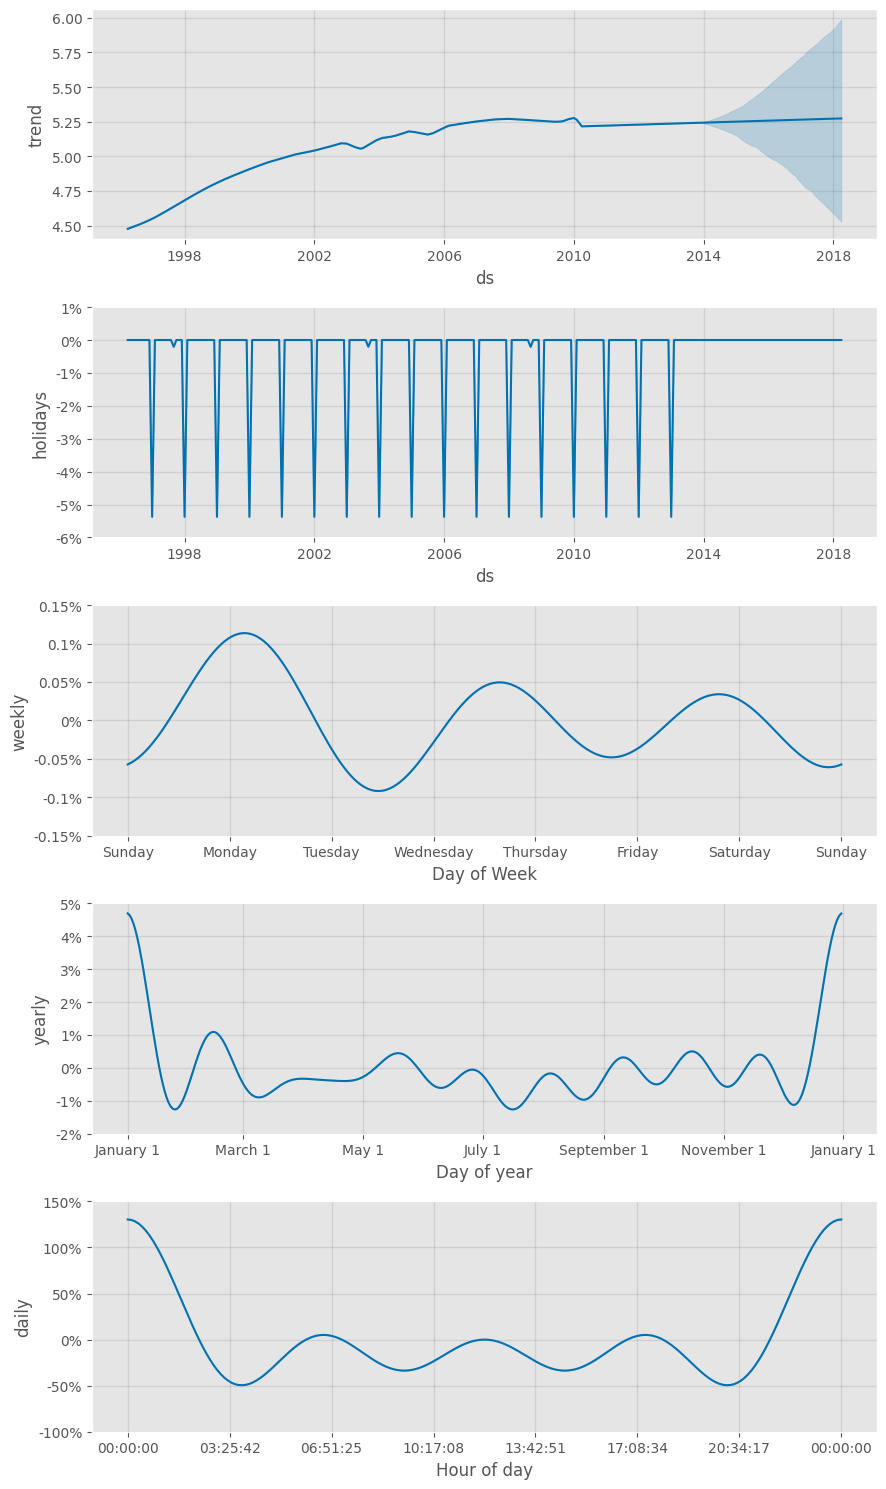

In [113]:
# Plot the components of the model
fig = fb_final_model.plot_components(fb_final_forecast)

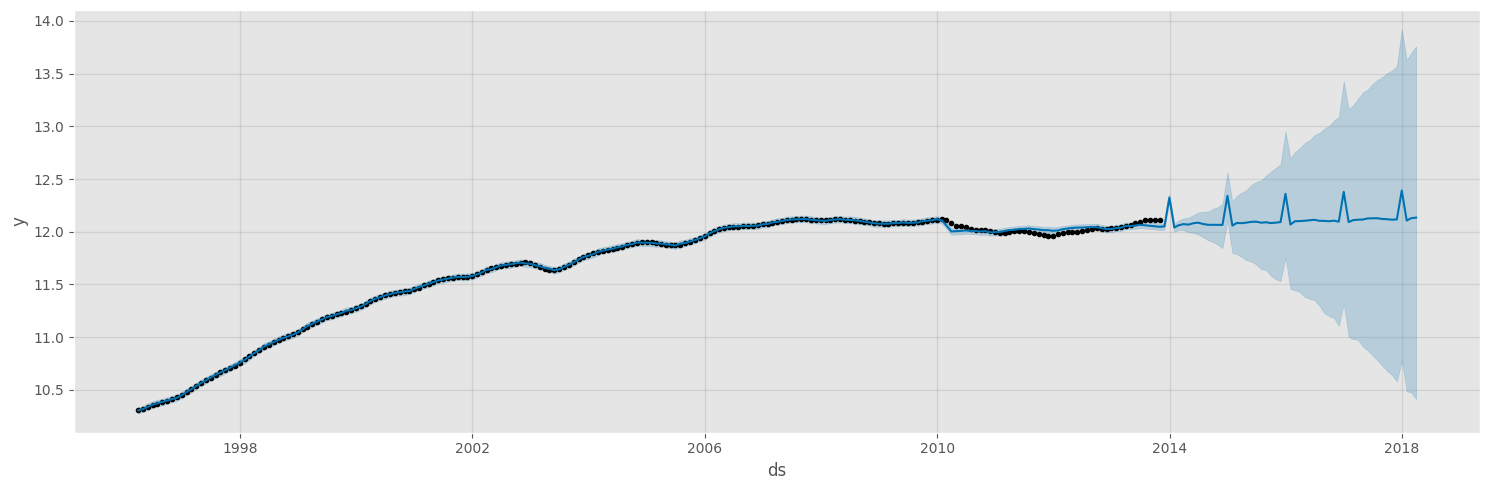

In [114]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = fb_final_model.plot(fb_final_forecast,ax=ax)
plt.show()


In [115]:
# Getting the real and predicted values
fb_prediction_final = fb_final_forecast[212:]
fb_prediction_final = fb_prediction_final[['yhat','ds']]
fb_prediction_final['unlog_value'] = np.exp(fb_prediction_final['yhat'])

In [116]:
#calculating the final FB model rmse
fb_final_rmse = np.sqrt(mean_squared_error(test['value'], fb_prediction_final['unlog_value']))
print(fb_final_rmse)

42310.49083950662


In [117]:
print(f"The RMSE value associated with the base model is {base_rmse}.")
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
print(f"The RMSE value associated with the Facebook Prophet model is {fb_rmse}.")
print(f"The RMSE value associated with the Tuned Facebook Prophet model is {fb_final_rmse}.")

The RMSE value associated with the base model is 42967.06724835346.
The RMSE value associated with the AUTO ARIMA model is 31204.69249024491.
The RMSE value associated with the Facebook Prophet model is 49199.202762526045.
The RMSE value associated with the Tuned Facebook Prophet model is 42310.49083950662.


Tuning the parameter of the Facebook Prophet model had a positive impact on the original untuned FB Prophet model. However, the AUTO ARIMA Sarimax model is still the most successful RMSE score. There is one additional model that will be used to try and improve performance. 

# LSTM Neural Network Model

A Long Short-Term Memory (LSTM) neural network model is a type of recurrent neural network (RNN) that is designed to capture long-term dependencies and patterns in sequential data, making it particularly useful for time series modeling. In the context of time series modeling, LSTM models excel at capturing temporal dependencies and patterns in the data. They can effectively model and predict sequences with complex patterns, such as stock prices, weather patterns, speech recognition, and natural language processing tasks. It is the hope that the LSTM model will do a better job not overfitting to the train dataset and negatively impacting the accuracy of it's predictions compared to the test dataset. 

## Preprocesing 80449 Data Series for LSTM Modeling

Since Flatiron program materials did not include information about how to model a time series with a LSTM Nueral Network, outside references were required. In order to properly preproces, build, and train an LSTM model with time series data, the information found in Dr. Jason Brownlee's article entitled 'Time Series Forecasting with the Long-Term Memory Network in Python' was extremely helpful. LINK HERE Many of the functions from that article are utilized in this section. 

## Transform Time Series to Supervised Learning

LSTM Nueral Networks assumes that the data is divided into input (X) and output (y) components. Therefore for a time series problem this can be acheived by using the observation from the last time step as the input and the observation at the current time step as the output. 

In [118]:
#observing the original 80449 data series
series80449

value
time                
1996-04-01   30000.0
1996-05-01   30400.0
1996-06-01   30900.0
1996-07-01   31400.0
1996-08-01   31800.0
...              ...
2017-12-01  254700.0
2018-01-01  256600.0
2018-02-01  259200.0
2018-03-01  263400.0
2018-04-01  267700.0

[265 rows x 1 columns]

In [119]:
# function to frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df

In [120]:
# transform to supervised learning
X = series80449.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

         0        0
0      0.0  30000.0
1  30000.0  30400.0
2  30400.0  30900.0
3  30900.0  31400.0
4  31400.0  31800.0


## Transform Time Series to Stationary

Stationary data is easier to model and will very likely result in more skillful forecasts. Therefore taking the log of the data series will be used to establish stationarity in the data. 

In [121]:
#Taking the log of the time series
supervised_logged = np.log(supervised)
supervised_logged

0          0
0         -inf  10.308953
1    10.308953  10.322198
2    10.322198  10.338511
3    10.338511  10.354563
4    10.354563  10.367222
..         ...        ...
260  12.440749  12.447842
261  12.447842  12.455274
262  12.455274  12.465355
263  12.465355  12.481429
264  12.481429  12.497622

[265 rows x 2 columns]

In [122]:
#replacing inf with 0
supervised_logged.replace([np.inf, -np.inf], 0, inplace=True)

## Transform Time Series to Scale

Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network. The default activation function for LSTMs is the hyperbolic tangent, which outputs values between -1 and 1. This is the preferred range for the time series data. The scaling coefficients values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

In [123]:
# Define train and test sets according to the index found above
train_sup = supervised_logged[:cutoff]

test_sup = supervised_logged[cutoff:]

In [124]:
#transforming training data series to a numpy array
train_sup = train_sup.to_numpy()

In [125]:
#transfomring testing data series to a numpy array
test_sup = test_sup.to_numpy()

In [126]:
# function to scale train and test data to [-1, 1]
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

In [127]:
# inverse scaling for a forecasted value for predictions
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = np.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

In [128]:
# transform the scale of the test and train data
scaler, train_scaled, test_scaled = scale(train_sup, test_sup)

In [129]:
#reshape for model input
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

## LSTM Model Development

Now that the data series has been pre-processd to be effectively used in the LSTM model, it is time to build the model itself. For processing time, a simple LSTM will be constructed with only one hidden LSTM layer.

In [130]:
#Building LSTM Model with one hidden LSTM Layer
lstm_model = Sequential()
lstm_model.add(LSTM(4, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
lstm_model.add(Dense(1))
#Using MSE since it closely matches RMSE
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X, y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
212/212 - 2s - loss: 0.3197 - 2s/epoch - 11ms/step
Epoch 2/100
212/212 - 0s - loss: 0.3162 - 390ms/epoch - 2ms/step
Epoch 3/100
212/212 - 0s - loss: 0.3144 - 388ms/epoch - 2ms/step
Epoch 4/100
212/212 - 0s - loss: 0.3080 - 379ms/epoch - 2ms/step
Epoch 5/100
212/212 - 0s - loss: 0.2989 - 358ms/epoch - 2ms/step
Epoch 6/100
212/212 - 0s - loss: 0.2997 - 368ms/epoch - 2ms/step
Epoch 7/100
212/212 - 0s - loss: 0.2886 - 383ms/epoch - 2ms/step
Epoch 8/100
212/212 - 0s - loss: 0.2896 - 369ms/epoch - 2ms/step
Epoch 9/100
212/212 - 0s - loss: 0.2825 - 361ms/epoch - 2ms/step
Epoch 10/100
212/212 - 0s - loss: 0.2764 - 362ms/epoch - 2ms/step
Epoch 11/100
212/212 - 0s - loss: 0.2679 - 361ms/epoch - 2ms/step
Epoch 12/100
212/212 - 0s - loss: 0.2590 - 375ms/epoch - 2ms/step
Epoch 13/100
212/212 - 0s - loss: 0.2561 - 364ms/epoch - 2ms/step
Epoch 14/100
212/212 - 0s - loss: 0.2455 - 365ms/epoch - 2ms/step
Epoch 15/100
212/212 - 0s - loss: 0.2416 - 357ms/epoch - 2ms/step
Epoch 16/100
212/212 

## Evaluating the LSTM Model

Now that the LSTM Nueral Network Model has been built and fitted to the train data it is time to evaluate the predictions against the test data series using RMSE to evaluate the accuracy of its predictions.

In [131]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
 X = X.reshape(1, 1, len(X))
 yhat = model.predict(X, batch_size=batch_size)
 return yhat[0,0]

In [132]:
#values from the original 80449 data series
raw_values = series80449.values
raw_values.shape

(265, 1)

In [133]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
 # make one-step forecast
 X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
 yhat = forecast_lstm(lstm_model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 yhat = np.exp(yhat)
 # store forecast
 predictions.append(yhat)
 expected = raw_values[len(train) + i ]
 print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 467ms/step
Month=1, Predicted=181096.520316, Expected=181100.000000
1/1 [==============================] - 0s 22ms/step
Month=2, Predicted=184692.540940, Expected=180900.000000
1/1 [==============================] - 0s 29ms/step
Month=3, Predicted=182257.802241, Expected=180100.000000
1/1 [==============================] - 0s 26ms/step
Month=4, Predicted=181607.507588, Expected=179900.000000
1/1 [==============================] - 0s 28ms/step
Month=5, Predicted=181362.539031, Expected=180500.000000
1/1 [==============================] - 0s 28ms/step
Month=6, Predicted=181616.942851, Expected=181500.000000
1/1 [==============================] - 0s 28ms/step
Month=7, Predicted=182234.003832, Expected=183000.000000
1/1 [==============================] - 0s 27ms/step
Month=8, Predicted=183407.750174, Expected=185400.000000
1/1 [==============================] - 0s 25ms/step
Month=9, Predicted=185602.979135, Expected=188400.000000
1/1 [=============

Test RMSE: 3576.855


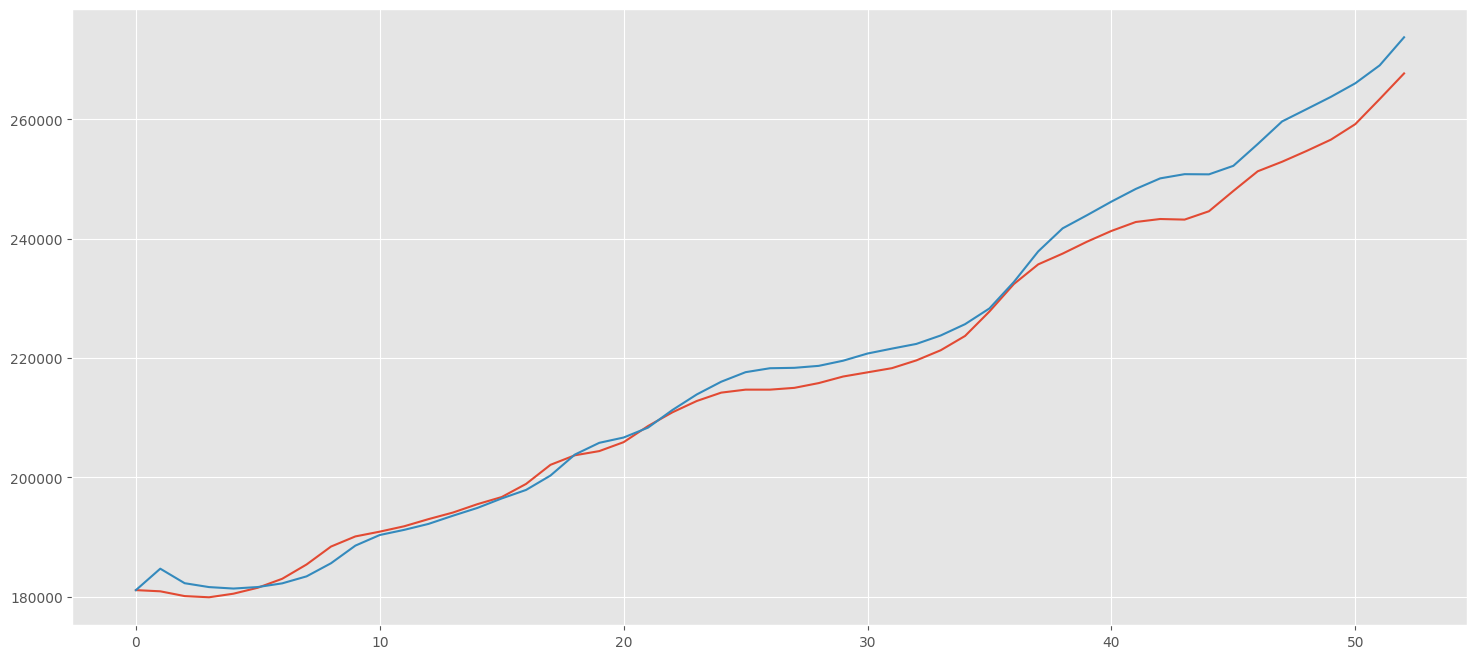

In [134]:
# visualization of report performance
lstm_rmse = np.sqrt(mean_squared_error(raw_values[-53:], predictions))
print('Test RMSE: %.3f' % lstm_rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-53:])
plt.plot(predictions)
plt.show()

In [135]:
print(f"The RMSE value associated with the base model is {base_rmse}.")
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
print(f"The RMSE value associated with the Facebook Prophet model is {fb_rmse}.")
print(f"The RMSE value associated with the Tuned Facebook Prophet model is {fb_final_rmse}.")
print(f'The RMSE value associated with the LSTM Neural Network model is {lstm_rmse}.')

The RMSE value associated with the base model is 42967.06724835346.
The RMSE value associated with the AUTO ARIMA model is 31204.69249024491.
The RMSE value associated with the Facebook Prophet model is 49199.202762526045.
The RMSE value associated with the Tuned Facebook Prophet model is 42310.49083950662.
The RMSE value associated with the LSTM Neural Network model is 3576.8547797384504.


Compared to the RMSE values of previous models, the LSTM Nueral Network vastly improved upon the accuracy of previous predictions. Since the LSTM is a recurrent neural network, having feedback connections versus a standard feedforward neural network had a big impact on accuracy of prediction. Based on this RMSE evaluation, the LSTM Nueral Network model will the be the final model used for prediction on all of the top 25 zipcodes. 

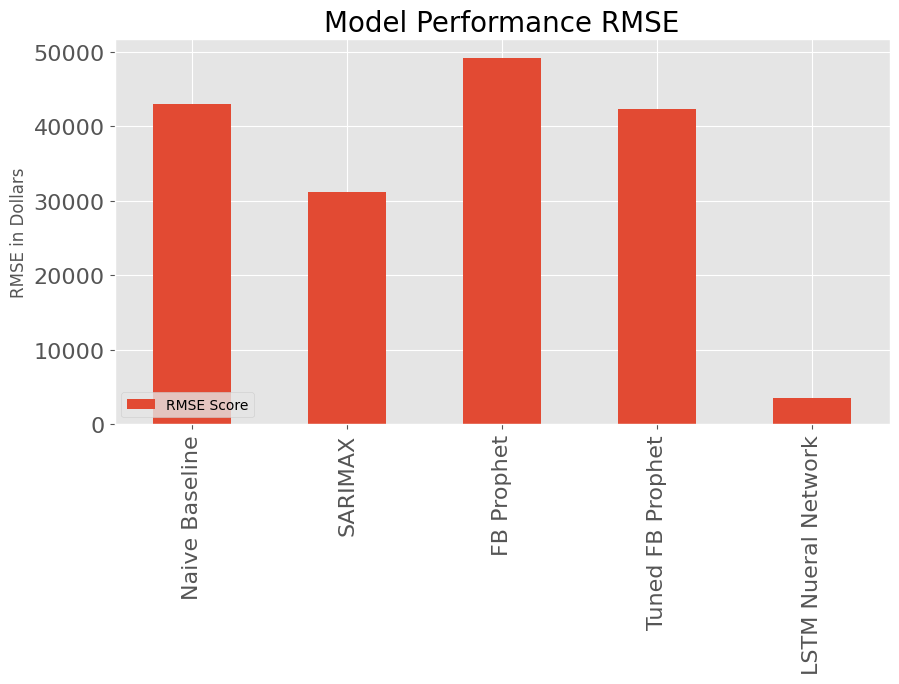

In [136]:
# create a dataframe of the scores for the different models
score_df = pd.DataFrame({'RMSE Score': [base_rmse, arima_rmse, fb_rmse,
                                           fb_final_rmse, lstm_rmse],
                        }, index=['Naive Baseline', 'SARIMAX','FB Prophet', 
                                  'Tuned FB Prophet', 'LSTM Nueral Network'])


#plot the data
score_df.plot.bar(figsize=(10,5))
plt.legend(loc='lower left')
plt.title('Model Performance RMSE', fontsize=20)
plt.ylabel('RMSE in Dollars')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);


# Forecasting the Future of 80449 Data Series with LSTM


Now that the LSTM Model has been selected as the final model for predictions, one step validation will be used to predict the price growth of zipcode 80449 five years in the future.

In [137]:
#One Step forecast for 60 months in the future
future_predictions_80449 = []
while len(future_predictions_80449) < 60:
  X = test_scaled[52, 0:1]
  yhat = forecast_lstm(lstm_model, 1, X)
  yhat_convert = invert_scale(scaler, X, yhat)
  yhat_convert = np.exp(yhat_convert)
  future_predictions_80449.append(yhat_convert)
  X = np.array([yhat])

1/1 [==============================] - 0s 34ms/step


In [138]:
#Checking Length of Predictions
len(future_predictions_80449)

60

In [139]:
#Creating dataframe with future dates
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta


start="2018-04-01" 
last="2023-04-01"
start_date=datetime.strptime(start,"%Y-%m-%d")
last_date=datetime.strptime(last,"%Y-%m-%d")
dates=[]
while start_date <= (last_date - relativedelta(months=1)):
    start_date += relativedelta(months=1)
    dates.append(start_date.strftime("%Y-%m-%d"))
print(dates)


['2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01']


In [140]:
#Check length of futures date dataframe
len(dates)

60

In [141]:
#Adding Predictions to future date dataframe
fut_tuples_80449 = list(zip(dates,future_predictions_80449))
future_80449 = pd.DataFrame(fut_tuples_80449, columns=['Date','Price'])
future_80449 = future_80449.set_index(['Date'])

In [142]:
#examining future date and prediction dataframe
future_80449

Price
Date                     
2018-05-01  274468.874127
2018-06-01  274540.210169
2018-07-01  274704.834100
2018-08-01  274867.537926
2018-09-01  274994.455588
2018-10-01  275105.861185
2018-11-01  275216.598487
2018-12-01  275332.703534
2019-01-01  275455.521918
2019-02-01  275584.020770
2019-03-01  275715.855353
2019-04-01  275847.961564
2019-05-01  275977.507928
2019-06-01  276101.299839
2019-07-01  276217.330600
2019-08-01  276323.590712
2019-09-01  276418.904476
2019-10-01  276502.782698
2019-11-01  276574.916219
2019-12-01  276635.863545
2020-01-01  276686.244853
2020-02-01  276727.070602
2020-03-01  276759.113768
2020-04-01  276783.746485
2020-05-01  276801.983283
2020-06-01  276815.018845
2020-07-01  276823.928825
2020-08-01  276829.609835
2020-09-01  276832.689589
2020-10-01  276833.975322
2020-11-01  276833.975322
2020-12-01  276833.437107
2021-01-01  276832.241079
2021-02-01  276830.925454
2021-03-01  276829.669636
2021-04-01  276828.473624
2021-05-01  276827.486918
2021-06-01  276826.799216
2021-07-01  276826.320815
2021-08-01  276826.081615
2021-09-01  276826.021815
2021-10-01  276826.021815
2021-11-01  276826.320815
2021-12-01  276826.619815
2022-01-01  276826.948716
2022-02-01  276827.337417
2022-03-01  276827.756019
2022-04-01  276828.144721
2022-05-01  276828.533424
2022-06-01  276828.832427
2022-07-01  276829.101529
2022-08-01  276829.340732
2022-09-01  276829.490234
2022-10-01  276829.669636
2022-11-01  276829.878938
2022-12-01  276829.908839
2023-01-01  276830.028440
2023-02-01  276830.028440
2023-03-01  276830.058341
2023-04-01  276829.998540

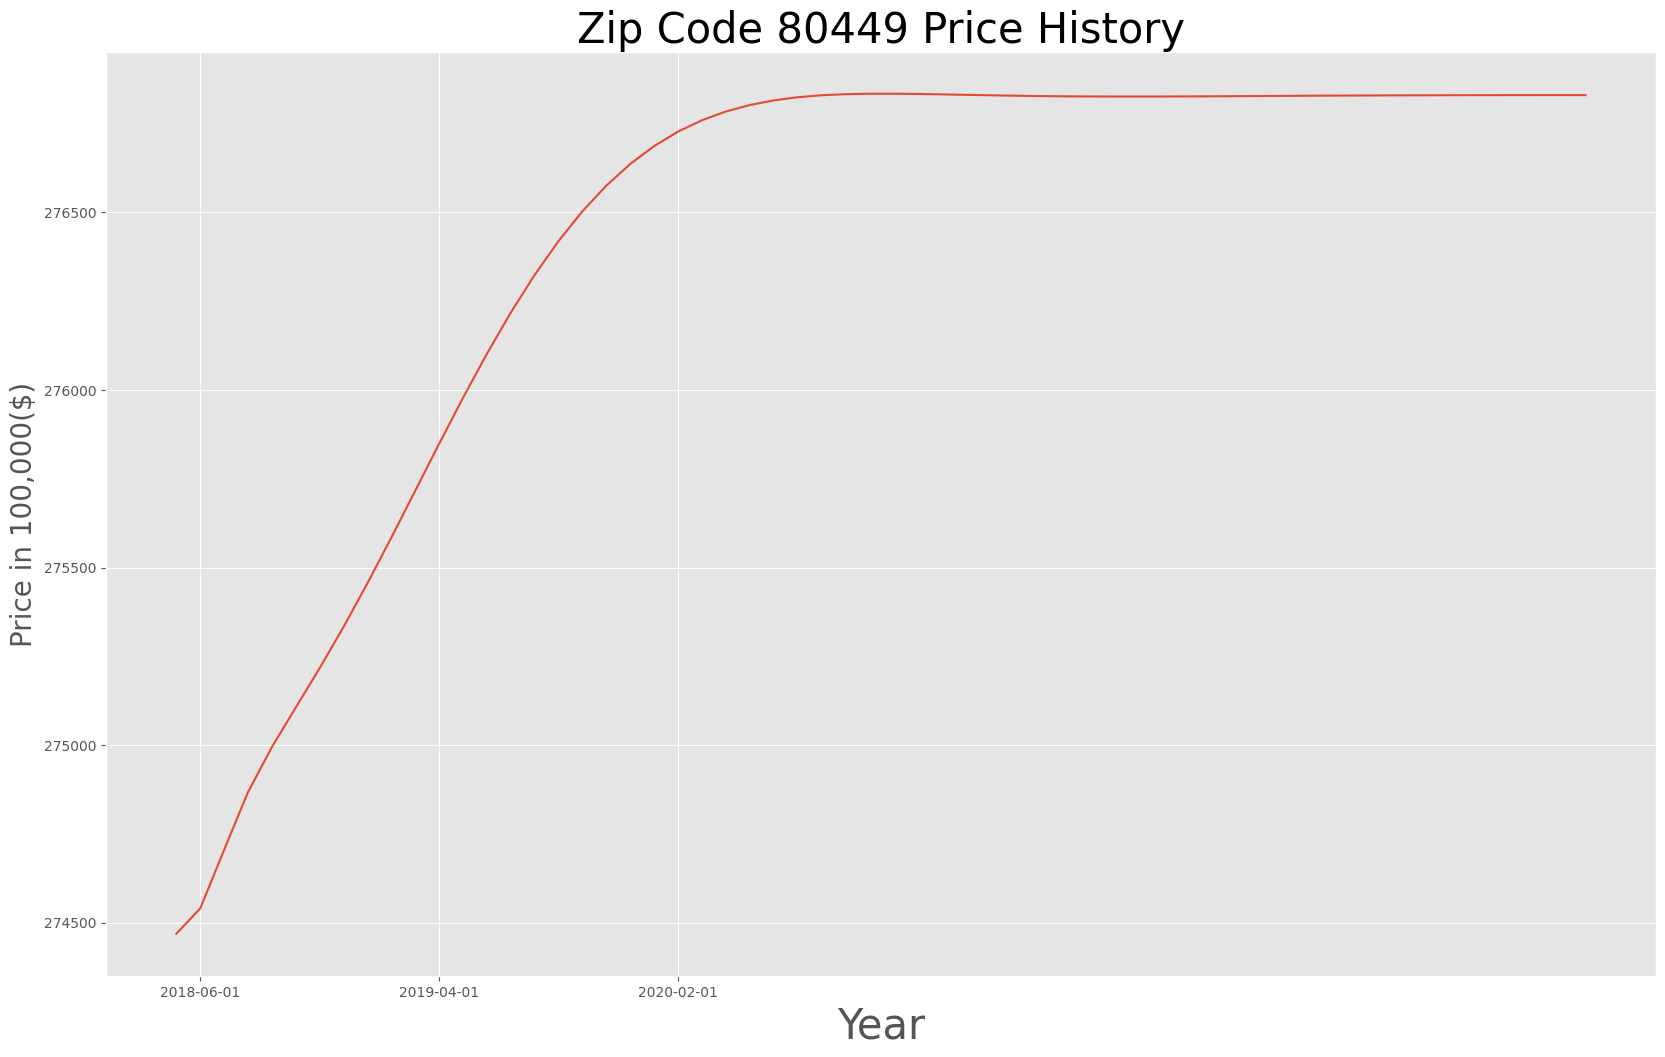

In [143]:
#Visualizing the Future Series Data for zipcode- 80449

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(future_80449)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
plt.xticks(np.arange(min(x), max(x), 10.0))
ax.set_title('Zip Code 80449 Price History',fontsize=30);

The predictions for zipcode 80449 seem to plateau around April 2022, roughly two years out from the last date in the data series (April 2018). This platuea shows that the LSTM Neural Network has reached the extent of it's forecasting process. As a result, the prediction time length will be decreased to 24 months from 60 months. Thouhg a much shorter time period, this will still be adaquate for assessing the potential greatest ROI.

In [144]:
#Limiting forecasts to 2 years 
two_year_80449 = future_80449.head(24)

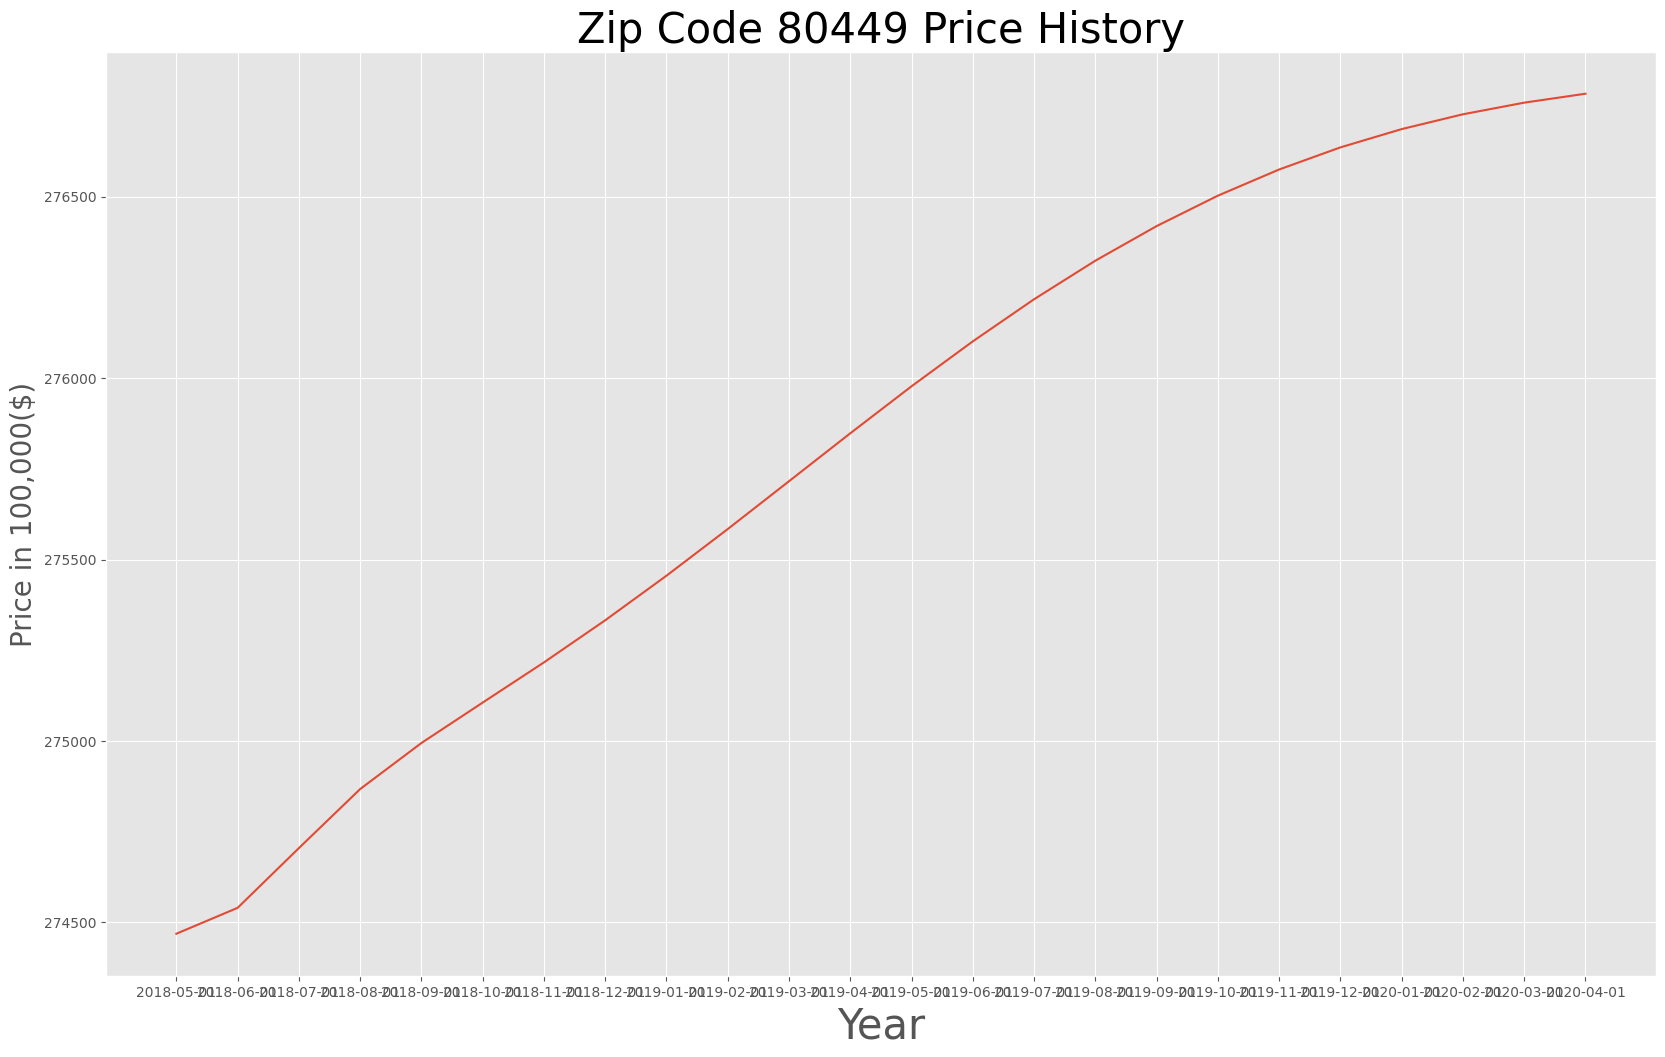

In [145]:
#Visualizing the Future Series Data for zipcode- 80449 over 2 years

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(two_year_80449)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 80449 Price History',fontsize=30);

In [146]:
#Beginning price of the two year forecast period
two_year_80449['Price'][0]

274468.8741273985

In [159]:
#Subtracting the final forecast Price from the first forecast price
two_year_gain_80449 = two_year_80449['Price'][23] - two_year_80449['Price'][0]

In [148]:
#Total gain in price over the two year forecast period
two_year_gain_80449

2314.872357812943

Using the LSTM Nueral Network Model, the prediction states that properties in zipcode 80449 will gain on average $2,314 over the two year period from April 2018 to April 2020.

# Forecasting on All Top 25 Zip Codes in Clients Budget


Now that LSTM Nueral Network model has been selected as the final model for prediction, it is time to apply it to all of the zipcodes in the Top 25 Zipcode dataset. This will include preprocessing, fitting the training data to the model, assessing the RMSE of the fit with the test data series, and predicting price growth from April 2018 to April of 2020.

In [149]:
zip_predictions = {}
top_25_for_modeling = top_25_modeling_df.drop(columns='roi_since1996')

for zipcode in top_25_for_modeling['RegionName']:

    series = melt_data(top_25_for_modeling[top_25_for_modeling['RegionName']==zipcode])
   
    # transform to supervised learning
    X = series.values
    raw_values = series.values
    supervised = timeseries_to_supervised(X, 1)

    #Taking the log of the time series
    supervised_logged = np.log(supervised)
    supervised_logged.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Define train and test sets according to the index found above
    train_sup = supervised_logged[:cutoff]
    test_sup = supervised_logged[cutoff:]

    #transforming training and testing data series to a numpy array
    train_sup = train_sup.to_numpy()
    test_sup = test_sup.to_numpy()

    # transform the scale of the test and train data
    scaler, train_scaled, test_scaled = scale(train_sup, test_sup)

    #reshape for model input
    X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    #Building LSTM Model with one hidden LSTM Layer
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
   
    #Using MSE since it closely matches RMSE
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=100, batch_size=1, verbose=2)

    #walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
      #making a one step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(model, 1, X)
      #invert scaling
        yhat = invert_scale(scaler, X, yhat)
        yhat = np.exp(yhat)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i]
        print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    rmse = np.sqrt(mean_squared_error(raw_values[-53:], predictions))
    
    future_predictions = []
    while len(future_predictions) < 23:
      X = test_scaled[52, 0:1]
      yhat = forecast_lstm(lstm_model, 1, X)
      yhat_convert = invert_scale(scaler, X, yhat)
      yhat_convert = np.exp(yhat_convert)
      future_predictions.append(yhat_convert)
      X = np.array([yhat])

    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((future_predictions[-1])
                                - (series['value'][-1]))/ (series['value'][-1])
    #zip_predictions[zipcode] = (rmse)

Streaming output truncated to the last 5000 lines.
Month=33, Predicted=234880.053966, Expected=262300.000000
1/1 [==============================] - 0s 20ms/step
Month=34, Predicted=234034.694103, Expected=262200.000000
1/1 [==============================] - 0s 22ms/step
Month=35, Predicted=233994.923426, Expected=263700.000000
1/1 [==============================] - 0s 22ms/step
Month=36, Predicted=235151.259635, Expected=265900.000000
1/1 [==============================] - 0s 21ms/step
Month=37, Predicted=236753.156868, Expected=267700.000000
1/1 [==============================] - 0s 27ms/step
Month=38, Predicted=238001.876194, Expected=269000.000000
1/1 [==============================] - 0s 24ms/step
Month=39, Predicted=238885.722985, Expected=270300.000000
1/1 [==============================] - 0s 29ms/step
Month=40, Predicted=239792.396798, Expected=270500.000000
1/1 [==============================] - 0s 28ms/step
Month=41, Predicted=239831.621792, Expected=269800.000000
1/1 [======

Now that each zipcode has been put through the full LSTM Neural Network modeling process, the ROI of each zipcode from April of 2018 to April of 2020 will be used to select the top 5 zipcodes for investment. 

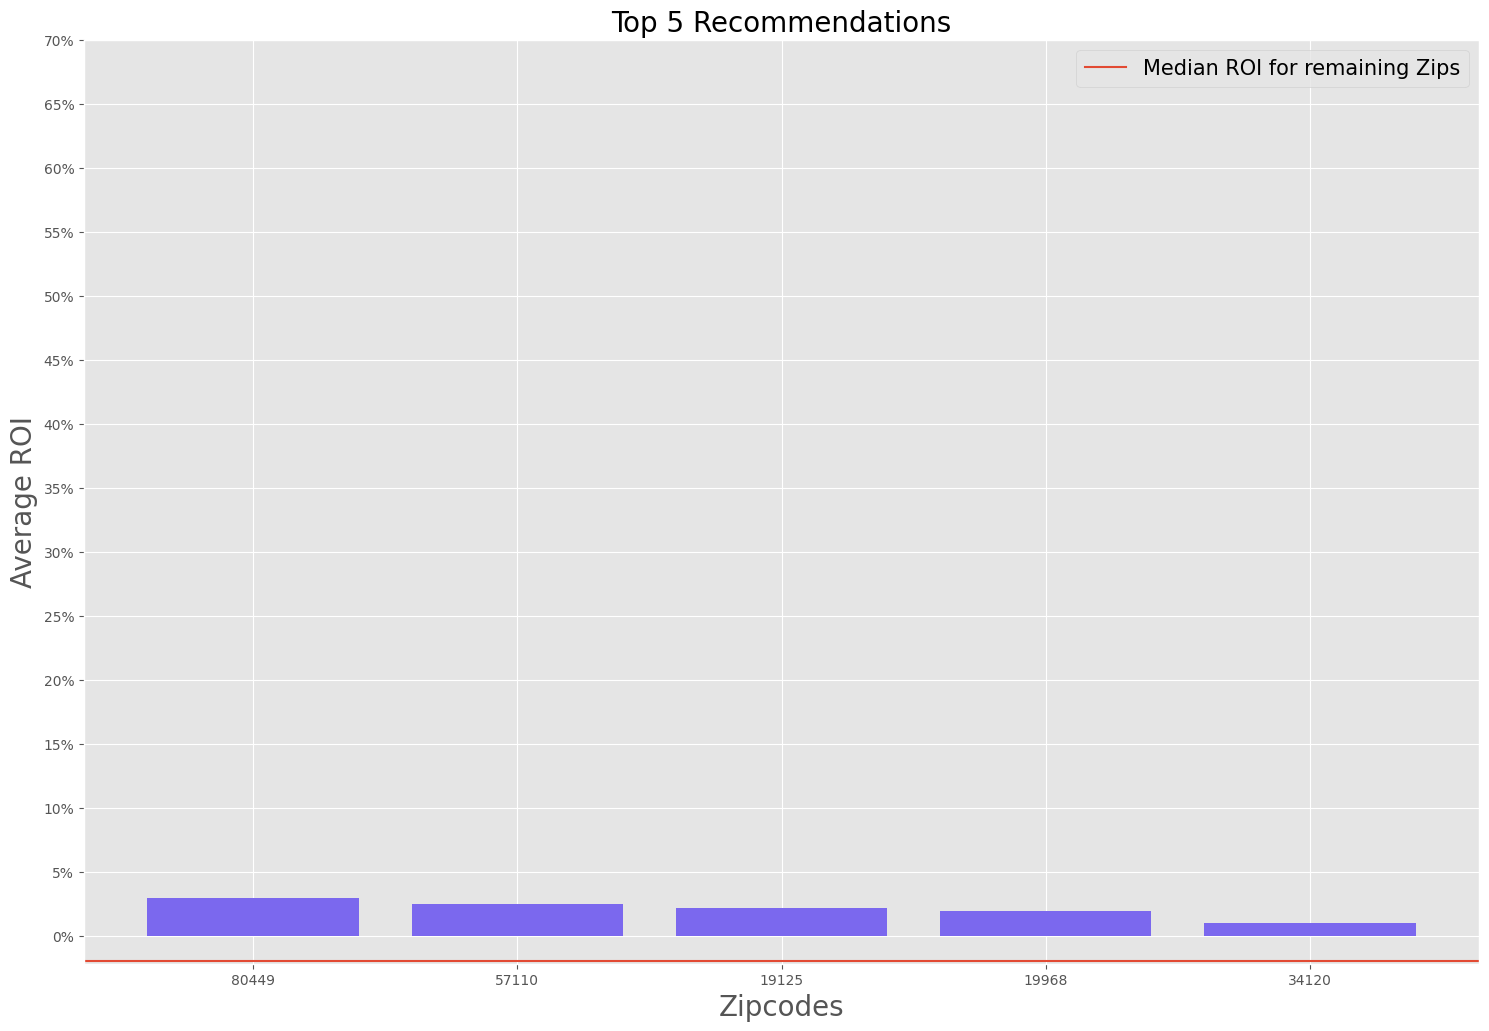

In [152]:
# Sorting the 2 year ROI forecast for zipcodes into descending order
sort_orders = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_2yr = {}
for i in sort_orders:
	sorted_forecast_2yr[i[0]] = i[1]

#Selecting only the Top 5 Zips
top_5_zipcodes = list(sorted_forecast_2yr.items())[:5]

fig, ax = plt.subplots(figsize=(18,12))

x_labels = [top_5_zipcodes[0][0],top_5_zipcodes[1][0],top_5_zipcodes[2][0],
            top_5_zipcodes[3][0],top_5_zipcodes[4][0]]
x = [1,2,3,4,5]
y = [top_5_zipcodes[0][1],top_5_zipcodes[1][1],top_5_zipcodes[2][1],
     top_5_zipcodes[3][1],top_5_zipcodes[4][1]]

ax.bar(x, y, color='mediumslateblue')
remaining_zipcodes = list(sorted_forecast_2yr.items())[5:]
median_ROI_other_zips = remaining_zipcodes[5][1]
ax.axhline(y=median_ROI_other_zips,label = 'Median ROI for remaining Zips')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([(a/100) for a in list(range(0,75,5))])
ax.set_yticklabels([str(a)+'%' for a in list(range(0,75,5))])
ax.set_title('Top 5 Recommendations', fontsize=20)
ax.set_ylabel('Average ROI', fontsize=20)
ax.set_xlabel('Zipcodes',fontsize=20)
ax.legend(prop={'size': 15});

# Final Model Interpretation

In [155]:
print(f'The Highest Growing Zipcode: {list(sorted_forecast_2yr.items())[0][0]} is expected to grow by {round((list(sorted_forecast_2yr.items())[0][1])*100,2)}%')
print(f'The Second Highest Growing Zipcode: {list(sorted_forecast_2yr.items())[1][0]} is expected to grow by {round((list(sorted_forecast_2yr.items())[1][1])*100,2)}%')
print(f'The Third Highest Growing Zipcode: {list(sorted_forecast_2yr.items())[2][0]} is expected to grow by {round((list(sorted_forecast_2yr.items())[2][1])*100,2)}%')
print(f'The Fourth Highest Growing Zipcode: {list(sorted_forecast_2yr.items())[3][0]} is expected to grow by {round((list(sorted_forecast_2yr.items())[3][1])*100,2)}%')
print(f'The Fifth Highest Growing Zipcode: {list(sorted_forecast_2yr.items())[4][0]} is expected to grow by {round((list(sorted_forecast_2yr.items())[4][1])*100,2)}%')

The Highest Growing Zipcode: 80449 is expected to grow by 2.97%
The Second Highest Growing Zipcode: 57110 is expected to grow by 2.49%
The Third Highest Growing Zipcode: 19125 is expected to grow by 2.17%
The Fourth Highest Growing Zipcode: 19968 is expected to grow by 1.9%
The Fifth Highest Growing Zipcode: 34120 is expected to grow by 0.95%


The Final Model was developed by building a LSTM Nueral Network Model which had an **RMSE score of 3576.85**. According to the Final Model, the following five zipcodes had the higest return on investment from April 2018 to April of 2020.

*   **Zipcode 80449 in Central Colorado with a growth of 2.97%**
*  **Zipcode 57110 in South Dakota with a growth of 2.49%**
*   **Zipcode 19125 in Pennsylvania with a growth of 2.17%**
*   **Zipcode 19968 in Delaware with a growth of 1.9%**
*   **Zipcode 34120 in Florida with a growth of .95%**

It is important to note that the predictions made for April of 2020 are now in the past. It is therefore possible to see if these trends were correct. Using Redfin's zipcode growth comparison for four out of the five zipcodes, it is interesting to see that the model did correctly assess the overall positive trends in price, even if there was some discrepancy with the actual predicted growth rates. As with all prediction models, every system is controlled by a set of processes that are only so predictable. 




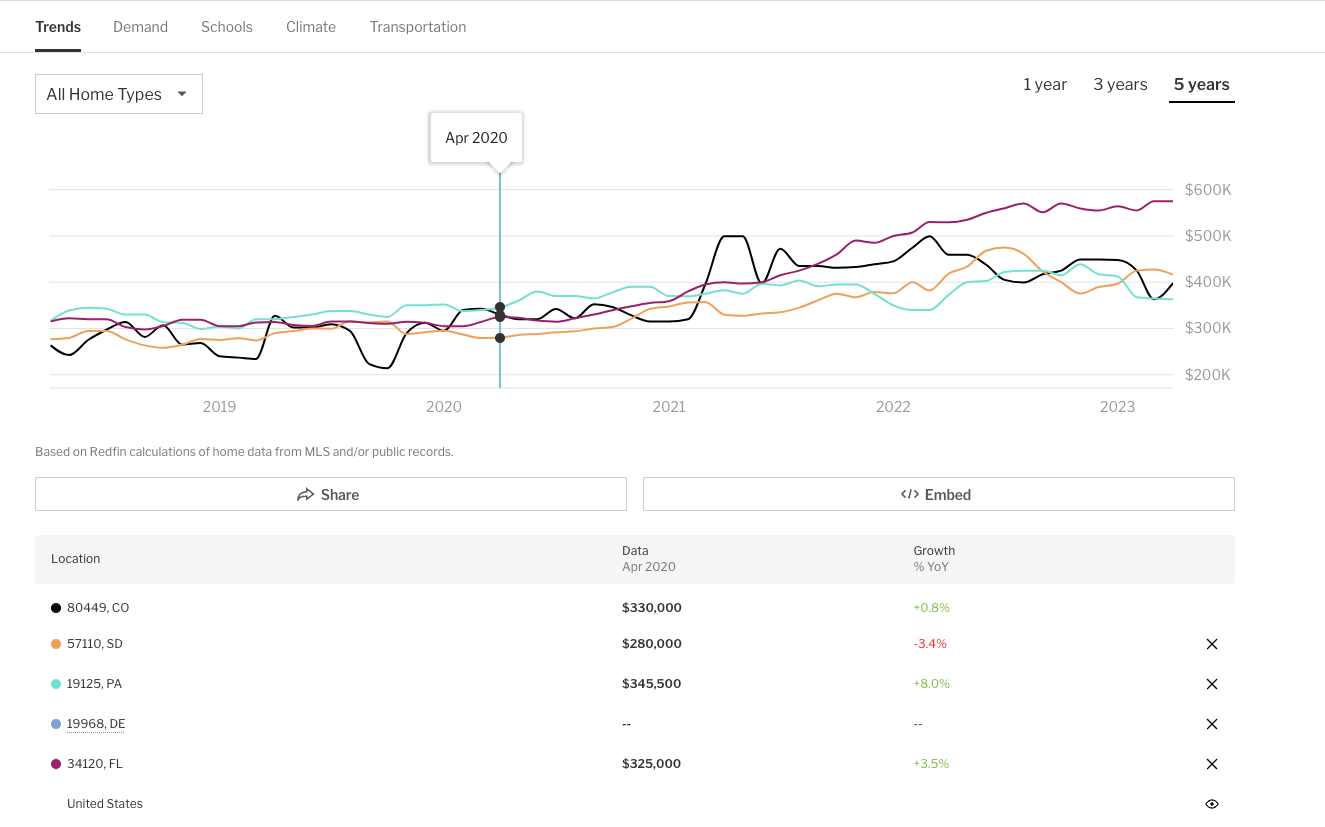

In [157]:
#creating a visualization map of top five zipcodes
recommended_zips = pd.DataFrame([a for a in sorted_forecast_2yr.keys()][:5])
recommended_zips.columns = ['RegionName']
final_zips_map = pd.merge(recommended_zips, zip_long_lat, how="left", on=["RegionName"])
print(final_zips_map)

   RegionName  Latitude  Longitude
0       80449  38.95689 -105.87044
1       57110  43.54969  -96.63113
2       19125  39.97641  -75.12217
3       19968  38.76454  -75.29784
4       34120  26.32277  -81.55923


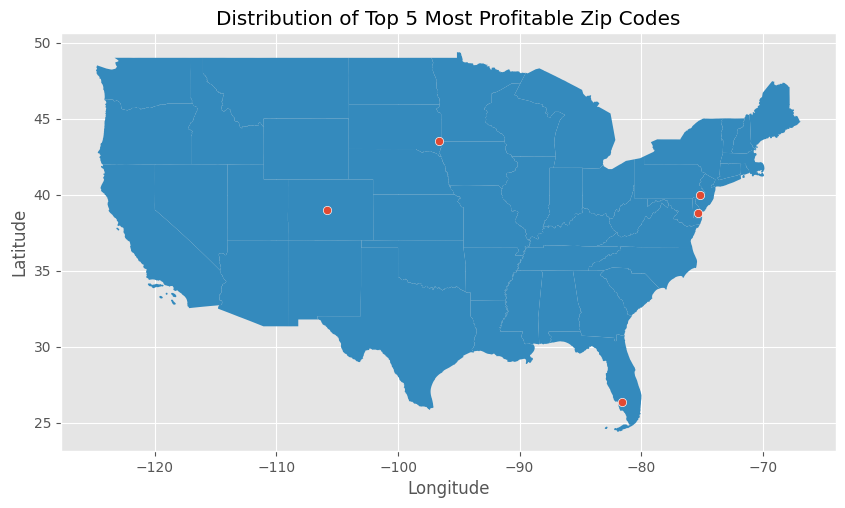

In [158]:
#plotting top five zipcodes on the map
geometry = [Point(xy) for xy in zip(final_zips_map['Longitude'], final_zips_map['Latitude'])] #create Points
geo_df = gpd.GeoDataFrame(final_zips_map, 
                          crs = crs, 
                          geometry = geometry) #define the geometry df

#plot the data
fig, ax = plt.subplots(figsize = (10,10))
us49.to_crs(epsg=4326).plot(ax=ax)
sns.scatterplot(x="Longitude", y="Latitude",data=final_zips_map, ax=ax)
ax.set_title('Distribution of Top 5 Most Profitable Zip Codes');

# Conclusion

Compass Real Estate has a final model for prediction with an RMSE score of 3576.85. This model was used to make predictions on the top 25 zipcodes with average property values under $300,00 in order to make a recommednation of five zipcodes for investment. 

The five zipcodes were 80449, 57110, 19125, 19968, and 34120.

The Final Model was developed by building a LSTM Nueral Network Model which had an **RMSE score of 3576.85**. According to the Final Model, the following five zipcodes had the higest return on investment from April 2018 to April of 2020.

*   **Zipcode 80449 in Central Colorado with a growth of 2.97%**
*  **Zipcode 57110 in South Dakota with a growth of 2.49%**
*   **Zipcode 19125 in Pennsylvania with a growth of 2.17%**
*   **Zipcode 19968 in Delaware with a growth of 1.9%**
*   **Zipcode 34120 in Florida with a growth of .95%**

It is important to note that the predictions made for April of 2020 are now in the past. It is therefore possible to see if these trends were correct. Using Redfin's zipcode growth comparison for four out of the five zipcodes, it is interesting to see that the model did correctly assess the overall positive trends in price, even if there was some discrepancy with the actual predicted growth rates. As with all prediction models, every system is controlled by a set of processes that are only so predictable. 


